*Note that the networks in this exercise are undirected.*

*Recall the Watts-Strogatz network model from Topic 2.  Here we define a similar model which we call the **Variable Degree Watts-Strogatz (VDWS) model**.  This is how a **VDWS-network** is constructed.*

* *Let $n$ and $m$ be positive integers.  Let $p$ be a real number between 0 and 1.  Create a set of $n$ vertices labelled 0 to $n-1$.  We think of these as being arranged on a circle so if two adjacent vertices are close to each other on the circle, it is clear what is meant if we say that one is the clockwise neighbour of the other.  For example 4 is a clockwise neighbour of 2.*
* *For each $v$, let $\ell(v)$ be the local degree of $v$.  Choose the values $\ell(v)$ randomly such that they have a zero-truncated Poisson distribution with parameter $m$ (see below).  *
* *Join each vertex $v$ to vertices $v - \ell(v), v - \ell(v) + 1, \ldots, v-1, v+1, \ldots v + \ell(v) - 1, v + \ell(v)$ where addition is ${}\bmod n$.  Thus each vertex will have degree at least $2\ell(v)$, but it might be more.  For example, if 3 has local degree 2, then it will be adjacent to 1, 2, 4 and 5.   But if 10 has local degree 7, there will also be an edge between 3 and 10.*
* *For each vertex $v$, for each edge from $v$ to a clockwise neighbour $w$: with probability $p$, the edge from $v$ to $w$ is deleted and replaced by an edge from $v$ to a vertex $x$ chosen uniformly at random from all the vertices in the network. We call this process *rewiring*. If $x=v$ or $x$ is already a neighbour of $v$, then we do nothing and the edge from $v$ to $w$ is kept.  (Note that in this way, each of the edges created in the previous step should be considered exactly once for rewiring, and that edges that are created by rewiring should not be later rewired themselves.)*

*You will need to write code to create VDWS-networks.  You can use the code for WS-networks (see Topic 4 on Learn Ultra) as a starting point. To create values that are sampled from a zero-truncated Poisson distribution with parameter $m=10$, say, you can use the following code.*

```python
import numpy as np
local_degrees = np.random.poisson(10, 100)
local_degrees = local_degrees[local_degrees > 0]
```

*Note that the number of values created cannot be predicted precisely since the second line samples 100 values from a Poisson distribution and then the third line removes the zeros (although zeros are very unlikely for the value of $m$ we will use).*


Find below some auxiliary code that imports the libraries used.

In [1]:
from typing import Dict
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random as random
import numpy as np
from time import sleep
from copy import deepcopy
from pprint import pprint

plt.rcParams["figure.dpi"] = 300


def print_status_bar(progress: float, block_count: int = 10) -> None:
    clear_output(wait=True)
    dark_string = "▓" * round(progress * block_count)
    light_string = "░" * (block_count - len(dark_string))
    print(f"[{dark_string}{light_string}]")

Find below the code to generate the VDWS network.

In [2]:
def make_vdws_network(node_count: int,
                      poisson_parameter: int,
                      rewire_probability: float) -> Dict[int, set[int]]:
    debug_period = node_count / 160

    vdws_graph = dict()
    local_degrees = dict()

    # generate local degrees
    l = np.random.poisson(poisson_parameter, node_count)
    while len(l) < node_count:  # very low chance this is invoked even once
        l = np.random.poisson(poisson_parameter, node_count)

    for node in range(node_count):  # circular graph
        vdws_graph[node] = {(node + 1) % node_count, (node - 1) % node_count}
        local_degrees[node] = l[node]
    for node in vdws_graph:
        for circular_neighbour_no_mod in range(node - local_degrees[node], node + local_degrees[node] + 1):
            circular_neighbour = circular_neighbour_no_mod % node_count
            if circular_neighbour == node:
                continue
            vdws_graph[node].add(circular_neighbour)
            vdws_graph[circular_neighbour].add(node)
        # debug
        if node % debug_period == 0:
            print_status_bar(node / len(vdws_graph), block_count=80)
            print("[1/2]  Building circular graph base")
    # rewiring
    for node in vdws_graph:
        for clockwise_neighbour_no_mod in range(node + 1, node + 1 + local_degrees[node]):
            clockwise_neighbour = clockwise_neighbour_no_mod % node_count
            if random.random() < rewire_probability:
                x = int(random.random() * node_count)
                if x == node or x in vdws_graph[node]:
                    continue
                vdws_graph[node].remove(clockwise_neighbour)
                vdws_graph[clockwise_neighbour].remove(node)
                vdws_graph[node].add(x)
                vdws_graph[x].add(node)
        # debug
        if node % debug_period == 0:
            print_status_bar(node / len(vdws_graph), block_count=80)
            print("[2/2]  Rewiring")
    return vdws_graph

# Question 1



1. *[20 marks] Consider the epidemic model with vaccinations from the Topic 4 lecture notes with states S, I, V, VI and R.  Using this model, simulate the spread of disease on a VDWS-network with $n=200000$, $m=25$ and $p=0.01$.  Assume that initially 5 randomly chosen vertices are in I and every other node is in S.  From $t=50$, at each time step move 400 randomly chosen vertices from S to V (until S is empty).  Let $t_I=2$ and consider various values for the other parameters.   Initially let $p(\operatorname I, \operatorname S)=p(\operatorname I, \operatorname V)=p(\operatorname{VI}, \operatorname S)=p(\operatorname{VI}, \operatorname V)=0.01$ (implying that the vaccination is ineffective).   Then consider cases where $p(\operatorname I, \operatorname S)=0.01$ but the other probabilities are lower, modelling the cases where the vaccination protects against infection, transmission or both.  In each case, create plots that show  how the number of vertices in each of the five states varies over time.  Comment on your findings.*


First we generate our VDWS network as stipulated.

In [3]:
random.seed(69420)
np.random.seed(69420)
vdws_network = make_vdws_network(200000, 25, 0.01)
clear_output(wait=True)
print(f"Generated VDWS network with {len(vdws_network)} nodes.")

Generated VDWS network with 200000 nodes.


Below find my epidemic model.

In [4]:
class EpidemicModel:
    # STATE KEY
    ## 0 - susceptible
    ## 1 - infected
    ## 2 - vaccinated
    ## 3 - vaccinated and infected
    ## 4 - removed
    def __init__(self, network: Dict[int, set[int]], initial_infected_count: int = 5, infection_length: int = 2,
                 pis: float = 0.01, piv: float = 0.01, pvis: float = 0.01, pviv: float = 0.01,
                 vaccination_priority: list[int] = None):
        self.network = network

        self.pis = pis
        self.piv = piv
        self.pvis = pvis
        self.pviv = pviv

        self.infection_length = infection_length

        self.tick_count = 0

        self.vaccination_tick_threshold = 50
        self.vaccination_per_tick = 400

        self.states = dict()
        self.susceptible_nodes = set()
        self.state_counts = dict()
        for i in range(5):
            self.state_counts[i] = 0
        for node in self.network:
            self.states[node] = {"state": 0, "infection_time_remaining": 0}
            self.states[node]["state"] = 0
            self.susceptible_nodes.add(node)
        self.state_counts[0] = len(self.network)
        initial_infected = random.sample(range(len(network)), initial_infected_count)
        for v in initial_infected:
            self.infect(v)

        if vaccination_priority is not None:
            if len(vaccination_priority) != len(self.network):
                raise ValueError("Not enough nodes in vaccination_priority.")
        self.vaccination_priority = vaccination_priority

    def get_state_counts(self) -> Dict[int, int]:
        return self.state_counts

    def get_tick_count(self) -> int:
        return self.tick_count

    def get_transmission_probability(self, node: int, contact_node: int) -> float:
        if node == contact_node:
            raise ValueError("A node cannot infect to itself.")
        if self.get_state(node) == 1:
            if self.states[contact_node]["state"] == 0:
                return self.pis
            if self.states[contact_node]["state"] == 2:
                return self.piv
        if self.get_state(node) == 3:
            if self.states[contact_node]["state"] == 0:
                return self.pvis
            if self.states[contact_node]["state"] == 2:
                return self.pviv
        if self.states[contact_node]["state"] not in [0, 2]:
            raise ValueError(
                f"Node {contact_node} cannot be infectable, it is in state {self.states[contact_node]['state']}.")
        raise ValueError(f"Node {node} is not infectious, it is in state {self.states[node]['state']}.")

    def get_state(self, node: int) -> int:
        return self.states[node]["state"]

    def get_susceptible_nodes(self) -> set[int]:
        return self.susceptible_nodes.copy()

    def is_infectious_period_over(self, node: int) -> bool:
        return self.states[node]["infection_time_remaining"] == 0

    def is_infectious(self, node: int) -> bool:
        return self.get_state(node) in [1, 3]

    def is_infectable(self, node: int) -> bool:
        return self.get_state(node) in [0, 2]

    def is_epidemic_over(self) -> bool:
        return self.state_counts[1] == 0 and self.state_counts[3] == 0

    def infect(self, node: int) -> None:
        if self.get_state(node) in [1, 3, 4]:
            raise ValueError(f"Node cannot be infected, in state {self.states[node]}.")
        if self.get_state(node) == 2:
            self.state_counts[2] -= 1
            self.state_counts[3] += 1
            self.states[node]["state"] = 3
            self.states[node]["infection_time_remaining"] = self.infection_length
            return
        self.state_counts[0] -= 1
        self.state_counts[1] += 1
        self.states[node]["state"] = 1
        self.susceptible_nodes.remove(node)
        self.states[node]["infection_time_remaining"] = self.infection_length

    def vaccinate(self, node: int) -> None:  # todo
        if self.get_state(node) != 0:
            raise ValueError(f"Node {node} is not vaccinatable, it is in state {self.get_state(node)}.")
        self.state_counts[0] -= 1
        self.state_counts[2] += 1
        self.states[node]["state"] = 2
        self.susceptible_nodes.remove(node)

    def remove(self, node: int) -> None:
        if self.get_state(node) not in [1, 3]:
            raise ValueError(
                f"Node {node} cannot be removed, as it is not infection. It is in state {self.states[node]['state']}.")
        if self.get_state(node) == 1:
            self.state_counts[1] -= 1
        else:
            self.state_counts[3] -= 1
        self.state_counts[4] += 1
        self.states[node]["state"] = 4
        self.states[node]["infection_time_remaining"] = 0

    def increment_tick_count(self) -> None:
        self.tick_count += 1

    def reduce_infection_time_remaining(self, node: int) -> None:
        if self.get_state(node) not in [1, 3]:
            raise ValueError(f"Node {node} is not infection, it has state {self.get_state(node)}.")
        self.states[node]["infection_time_remaining"] -= 1

    def tick(self) -> None:
        if self.is_epidemic_over():
            raise Exception("Model can not be ticked, epidemic is over.")
        self.increment_tick_count()

        # We decrement the infection time before infecting people, as they don't get infected until next tick
        for node in self.network:
            if self.get_state(node) not in [1, 3]:
                continue
            self.reduce_infection_time_remaining(node)

        # Find nodes to infect by next tick
        nodes_to_infect = set()
        for node in self.network:
            if not self.is_infectious(node):
                continue
            for neighbour in self.network[node]:
                if not self.is_infectable(neighbour):
                    continue
                if random.random() < self.get_transmission_probability(node, neighbour):
                    nodes_to_infect.add(neighbour)

        # Remove the nodes that are no longer infection
        for node in self.network:
            if self.get_state(node) not in [1, 3]:
                continue
            if self.is_infectious_period_over(node):
                self.remove(node)
                continue

        # Infect nodes
        for node in nodes_to_infect:
            self.infect(node)

        # Move people to vaccinated
        if self.get_tick_count() < self.vaccination_tick_threshold:
            return
        if self.vaccination_priority is None:
            susceptible_nodes = self.get_susceptible_nodes()
            if len(susceptible_nodes) < self.vaccination_per_tick:
                for node in susceptible_nodes:
                    self.vaccinate(node)
                return
            for node in random.sample(tuple(susceptible_nodes), self.vaccination_per_tick):
                self.vaccinate(node)
            return
        to_vaccinate = set()
        while len(to_vaccinate) < self.vaccination_per_tick and len(self.vaccination_priority) > 0:
            node = self.vaccination_priority.pop(0)
            if self.get_state(node) != 0:
                continue
            to_vaccinate.add(node)
        for node in to_vaccinate:
            self.vaccinate(node)


Below is some auxiliary code for printing and plotting results of models.

In [5]:
def print_state_counts(state_counts: dict[int, int], column_width: int) -> None:
    cols = [
        ["S", str(state_counts[0])],
        ["I", str(state_counts[1])],
        ["V", str(state_counts[2])],
        ["VI", str(state_counts[3])],
        ["R", str(state_counts[4])]
    ]
    for line_number in range(len(cols[0])):
        for column_number in range(len(cols)):
            print(cols[column_number][line_number].ljust(column_width), end="")
        print()


def get_state_counts_text(state_counts: dict[int, int], column_width: int) -> None:
    output_string = ""
    cols = [
        ["S", str(state_counts[0])],
        ["I", str(state_counts[1])],
        ["V", str(state_counts[2])],
        ["VI", str(state_counts[3])],
        ["R", str(state_counts[4])]
    ]
    for line_number in range(len(cols[0])):
        for column_number in range(len(cols)):
            output_string += cols[column_number][line_number].ljust(column_width)
        output_string += "\n"
    return output_string


def print_model_status(epidemic_model: EpidemicModel, total_tick_count: int, column_width: int,
                       finished: bool = True) -> None:
    if epidemic_model.is_epidemic_over():
        print_status_bar(1, block_count=100)
    else:
        print_status_bar(epidemic_model.get_tick_count() / total_tick_count, block_count=100)
    print_state_counts(epidemic_model.get_state_counts(), column_width)
    if finished:
        print(f"Total ticks {epidemic_model.get_tick_count()}")
        return
    print(f"Tick {epidemic_model.get_tick_count()}")


def run_model(epidemic_model: EpidemicModel, tick_count: int, column_width: int = 20, quiet=False) -> list[list[int]]:
    state_counts_list = []
    for _, state_count in epidemic_model.get_state_counts().items():
        state_counts_list.append([state_count])

    if not quiet:
        print_model_status(epidemic_model, tick_count, column_width=column_width, finished=False)
    for _ in range(tick_count):
        if epidemic_model.is_epidemic_over():
            break
        epidemic_model.tick()
        state_counts = epidemic_model.get_state_counts()
        for state, state_count in state_counts.items():
            state_counts_list[state].append(state_count)
        if not quiet:
            print_model_status(epidemic_model, tick_count, column_width=column_width, finished=False)
    if not quiet:
        print_model_end(epidemic_model)
    return state_counts_list


def print_model_end(epidemic_model: EpidemicModel) -> None:
    if not epidemic_model.is_epidemic_over():
        raise Exception("Epidemic not over!")
    clear_output(wait=True)
    print("Model ended with the following state distribution.")
    print_state_counts(epidemic_model.get_state_counts(), column_width=10)
    print(f"Total tick count: {epidemic_model.get_tick_count()}")


def get_model_end_text(epidemic_model: EpidemicModel) -> str:
    if not epidemic_model.is_epidemic_over():
        raise Exception("Epidemic not over!")
    output_string = ""
    output_string += "Model ended with the following state distribution.\n"
    output_string += get_state_counts_text(epidemic_model.get_state_counts(), column_width=10)
    output_string += f"Total tick count: {epidemic_model.get_tick_count()}"
    return output_string


def plot_epidemic_model_results(states_over_time: list[list[int]], title: str = "", max_x: int = None,
                                max_y: int = None, figure_size=(20, 10)) -> None:
    legend_names = ["S", "I", "V", "VI", "R"]
    x = np.linspace(0, len(states_over_time[0]), len(states_over_time[0]))
    plt.rcParams["figure.figsize"] = figure_size
    if max_x is None:
        plt.xlim([0, len(states_over_time[0])])
    else:
        plt.xlim([0, max_x])
    if max_y is not None:
        plt.ylim([0, max_y])
    plt.xlabel("Tick number", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(title, fontsize=20)
    for i, (states, legend_name) in enumerate(zip(states_over_time, legend_names)):
        if i in [0]: continue
        plt.plot(x, states, label=legend_name)
    plt.legend(loc="best", prop={'size': 20})
    plt.show()

First, we examine the model for which vaccines have no effect on infection or transmission.

In [6]:
ep_model_initial = EpidemicModel(vdws_network, infection_length=2)
_ = run_model(ep_model_initial, tick_count=500)

Model ended with the following state distribution.
S         I         V         VI        R         
199941    0         0         0         59        
Total tick count: 18


We that this model quickly dies out. We run this model 10 times below and see that each time it ends with minimal (typically less than 200) people being infected.

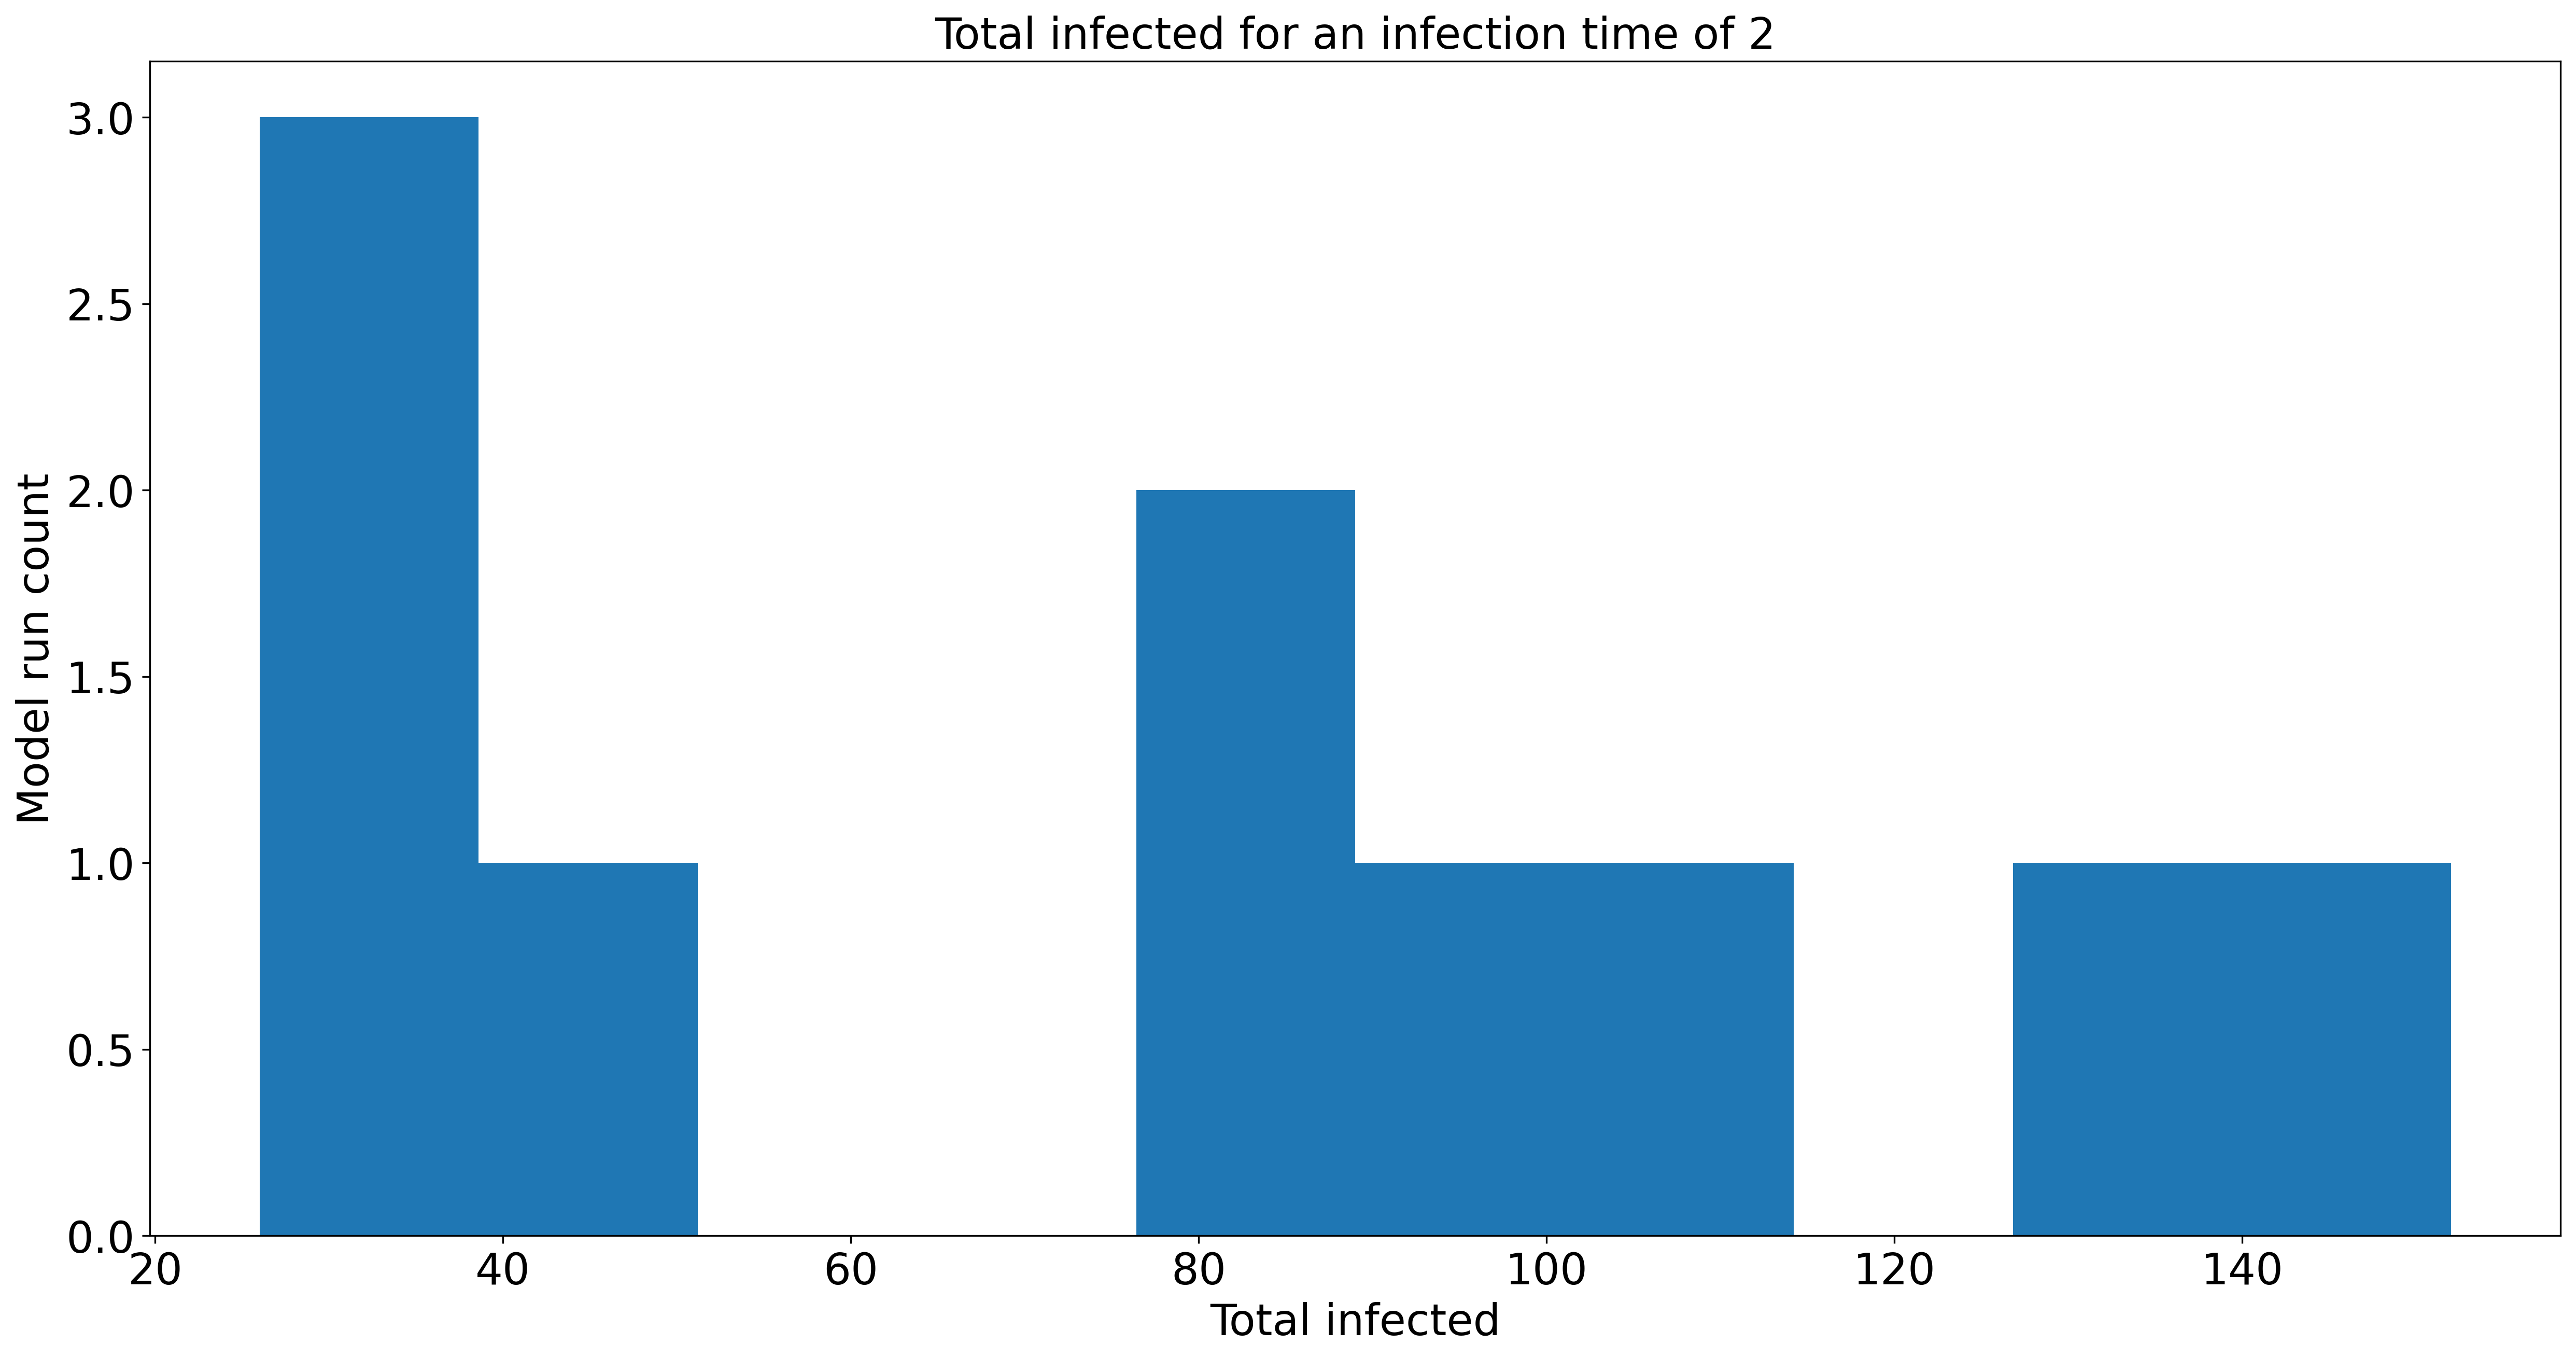

In [7]:
total_infected_counts = []
print_status_bar(0, block_count=80)
print("Running model 1/10.")
for i in range(10):
    model = EpidemicModel(vdws_network, infection_length=2)
    while not model.is_epidemic_over():
        model.tick()
    if i != 9:
        print_status_bar((i + 1) / 9, block_count=80)
        print(f"Running model {i + 2}/10.")
    total_infected_counts.append(model.get_state_counts()[4])
clear_output(wait=True)

plt.rcParams["figure.figsize"] = (20, 10)
plt.xlabel("Total infected", fontsize=20)
plt.ylabel("Model run count", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Total infected for an infection time of 2", fontsize=20)
plt.hist(total_infected_counts)
plt.show()

We use this to justify the need to increase the infection length to 3 ticks, which gives us a model in which we can do much more commentary. We run the model when only

- (1) vaccines are ineffective; and
- (2) the transmission probability from any two people is reduced by 50%.

In [8]:
random.seed(69420)
ep_model_1 = EpidemicModel(vdws_network, infection_length=3)
ep_model_1_results = run_model(ep_model_1, tick_count=500)

Model ended with the following state distribution.
S         I         V         VI        R         
9822      0         78620     0         111558    
Total tick count: 311


And now we examine when vaccinations reduce the transmission and infection rate by a half.

In [9]:
random.seed(69420)
ep_model_2 = EpidemicModel(vdws_network, piv=0.005, pvis=0.005, pviv=0.0025, infection_length=3)
ep_model_2_results = run_model(ep_model_2, tick_count=500)

Model ended with the following state distribution.
S         I         V         VI        R         
103652    0         72040     0         24308     
Total tick count: 234


We now plot the count of each state over the tick numbers, not that we do not plot the susceptible count over time (and we do this for subsequent plots) as this gives redundant information and diminishes the visibility of the infected count over time (and this is small even without susceptible count plotted).

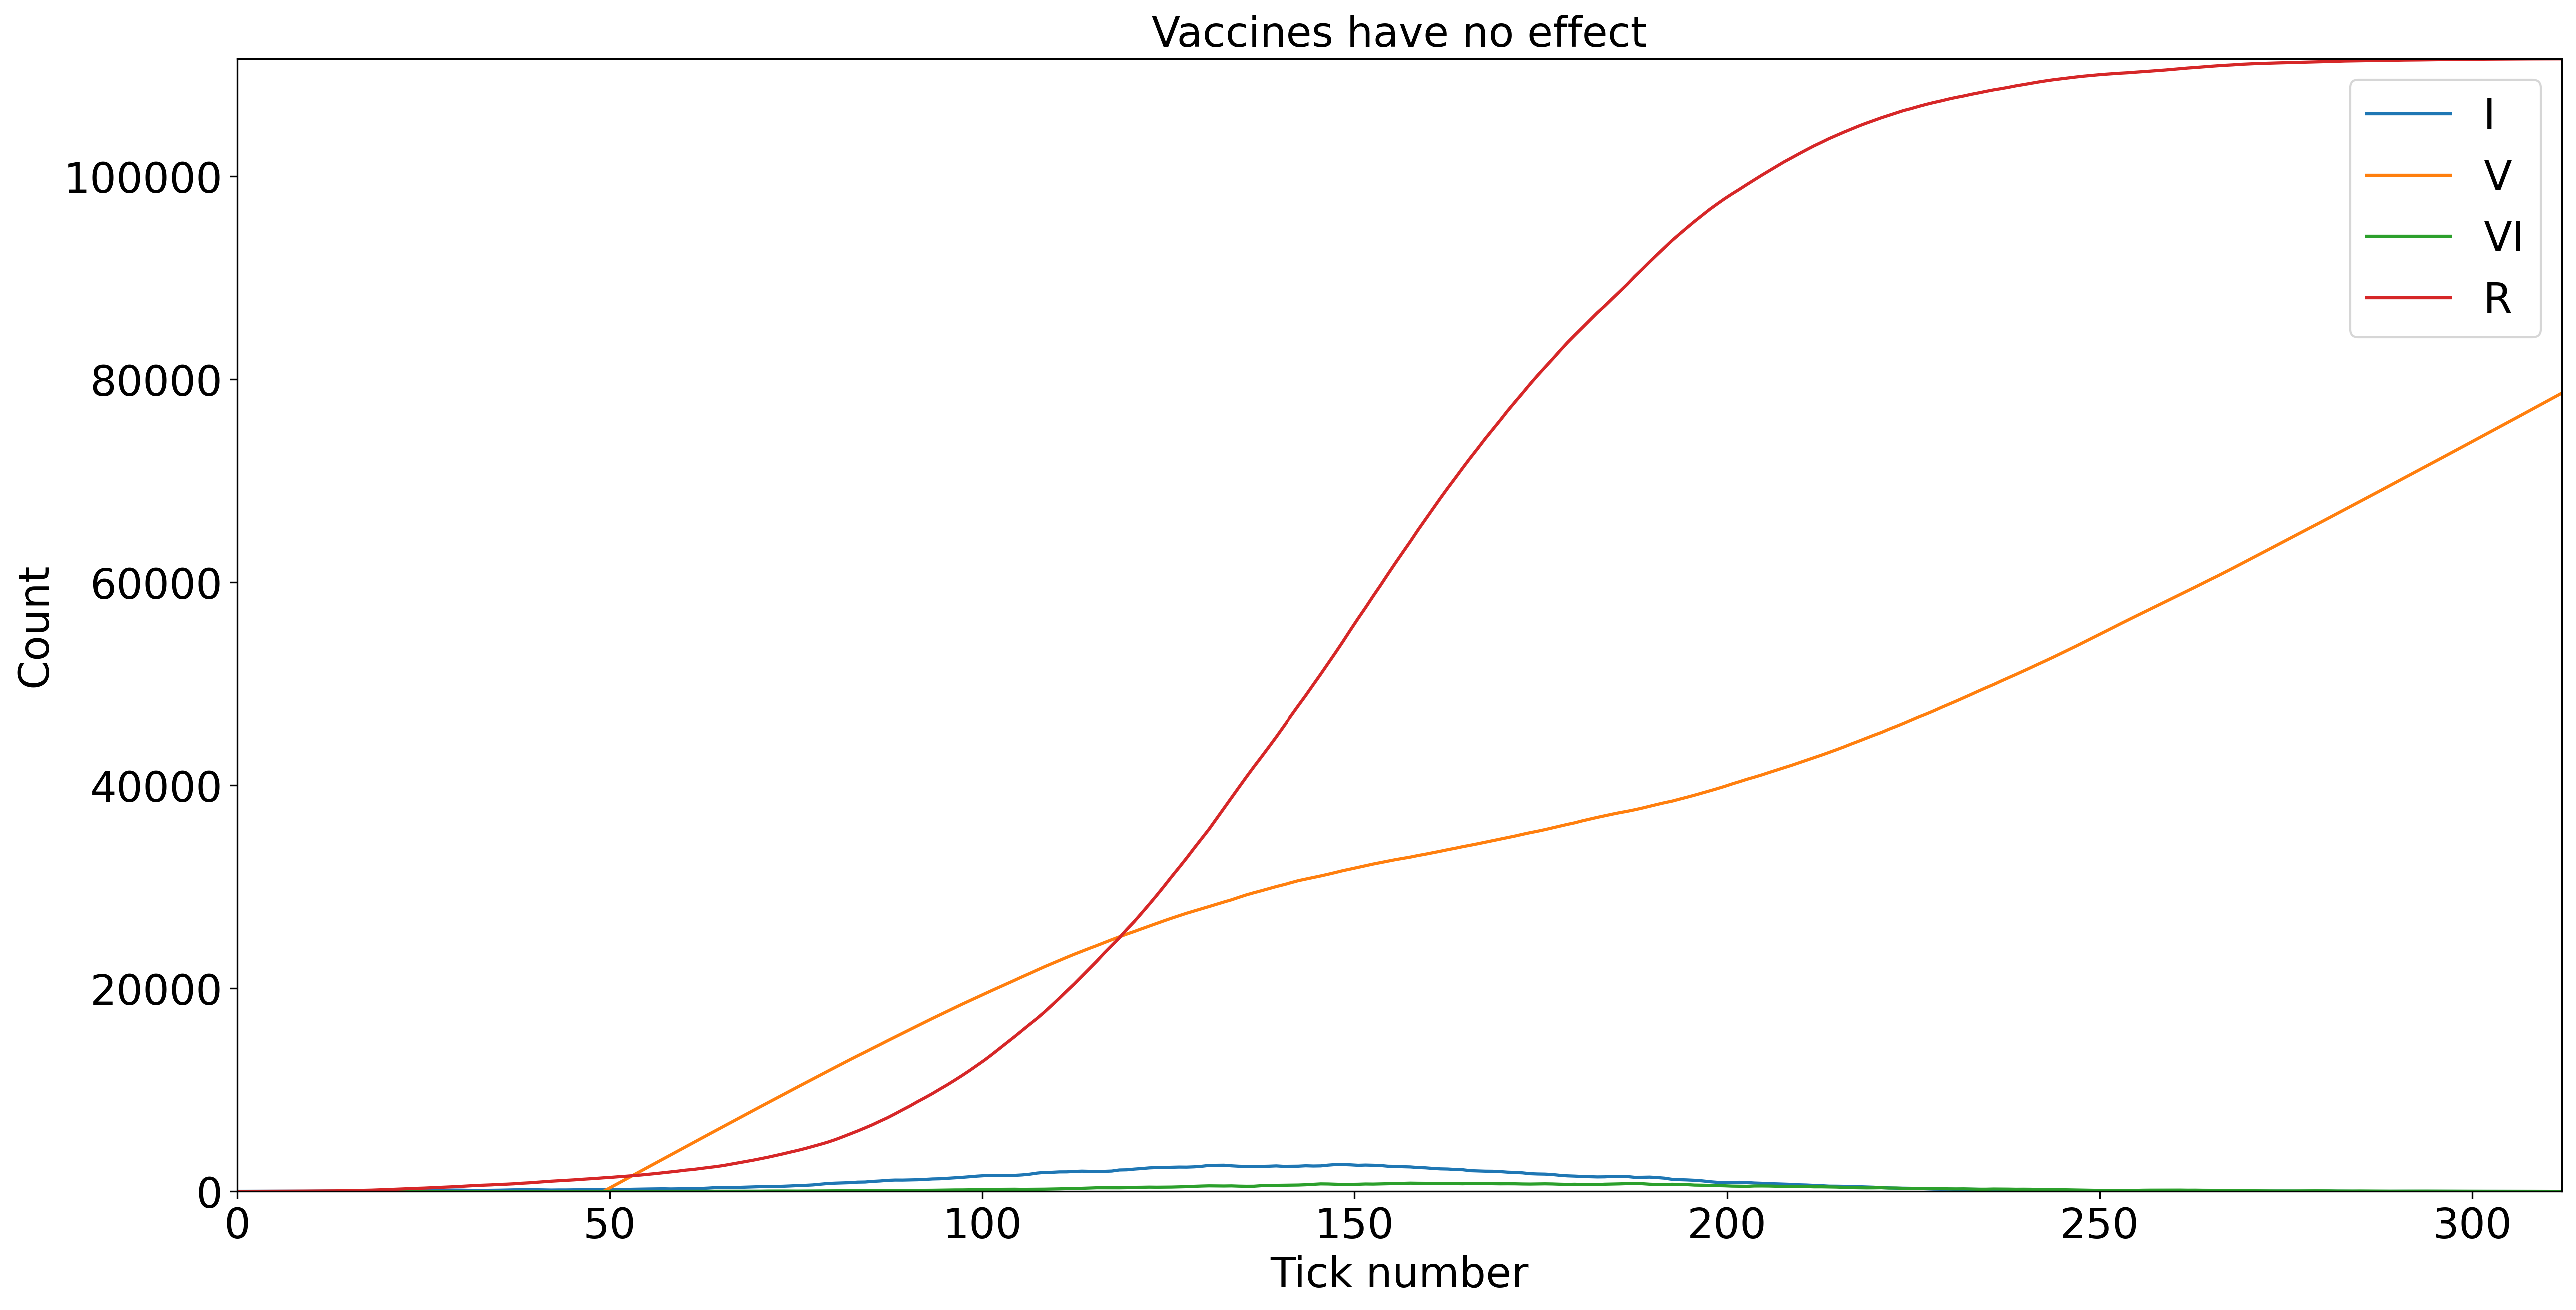

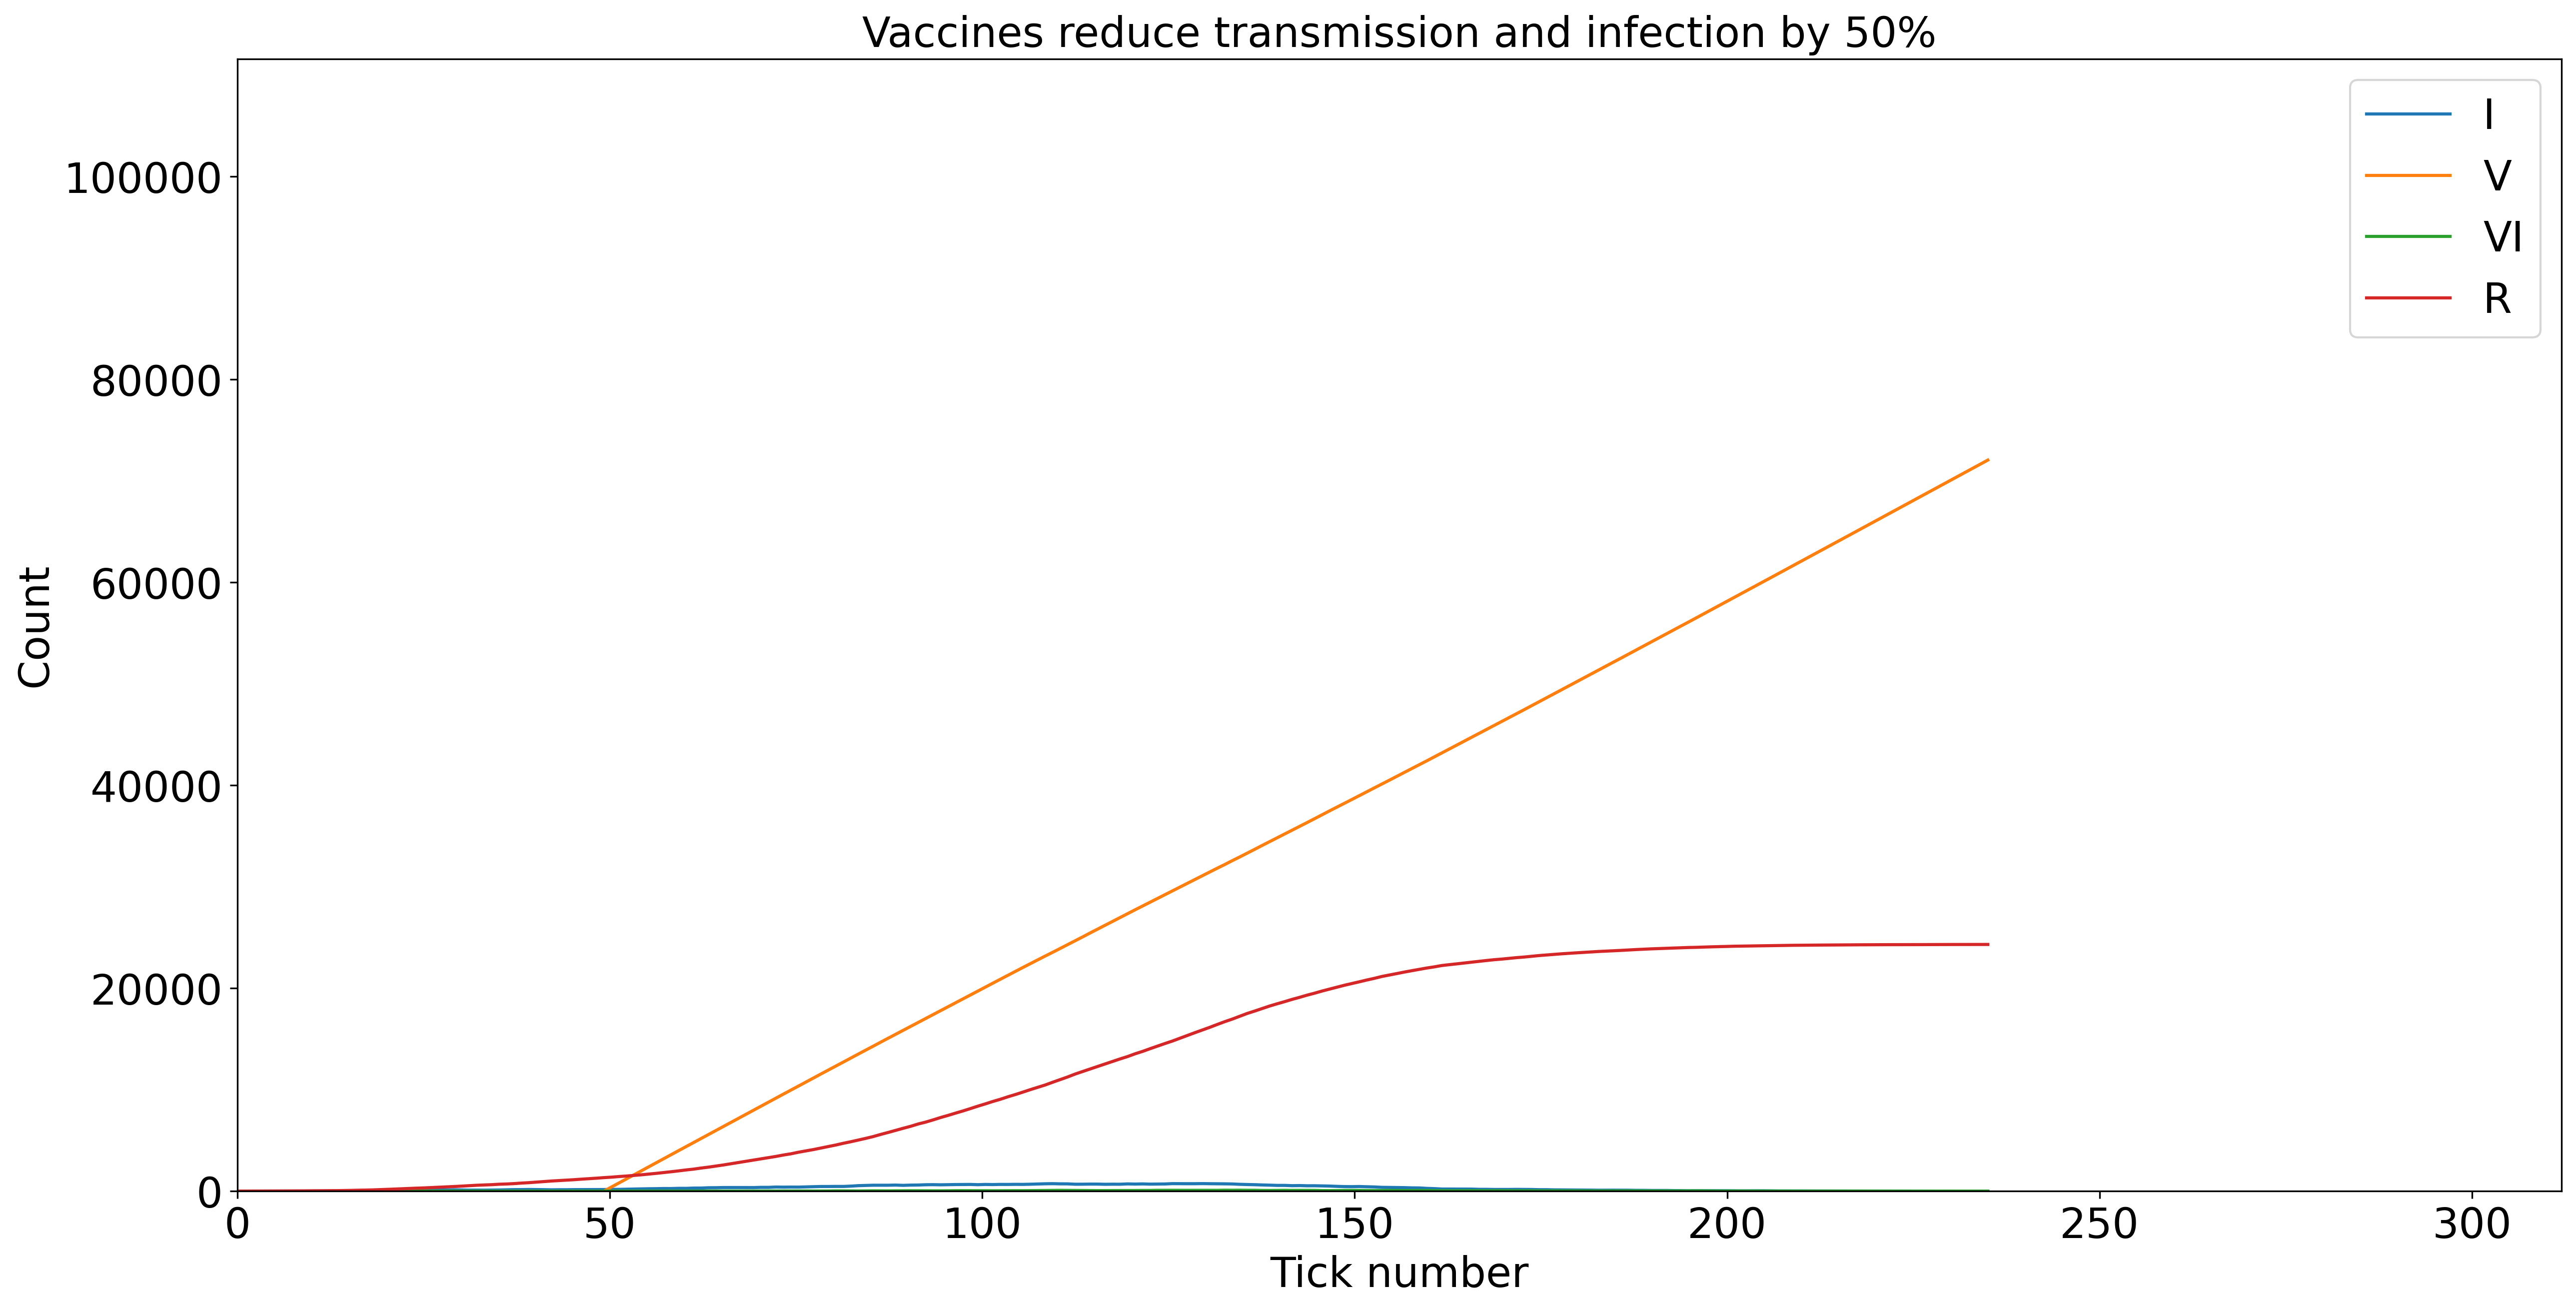

In [10]:
max_x = max(len(ep_model_1_results[0]), len(ep_model_2_results[0]))
max_y = max(sum(ep_model_1_results[1:], []) + sum(ep_model_2_results[1:], []))
plot_epidemic_model_results(ep_model_1_results, "Vaccines have no effect", max_x=max_x, max_y=max_y)
plot_epidemic_model_results(ep_model_2_results, "Vaccines reduce transmission and infection by 50%", max_x=max_x,
                            max_y=max_y)

From this, we conclude that vaccinations that reduce transmission and infection by half significantly reduces the spread of the disease. We now run the model when only

- (3) the transmission probability from an infected person to a vaccinated person is reduced by 50%; and
- (4) the transmission probability from a vaccinated person to an unvaccinated susceptible person is reduced by 50%.

In [11]:
random.seed(69420)
ep_model_3 = EpidemicModel(vdws_network, infection_length=3, piv=0.005, pviv=0.005)
ep_model_3_results = run_model(ep_model_3, tick_count=500)

Model ended with the following state distribution.
S         I         V         VI        R         
78803     0         82981     0         38216     
Total tick count: 267


In [12]:
random.seed(69420)
ep_model_4 = EpidemicModel(vdws_network, infection_length=3, pviv=0.005, pvis=0.005)
ep_model_4_results = run_model(ep_model_4, tick_count=500)

Model ended with the following state distribution.
S         I         V         VI        R         
62963     0         87877     0         49160     
Total tick count: 290


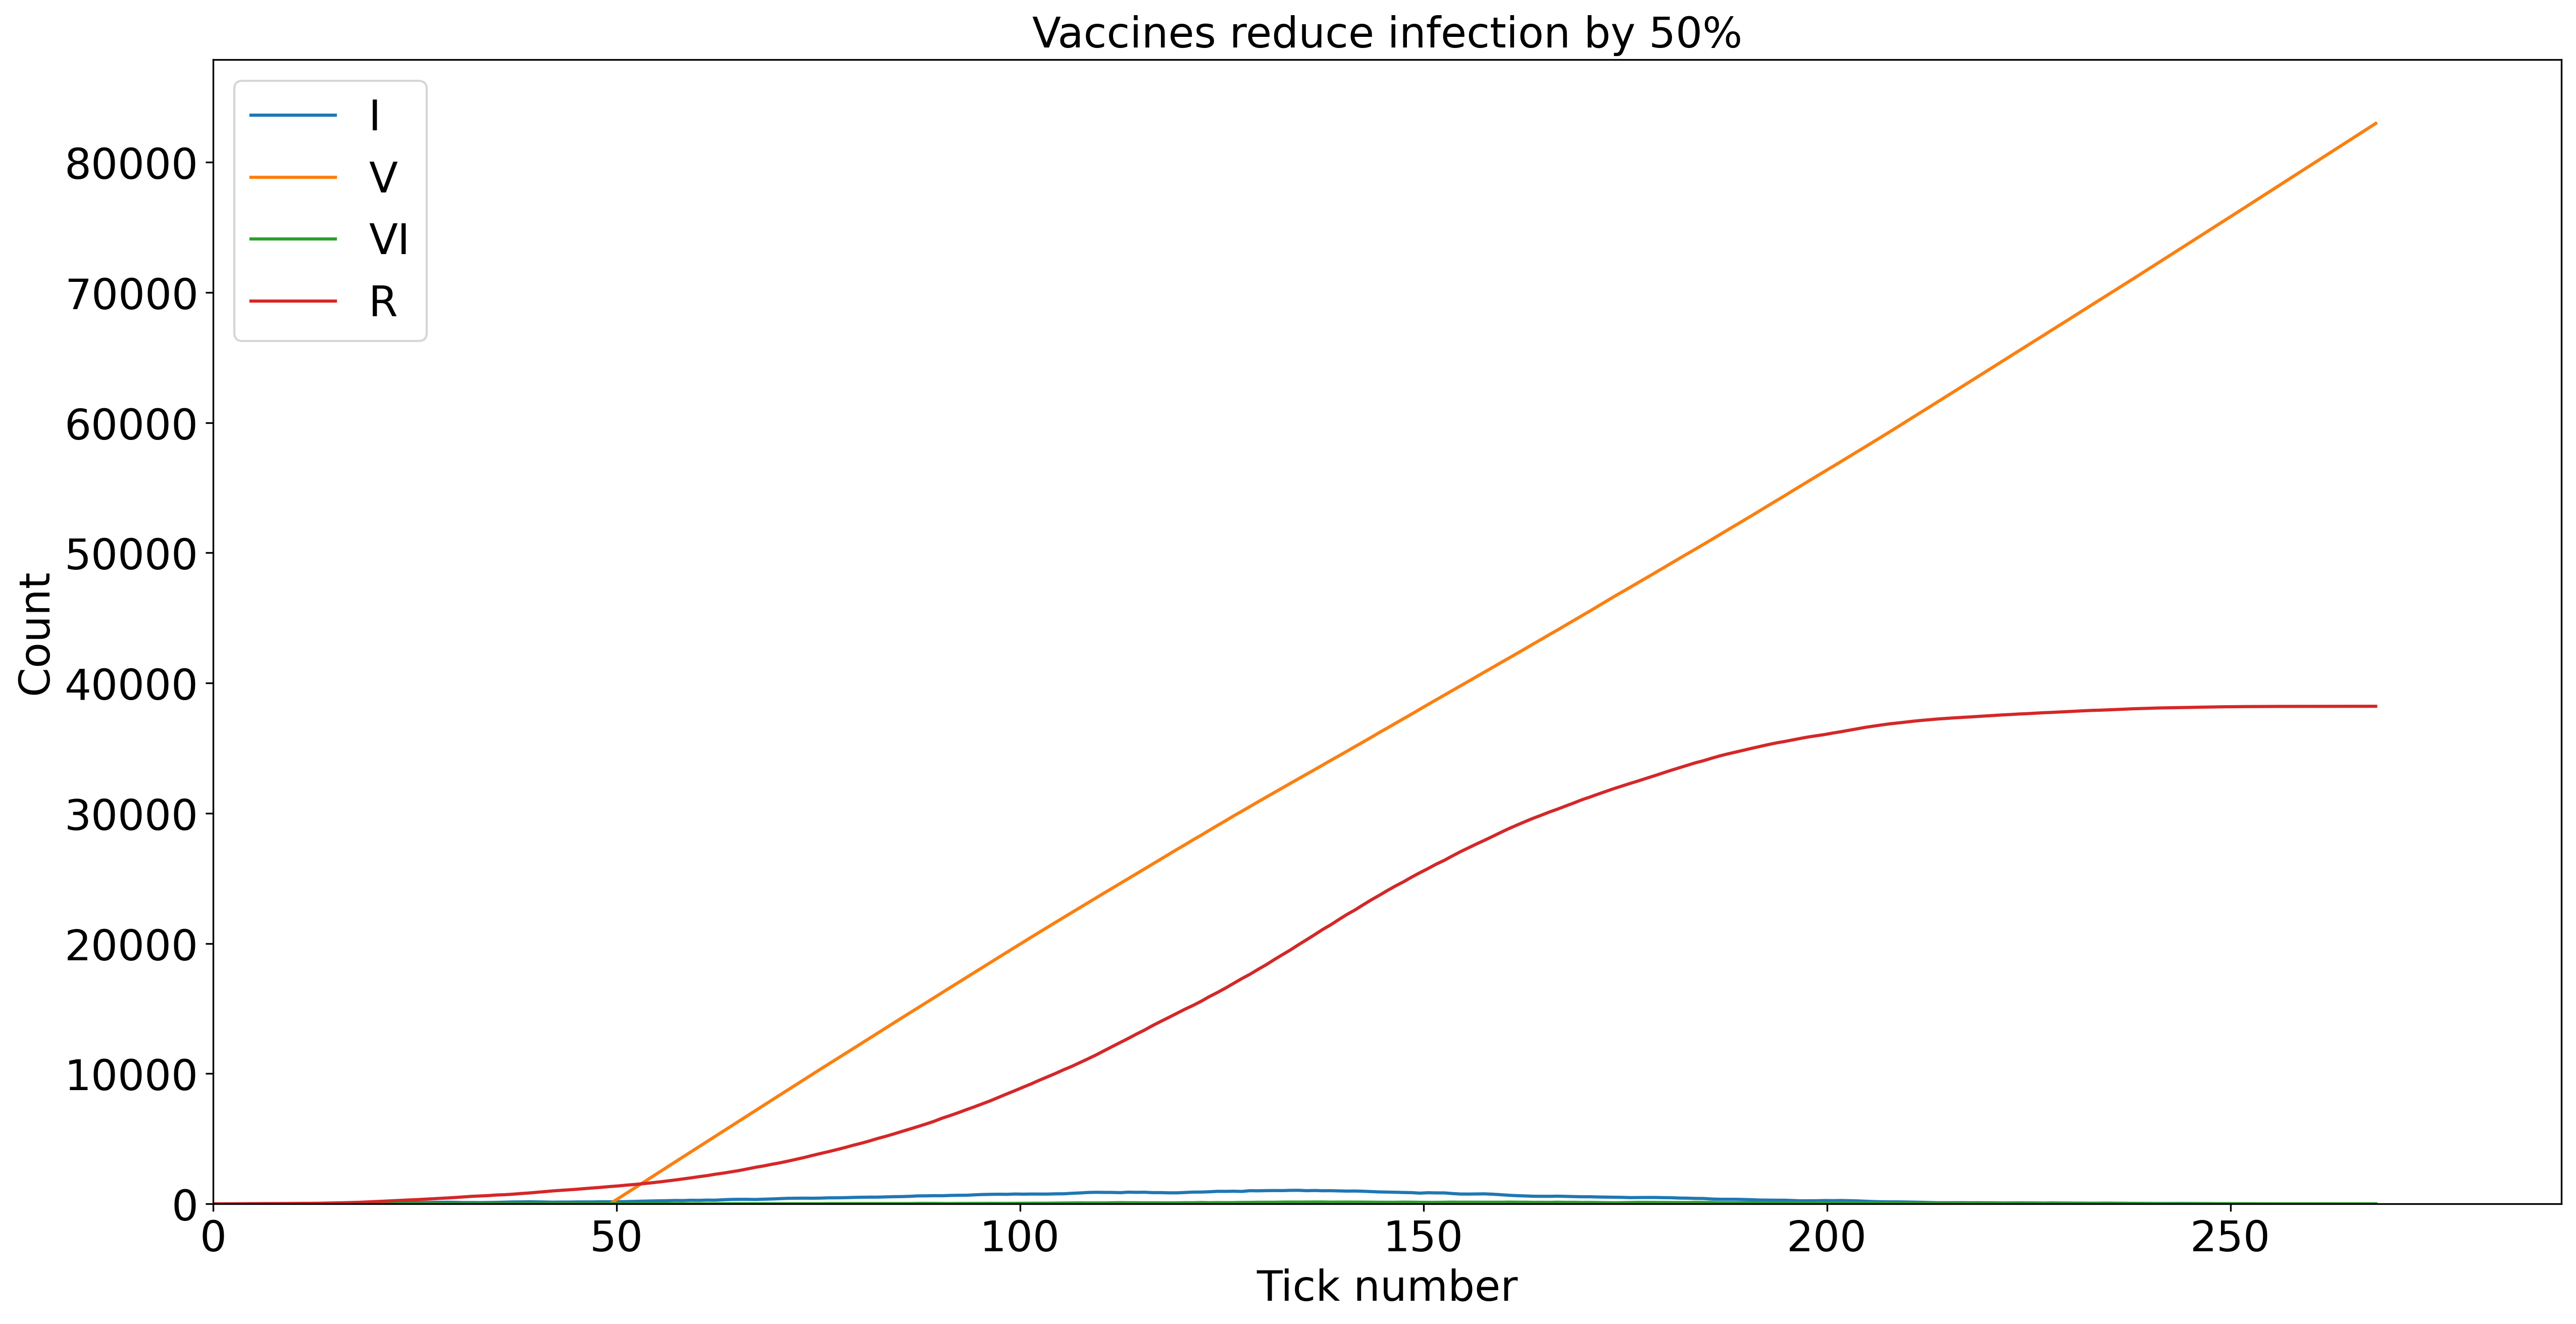

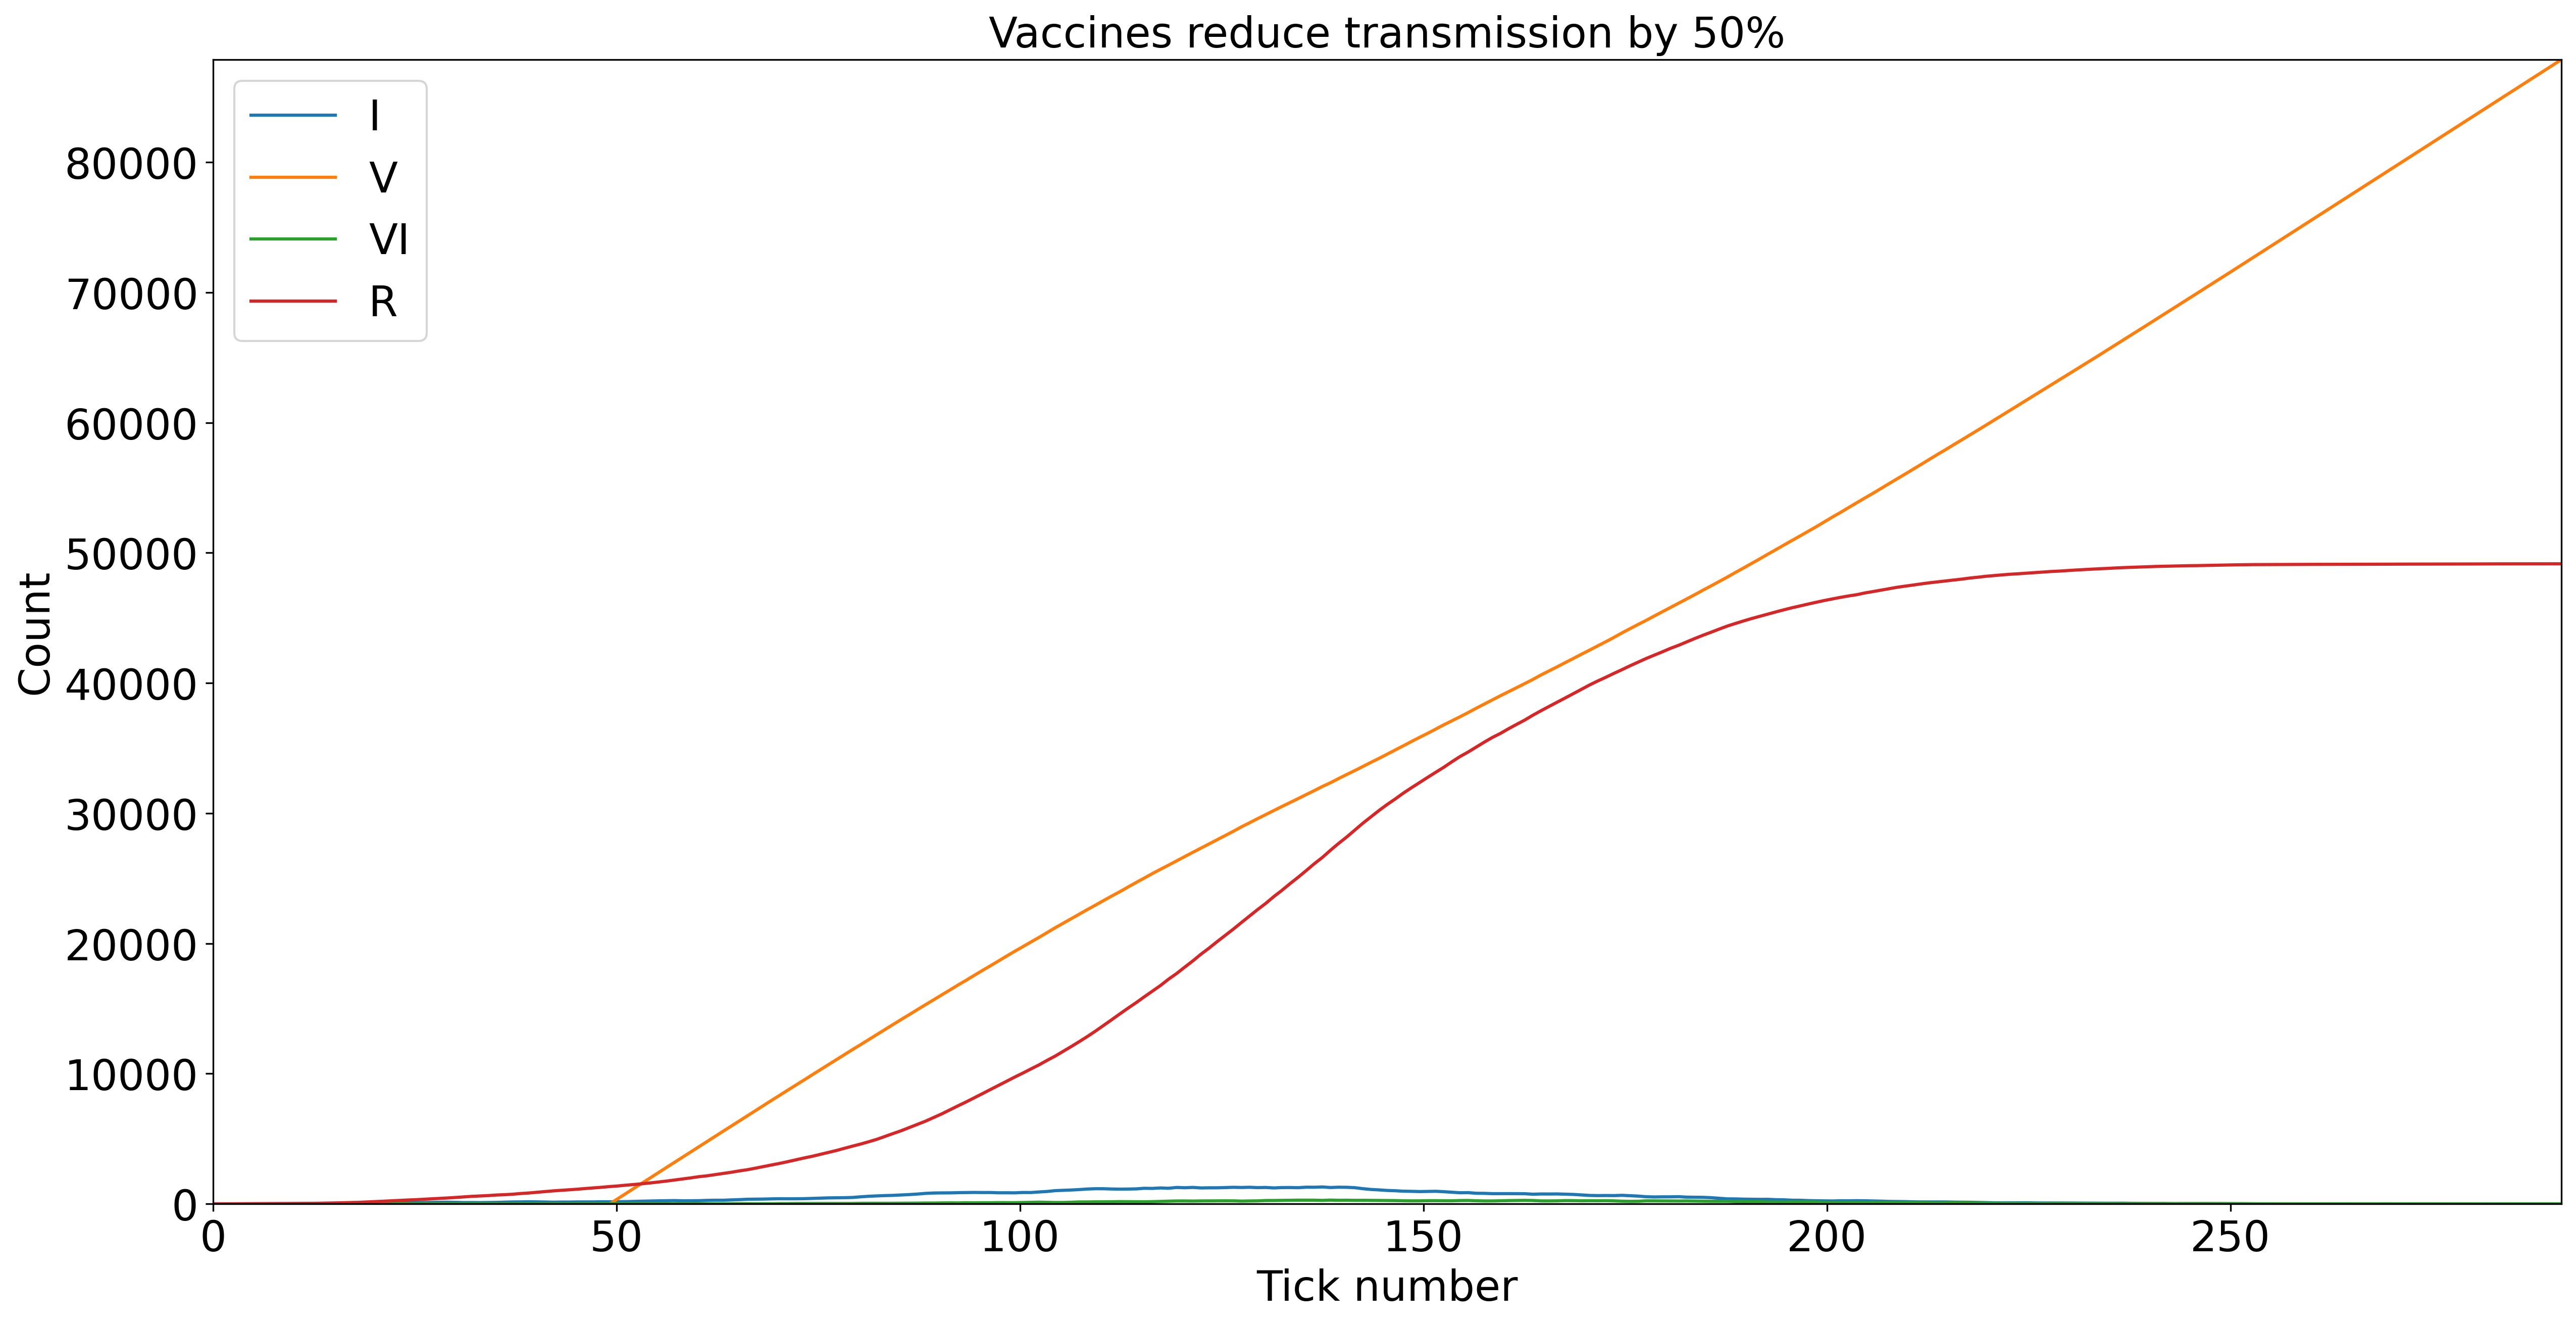

In [13]:
max_x = max(len(ep_model_3_results[0]), len(ep_model_4_results[0]))
max_y = max(sum(ep_model_3_results[1:], []) + sum(ep_model_4_results[1:], []))
plot_epidemic_model_results(ep_model_3_results, "Vaccines reduce infection by 50%", max_x=max_x, max_y=max_y)
plot_epidemic_model_results(ep_model_4_results, "Vaccines reduce transmission by 50%", max_x=max_x, max_y=max_y)

First, we comment that although the peak of infections for (3) and (4) looks lesser than that of that for (2), this is just because of the difference in the limits of the y-axes. Based on the results, the following is the ranking of the efficacy of the vaccines.

* (2)
* (3)
* (4)
* (1)

As expected, vaccines have the highest efficacy when they reduce both transmission and infection. When only one may be picked, a decrease in infection seems to decrease the total infected more so then a decrease in transmission. The length of the epidemics seem relatively consistent over all of the models.

# Question 2
2. *[25 marks] Repeat the simulations of the previous question, but with the single change that the 400 vertices moved from S to V at each time step (after $t=50$) can be strategically chosen (rather than being chosen at random).  Propose and test three different strategies and comment on their effectiveness. \
With the values given, each simulation should require no more than 400 time steps (before the infection dies out).  You should be able to run this in a few minutes on your own computer (or any university PC).  If you find that with the values I have given, the simulations take too long, then choose alternative values and document this in your submission.*

We first reuse the code for calculating centrality measures from the last assignment.

In [14]:
class CentralityMeasures:
    def __dc(self, node: int) -> int:
        return len(self.network[node])

    def dc(self, node: int) -> int:
        return self.__dcs[node]

    def __ac(self, node: int) -> float:
        total = 0
        for neighbour in self.network[node]:
            total += (self.dc(node) - self.dc(neighbour)) / (self.dc(node) + self.dc(neighbour))
        total /= len(self.network[node])
        return total

    def ac(self, node: int) -> float:
        return self.__acs[node]

    def __init__(self, network: Dict[int, list[int]]):
        self.network = network
        self.__dcs = dict()
        for node in self.network:
            self.__dcs[node] = self.__dc(node)
        self.__acs = dict()
        debug_period = len(self.network) // 160
        for node in self.network:
            if node % debug_period == 0:
                print_status_bar(node / len(self.network), block_count=80)
                print("Calculating adjacency centralities.")
                print(f"{node + 1}/{len(self.network)}")
            self.__acs[node] = self.__ac(node)

    def get_nodes_sorted_by_dc(self) -> list[int]:
        nodes = list(self.network.keys())
        return sorted(nodes, key=lambda k: self.dc(k), reverse=True)

    def get_nodes_sorted_by_ac(self) -> list[int]:
        nodes = list(self.network.keys())
        return sorted(nodes, key=lambda k: self.ac(k), reverse=True)

    def get_nodes_sorted_by_average_dc_ac(self) -> list[int]:
        max_dc = max(self.network, key=lambda k: abs(self.dc(k)))
        nodes = list(self.network.keys())
        return sorted(nodes, key=lambda k: ((self.dc(k) / max_dc) + self.ac(k))/2, reverse=True)

In [15]:
vdws_network_measures = CentralityMeasures(vdws_network)
clear_output(wait=True)
print("Degree centralities and adjacency centralities calculated for vdws_network.")

Degree centralities and adjacency centralities calculated for vdws_network.


In [16]:
random.seed(69420)
strategic_model_1 = EpidemicModel(vdws_network, infection_length=3, piv=0.005, pvis=0.005, pviv=0.0025,
                                  vaccination_priority=vdws_network_measures.get_nodes_sorted_by_dc())
strategic_model_1_results = run_model(strategic_model_1, tick_count=500)
print_model_end(strategic_model_1)

Model ended with the following state distribution.
S         I         V         VI        R         
129192    0         61902     0         8906      
Total tick count: 205


In [17]:
random.seed(69420)
strategic_model_2 = EpidemicModel(vdws_network, infection_length=3, piv=0.005, pvis=0.005, pviv=0.0025,
                                  vaccination_priority=vdws_network_measures.get_nodes_sorted_by_ac())
strategic_model_2_results = run_model(strategic_model_2, tick_count=500)
print_model_end(strategic_model_2)

Model ended with the following state distribution.
S         I         V         VI        R         
139015    0         52331     0         8654      
Total tick count: 181


In [18]:
random.seed(69420)
strategic_model_3 = EpidemicModel(vdws_network, infection_length=3, piv=0.005, pvis=0.005, pviv=0.0025,
                                  vaccination_priority=vdws_network_measures.get_nodes_sorted_by_average_dc_ac())
strategic_model_3_results = run_model(strategic_model_3, tick_count=500)
print_model_end(strategic_model_3)

Model ended with the following state distribution.
S         I         V         VI        R         
139015    0         52331     0         8654      
Total tick count: 181


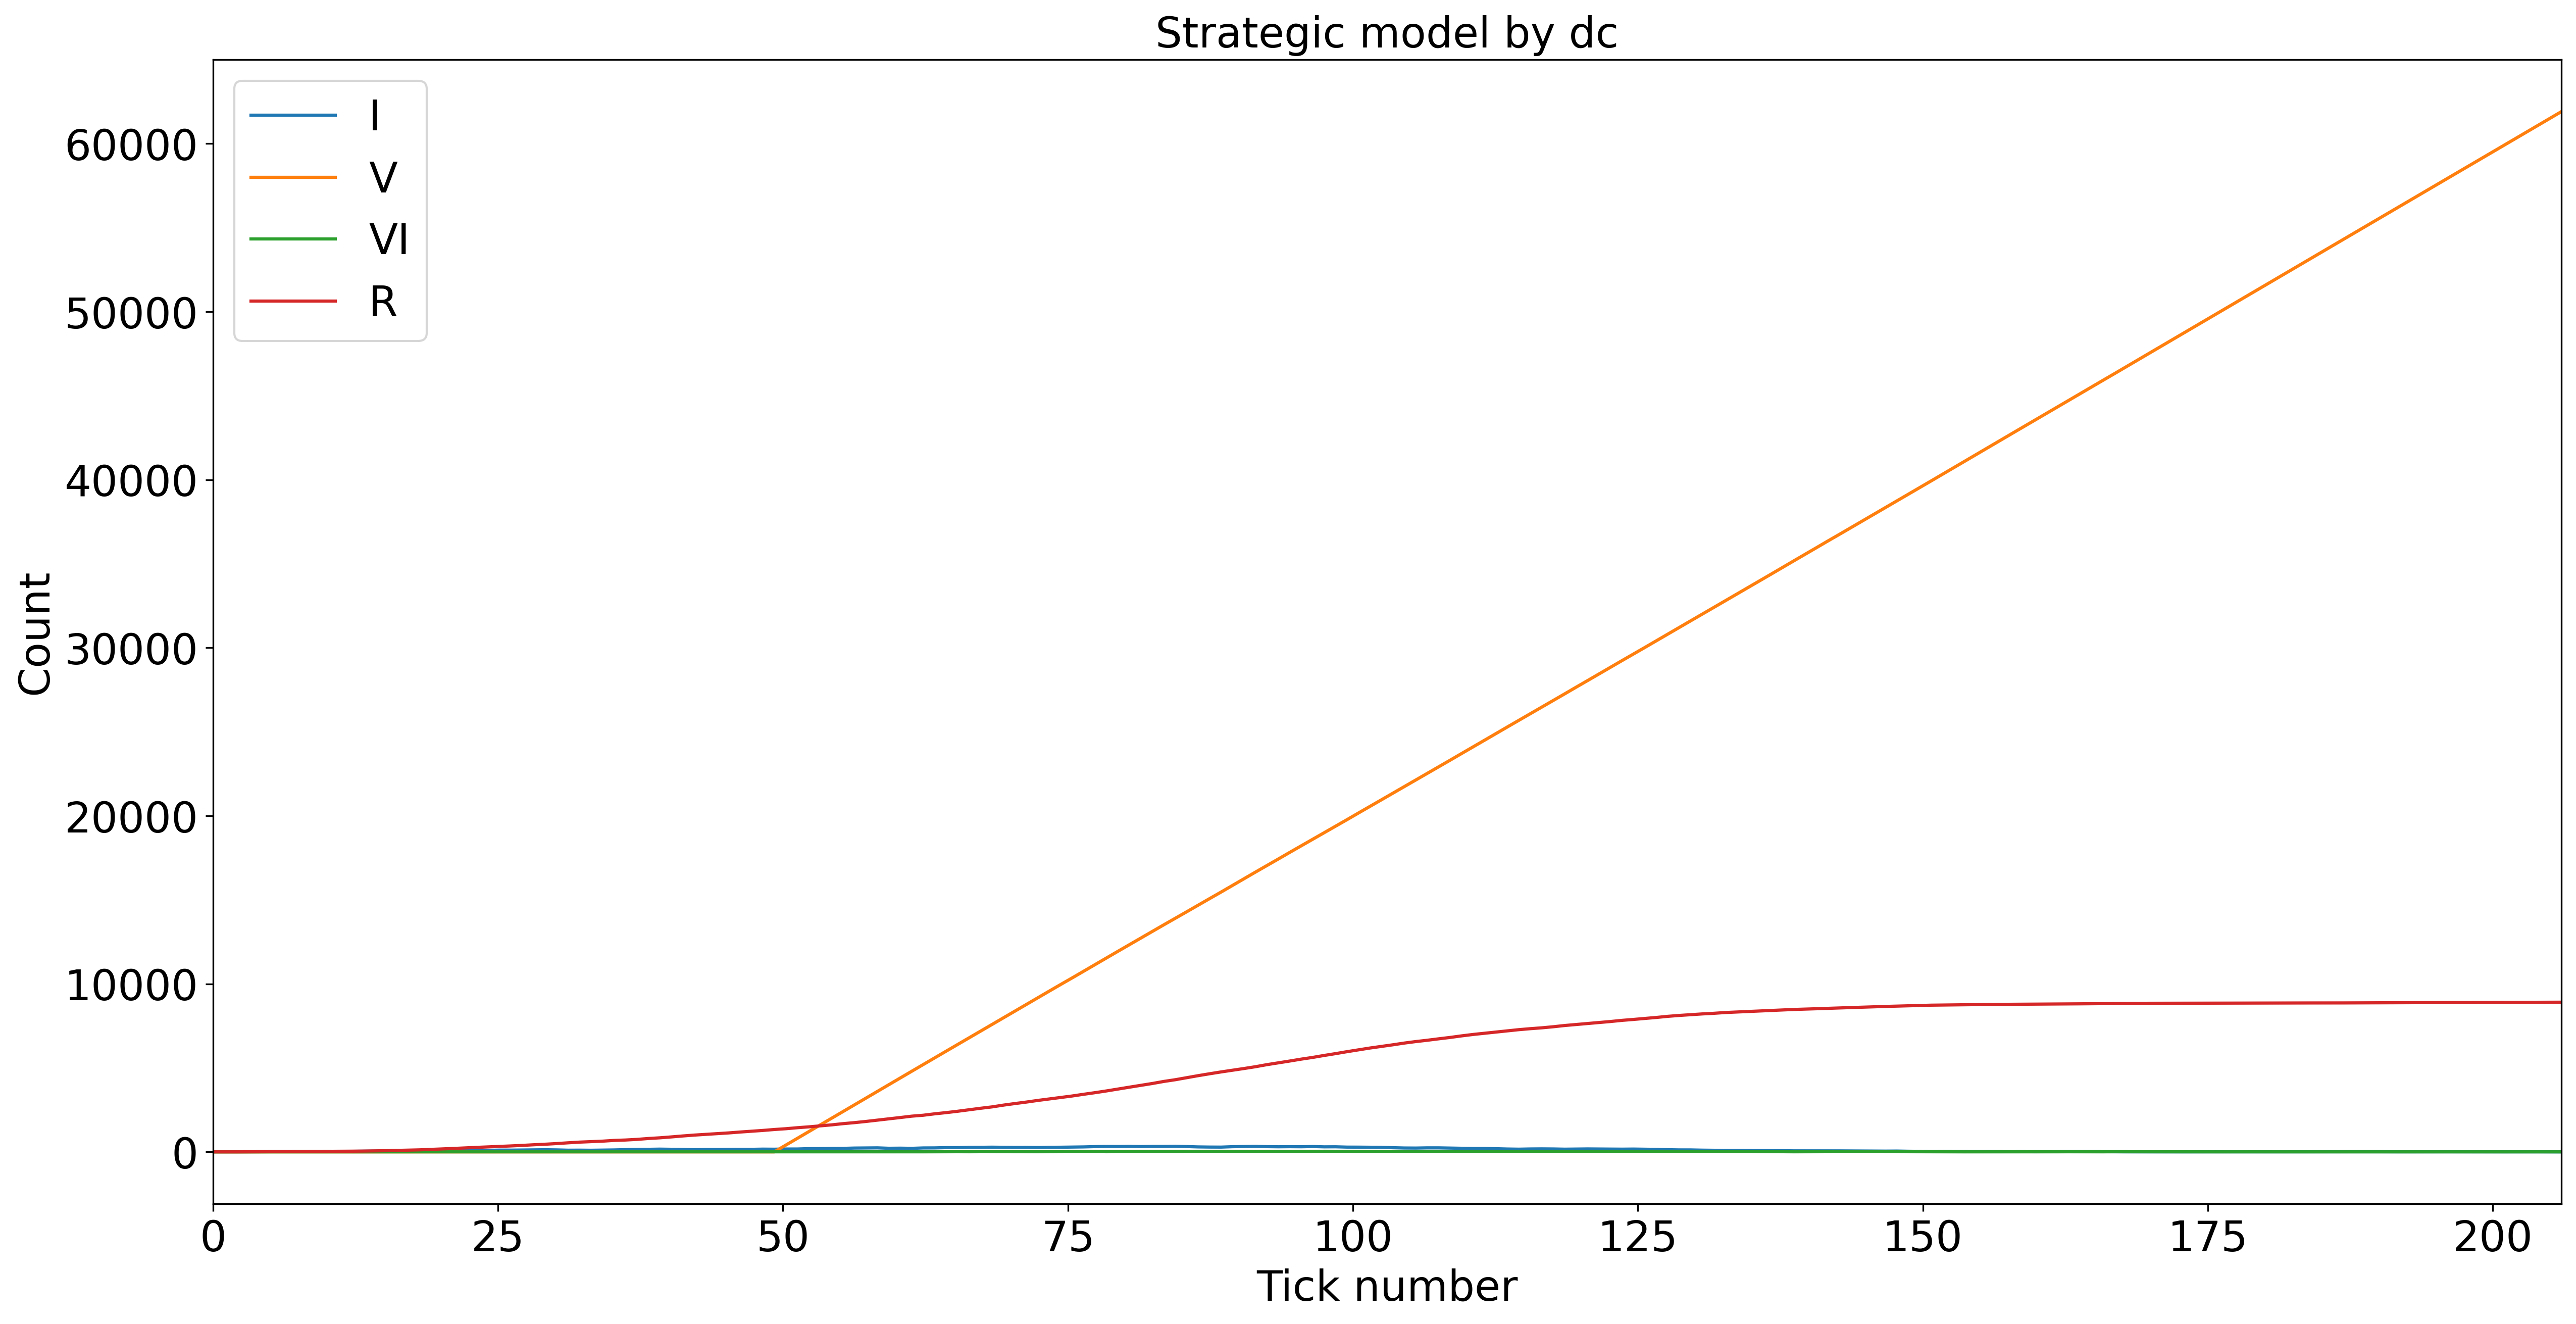

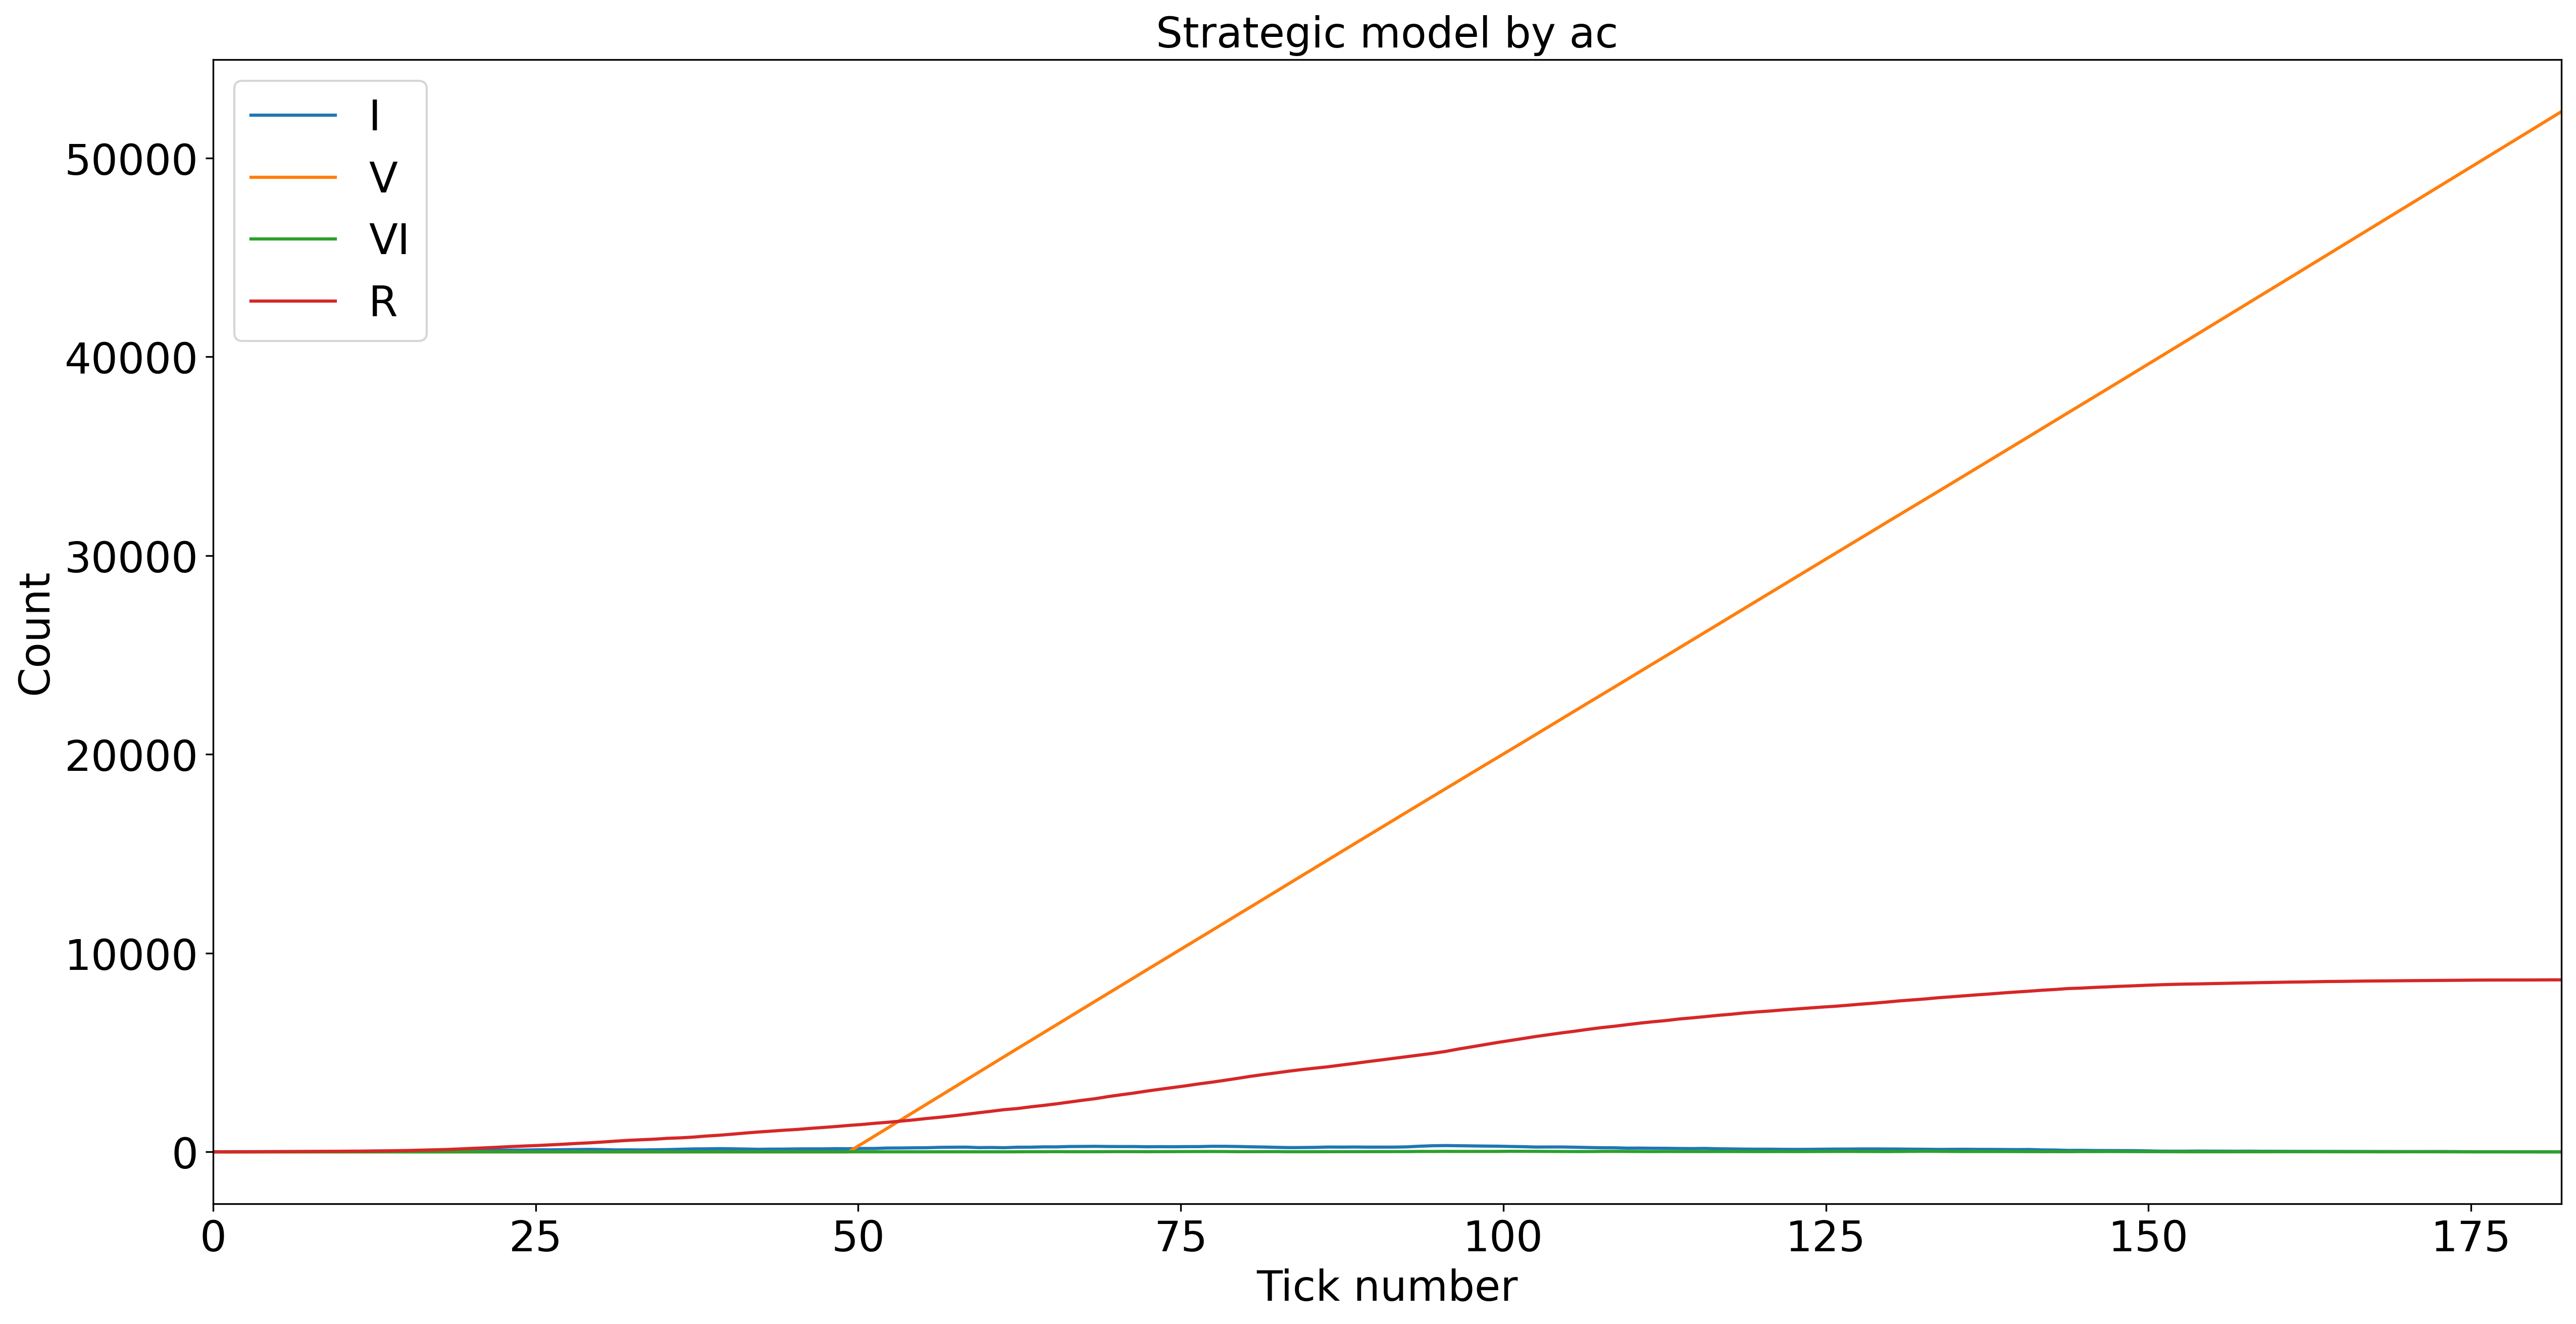

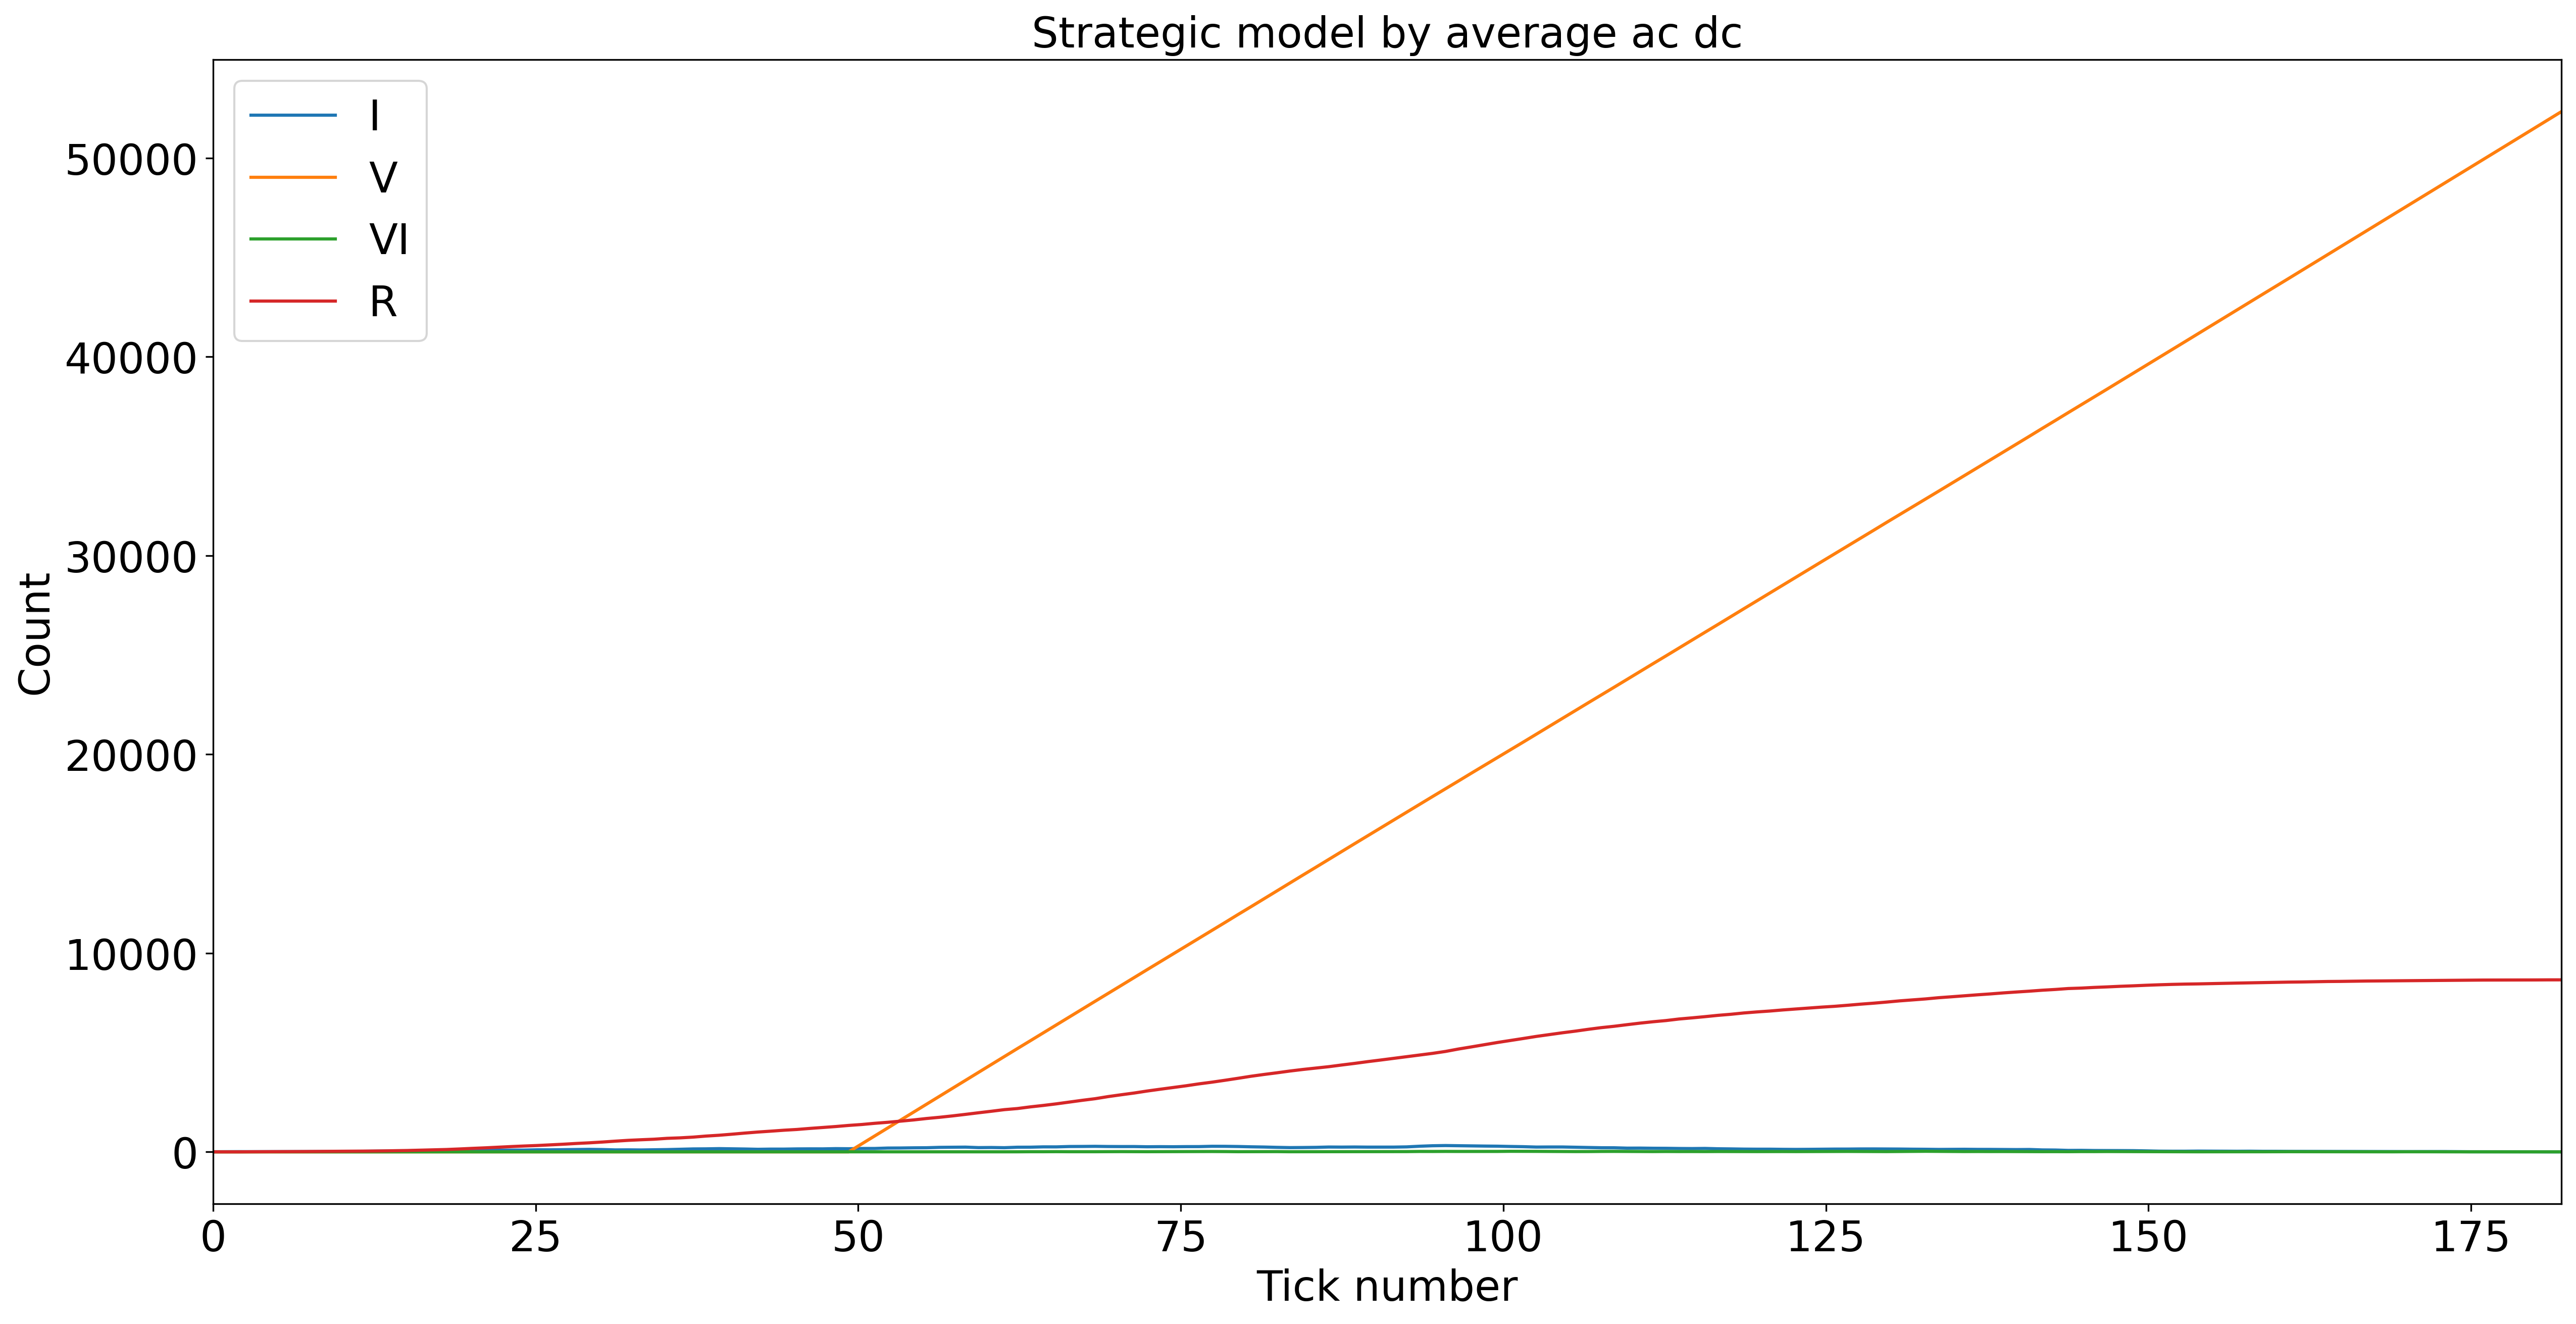

In [19]:
plot_epidemic_model_results(strategic_model_1_results, "Strategic model by dc")
plot_epidemic_model_results(strategic_model_2_results, "Strategic model by ac")
plot_epidemic_model_results(strategic_model_3_results, "Strategic model by average ac dc")

We have seen some expected runs, now lets examine all 16 possible scenarios (varying vaccination strategy, and how the vaccine affects the transmission and infection rates).

In [20]:
models = dict()
model_text_outputs = dict()

vaccination_strategy = ["no strategy", "strategy dc", "strategy ac", "strategy average dc ac"]
vaccination_priorities = {
    "no strategy": None,
    "strategy dc": vdws_network_measures.get_nodes_sorted_by_dc(),
    "strategy ac": vdws_network_measures.get_nodes_sorted_by_ac(),
    "strategy average dc ac": vdws_network_measures.get_nodes_sorted_by_average_dc_ac()
}
vaccine_effects = ["no effect", "reduce transmission", "reduce infection", "reduce both"]
vaccine_effect_probabilities = {
    "no effect": {
        "pis": 0.01,
        "piv": 0.01,
        "pvis": 0.01,
        "pviv": 0.01
    },
    "reduce transmission": {
        "pis": 0.01,
        "piv": 0.01,
        "pvis": 0.005,
        "pviv": 0.005
    },
    "reduce infection": {
        "pis": 0.01,
        "piv": 0.005,
        "pvis": 0.01,
        "pviv": 0.005
    },
    "reduce both": {
        "pis": 0.01,
        "piv": 0.005,
        "pvis": 0.005,
        "pviv": 0.0025
    }
}

count = 0
for vaccine_strategy in vaccination_strategy:
    models[vaccine_strategy] = dict()
    model_text_outputs[vaccine_strategy] = dict()
    for vaccine_effect in vaccine_effects:
        print_status_bar(count / 15, block_count=80)
        print(f"Running model {count}/16")

        vaccine_priority = vaccination_priorities[vaccine_strategy]
        if vaccine_priority is not None:
            vaccine_priority = vaccine_priority.copy()

        pis = vaccine_effect_probabilities[vaccine_effect]["pis"]
        piv = vaccine_effect_probabilities[vaccine_effect]["piv"]
        pvis = vaccine_effect_probabilities[vaccine_effect]["pvis"]
        pviv = vaccine_effect_probabilities[vaccine_effect]["pviv"]
        random.seed(69420)
        model = EpidemicModel(vdws_network, infection_length=3, pis=pis, piv=piv, pvis=pvis, pviv=pviv,
                              vaccination_priority=vaccine_priority)
        model_results = run_model(model, tick_count=500, quiet=True)
        models[vaccine_strategy][vaccine_effect] = model_results
        model_text_outputs[vaccine_strategy][vaccine_effect] = get_model_end_text(model)

        count += 1

clear_output(wait=True)
print(f"16 instances of the model has been run.")

16 instances of the model has been run.


In [21]:
vaccination_strategy = ["no strategy", "strategy dc", "strategy ac", "strategy average dc ac"]
vaccine_effects = ["no effect", "reduce transmission", "reduce infection", "reduce both"]
for vaccine_strategy in vaccination_strategy:
    for vaccine_effect in vaccine_effects:
        print(f"Strategy: {vaccine_strategy}")
        print(f"Vaccine effect: {vaccine_effect}")
        print(model_text_outputs[vaccine_strategy][vaccine_effect])
        print()

Strategy: no strategy
Vaccine effect: no effect
Model ended with the following state distribution.
S         I         V         VI        R         
9822      0         78620     0         111558    
Total tick count: 311

Strategy: no strategy
Vaccine effect: reduce transmission
Model ended with the following state distribution.
S         I         V         VI        R         
62963     0         87877     0         49160     
Total tick count: 290

Strategy: no strategy
Vaccine effect: reduce infection
Model ended with the following state distribution.
S         I         V         VI        R         
78803     0         82981     0         38216     
Total tick count: 267

Strategy: no strategy
Vaccine effect: reduce both
Model ended with the following state distribution.
S         I         V         VI        R         
103652    0         72040     0         24308     
Total tick count: 234

Strategy: strategy dc
Vaccine effect: no effect
Model ended with the following state 

## Strategy motivation

In our model, an effective vaccination strategy is one that reduces the total infected count. We claim that such a strategy will look at the *connectedness* of each node, and aims to vaccinate the nodes that are highly likely to infect many other nodes. We note that every tick an infected node will have a probability of infecting one of its neighbours.

## Strategy description

We introduce our three strategies.

* (1) Vaccinate by the degree centrality of a susceptible node.
* (2) Vaccinate by the adjacency centrality of a susceptible node.
* (3) Vaccinate by the average of the degree centrality and adjacency centrality (to do this we normalize degree centrality to the range $[-1,1]$).

## Strategy justification

We claim that degree centrality gives a robust notion of secondary infections for a given node, but this does not paint the full picture of how an infection propagates throughout a network. Adjacency centrality gives us a notion of popularity in context to the popularity of the neighbours of a node. Nodes with a high adjacency centrality (so called *hubs*) give a vehicle for the infection to reach small communities that it may not otherwise reach. Although the subtle differences between these measures, they are both similar measures.

## Strategy analysis

From the above model outputs, we first see that strategy (2) and (3) are equivalent. Aside from this, we see that strategically vaccinating on any of these strategies, for all non-trivial effects of the vaccine, we see a reduction in the total infected count. Comparing strategy (1) and (2)/(3), we see that vaccinating by degree centrality is more effective when only one of transmission and infection is reduced, but when both are reduced then vaccinating by adjacency centrality has a slightly higher efficacy.

There is also a comparison to be made on the length of the epidemics: models in which the vaccine has an effect typically lowers the length of the epidemic. We also see that although vaccinating by degree centrality decrease the total infected, it leads to (on average) a longer epidemic.

We conclude that the choice of measure to determine strategy is dependent on the characteristics of the vaccine. If the vaccine only reduces either transmission or infection, then degree centrality is the superior measure. If the vaccine reduces both transmission and infection, then adjacency centrality is the superior measure. Picking a measure to decrease epidemic length is inapt, the length of the epidemic is characterised by the characteristics of the vaccine more than the choice of individual to vaccinate (in the strategies outlined above).

## Strategy plots

Below find the plots that was used in conjunction with the model outputs for the commentary above.

Strategy: no strategy
Vaccine effect: no effect


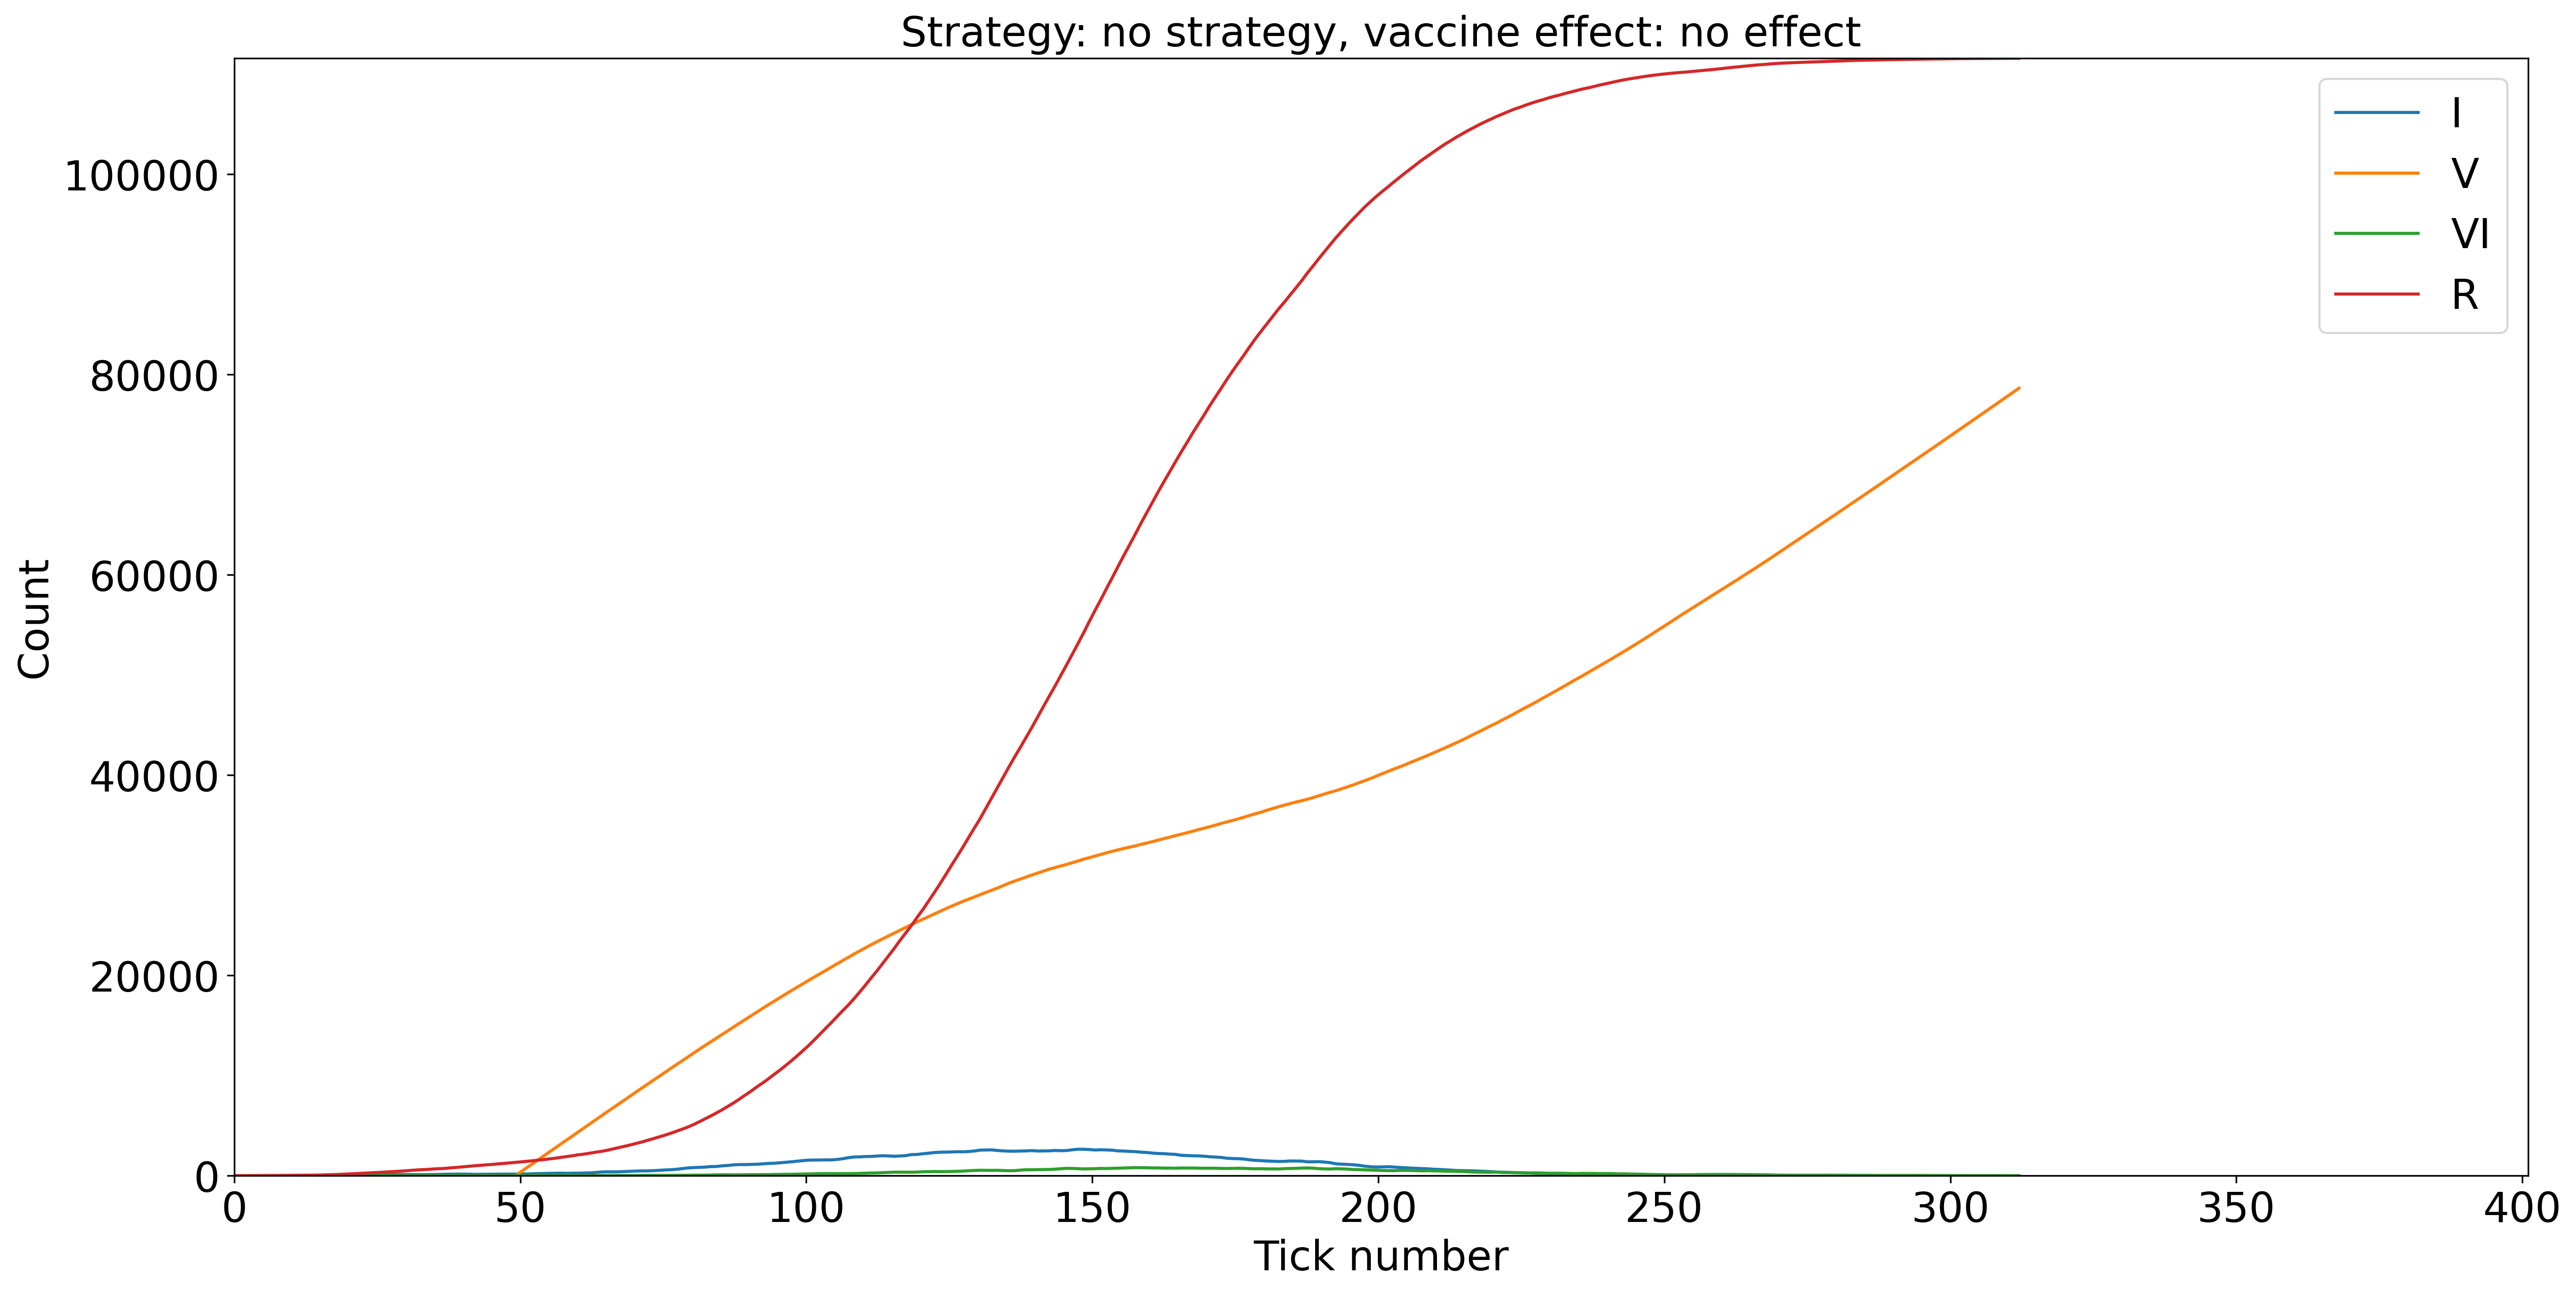

Strategy: no strategy
Vaccine effect: reduce transmission


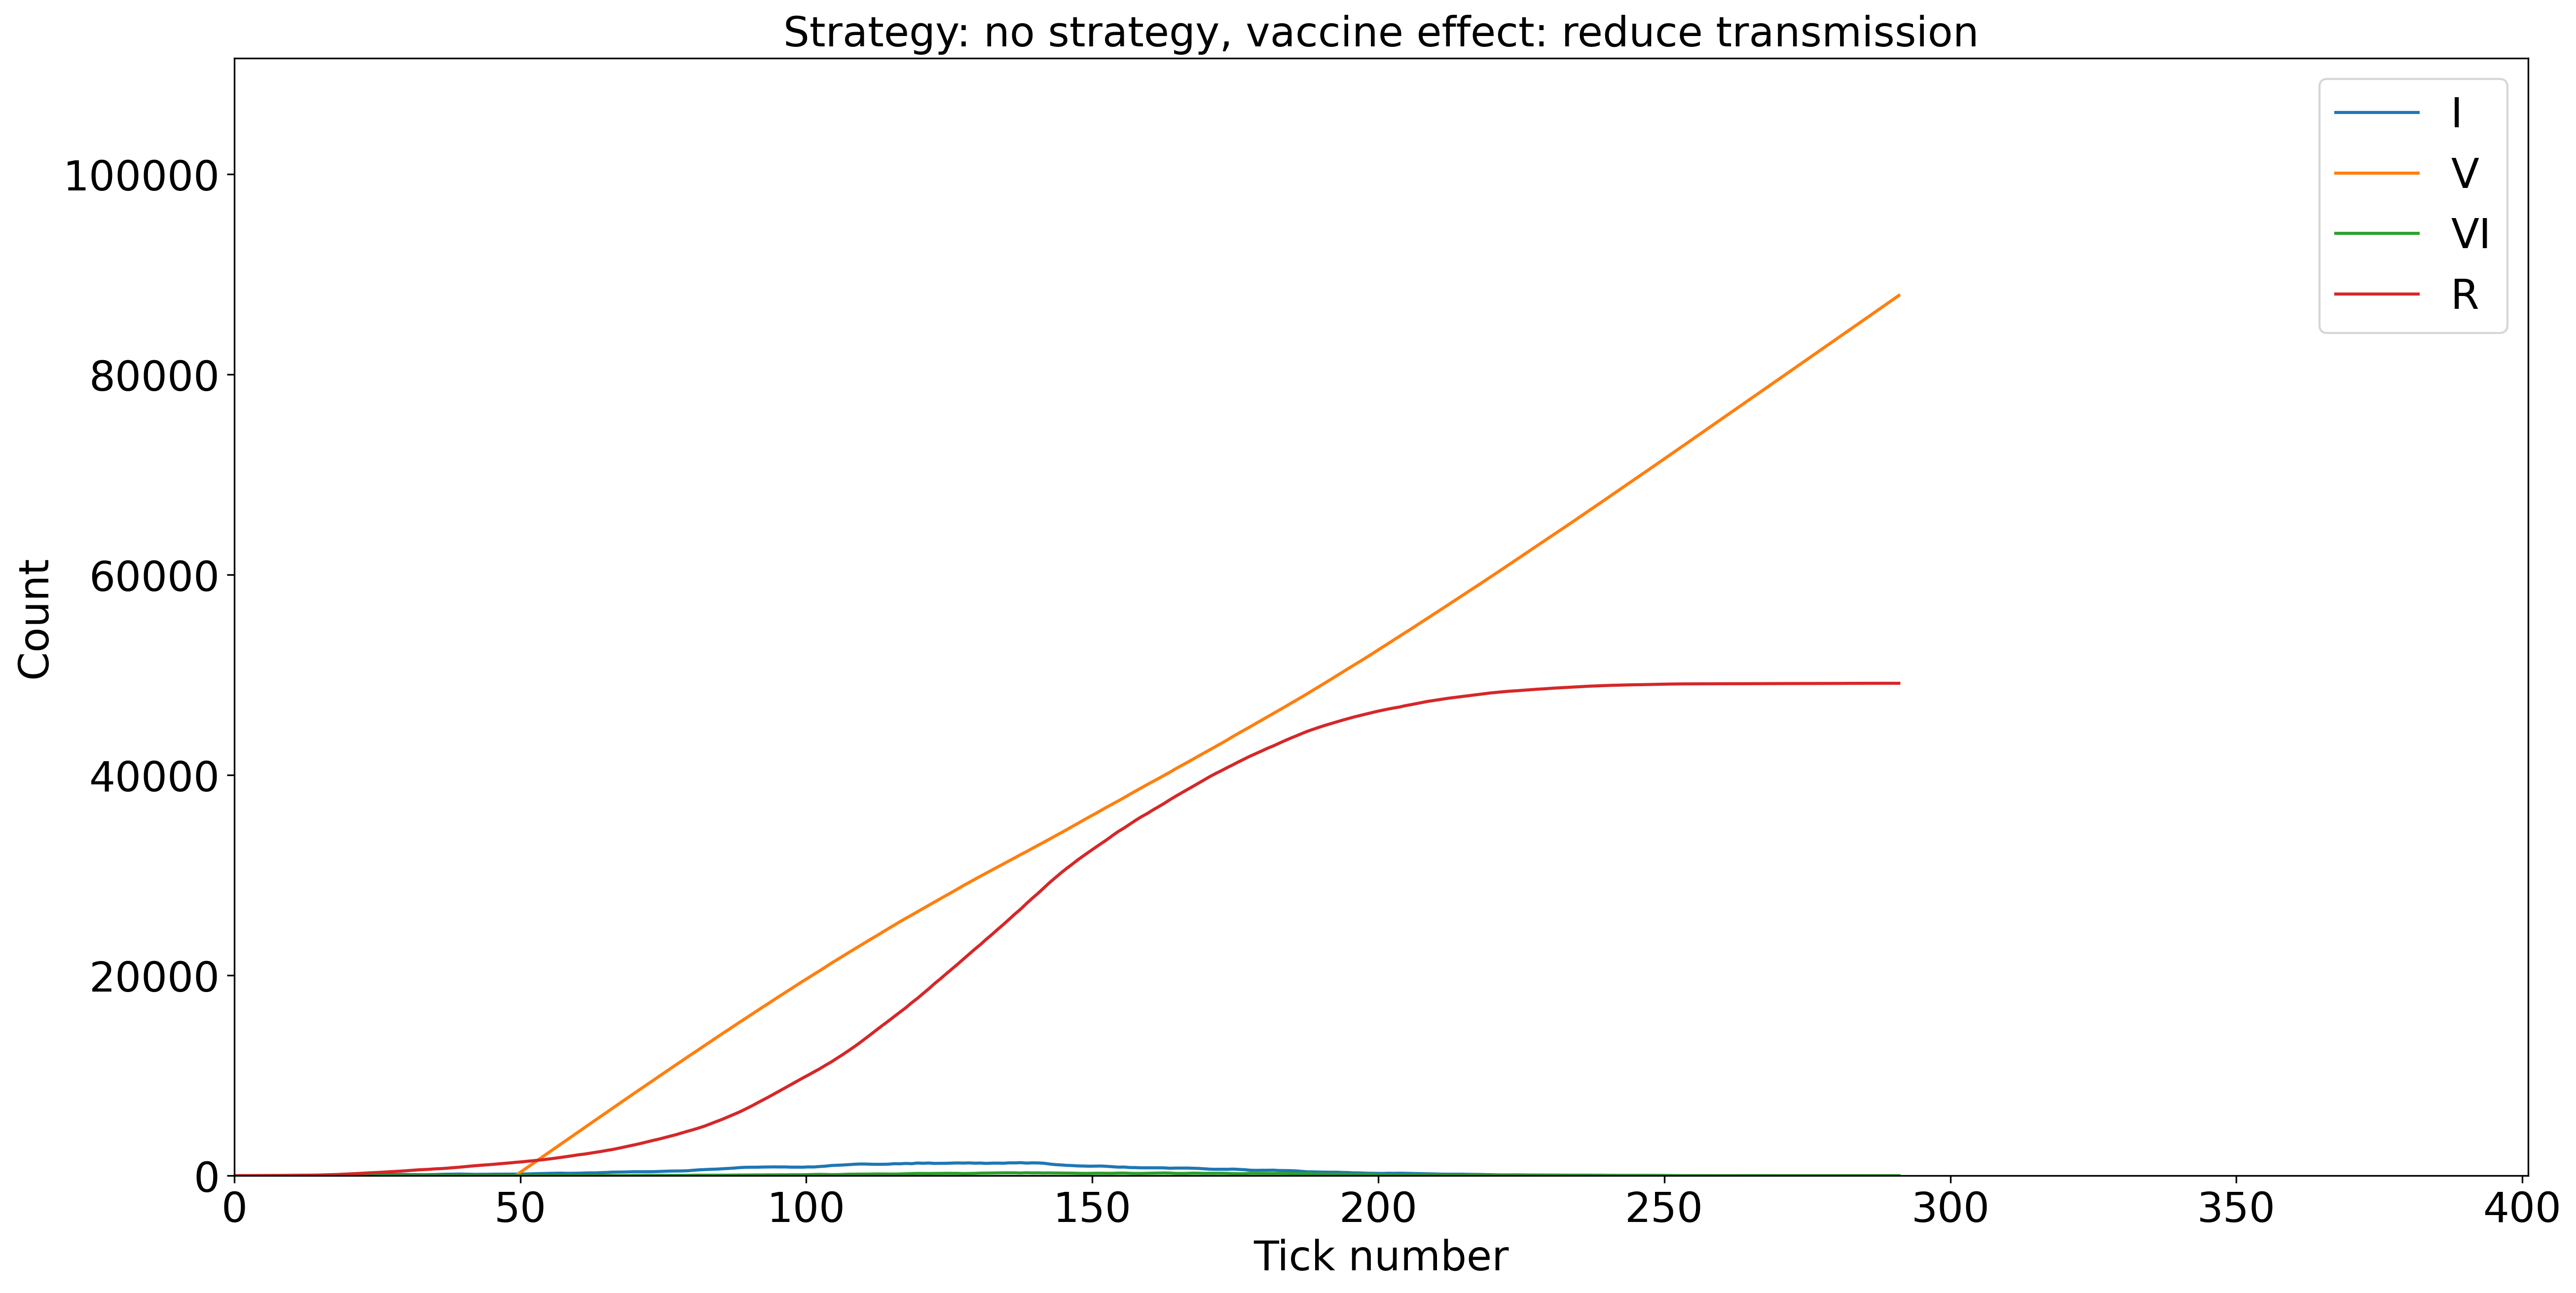

Strategy: no strategy
Vaccine effect: reduce infection


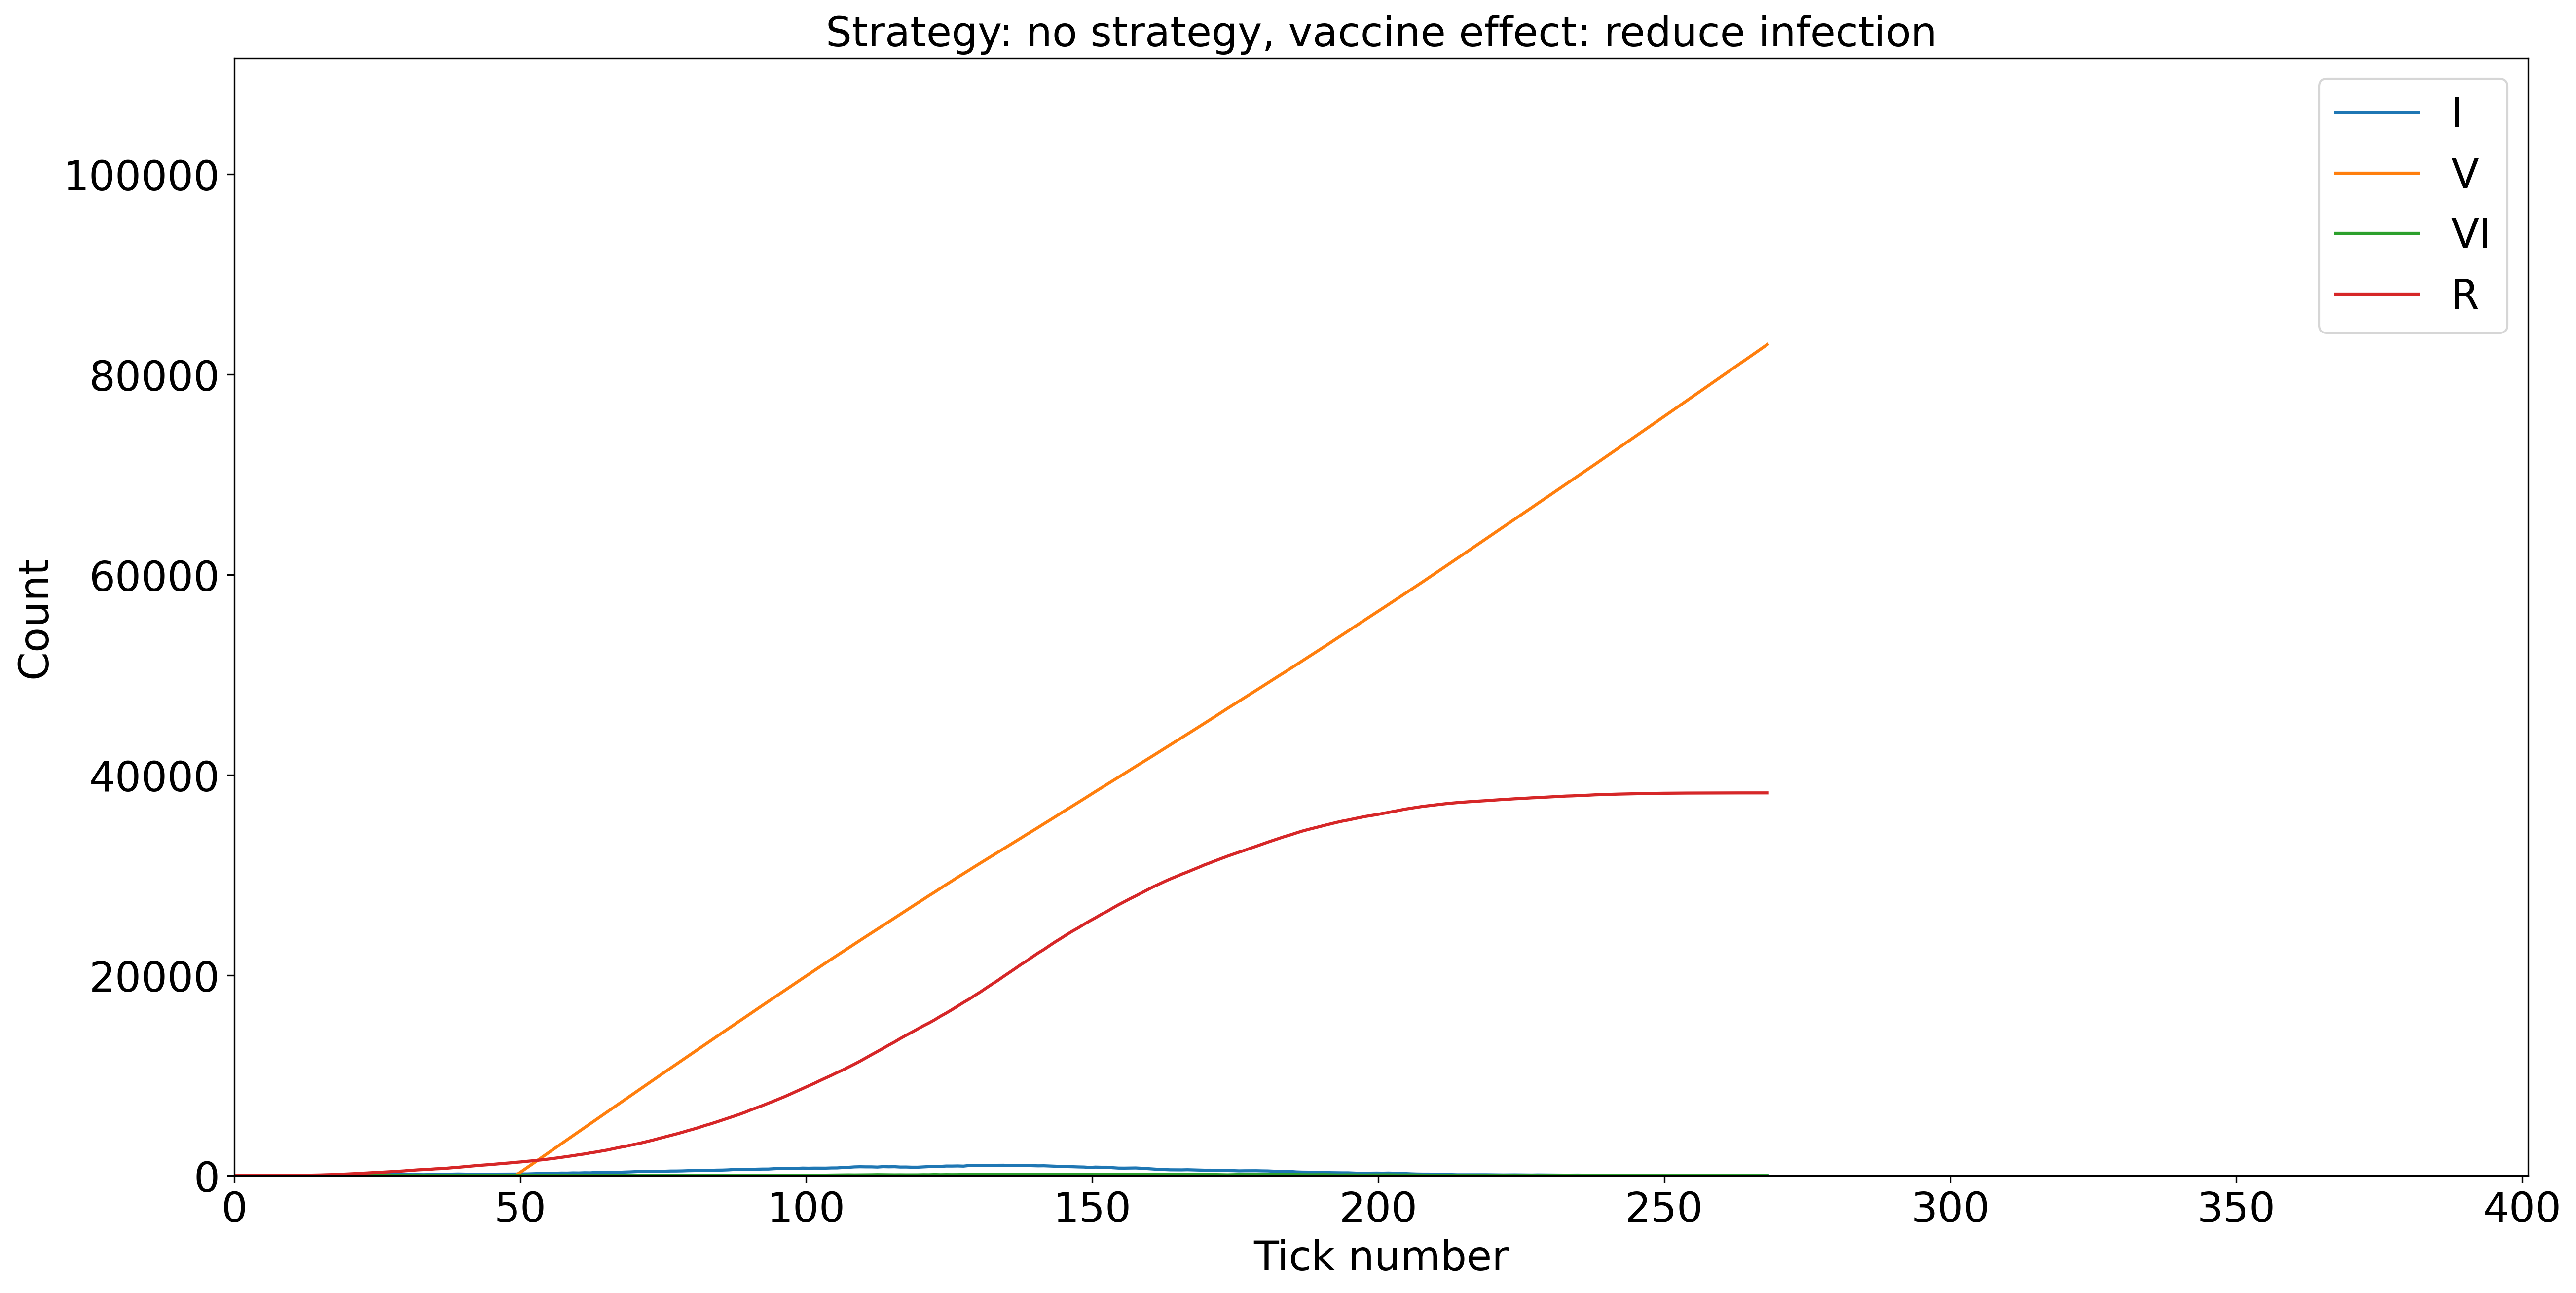

Strategy: no strategy
Vaccine effect: reduce both


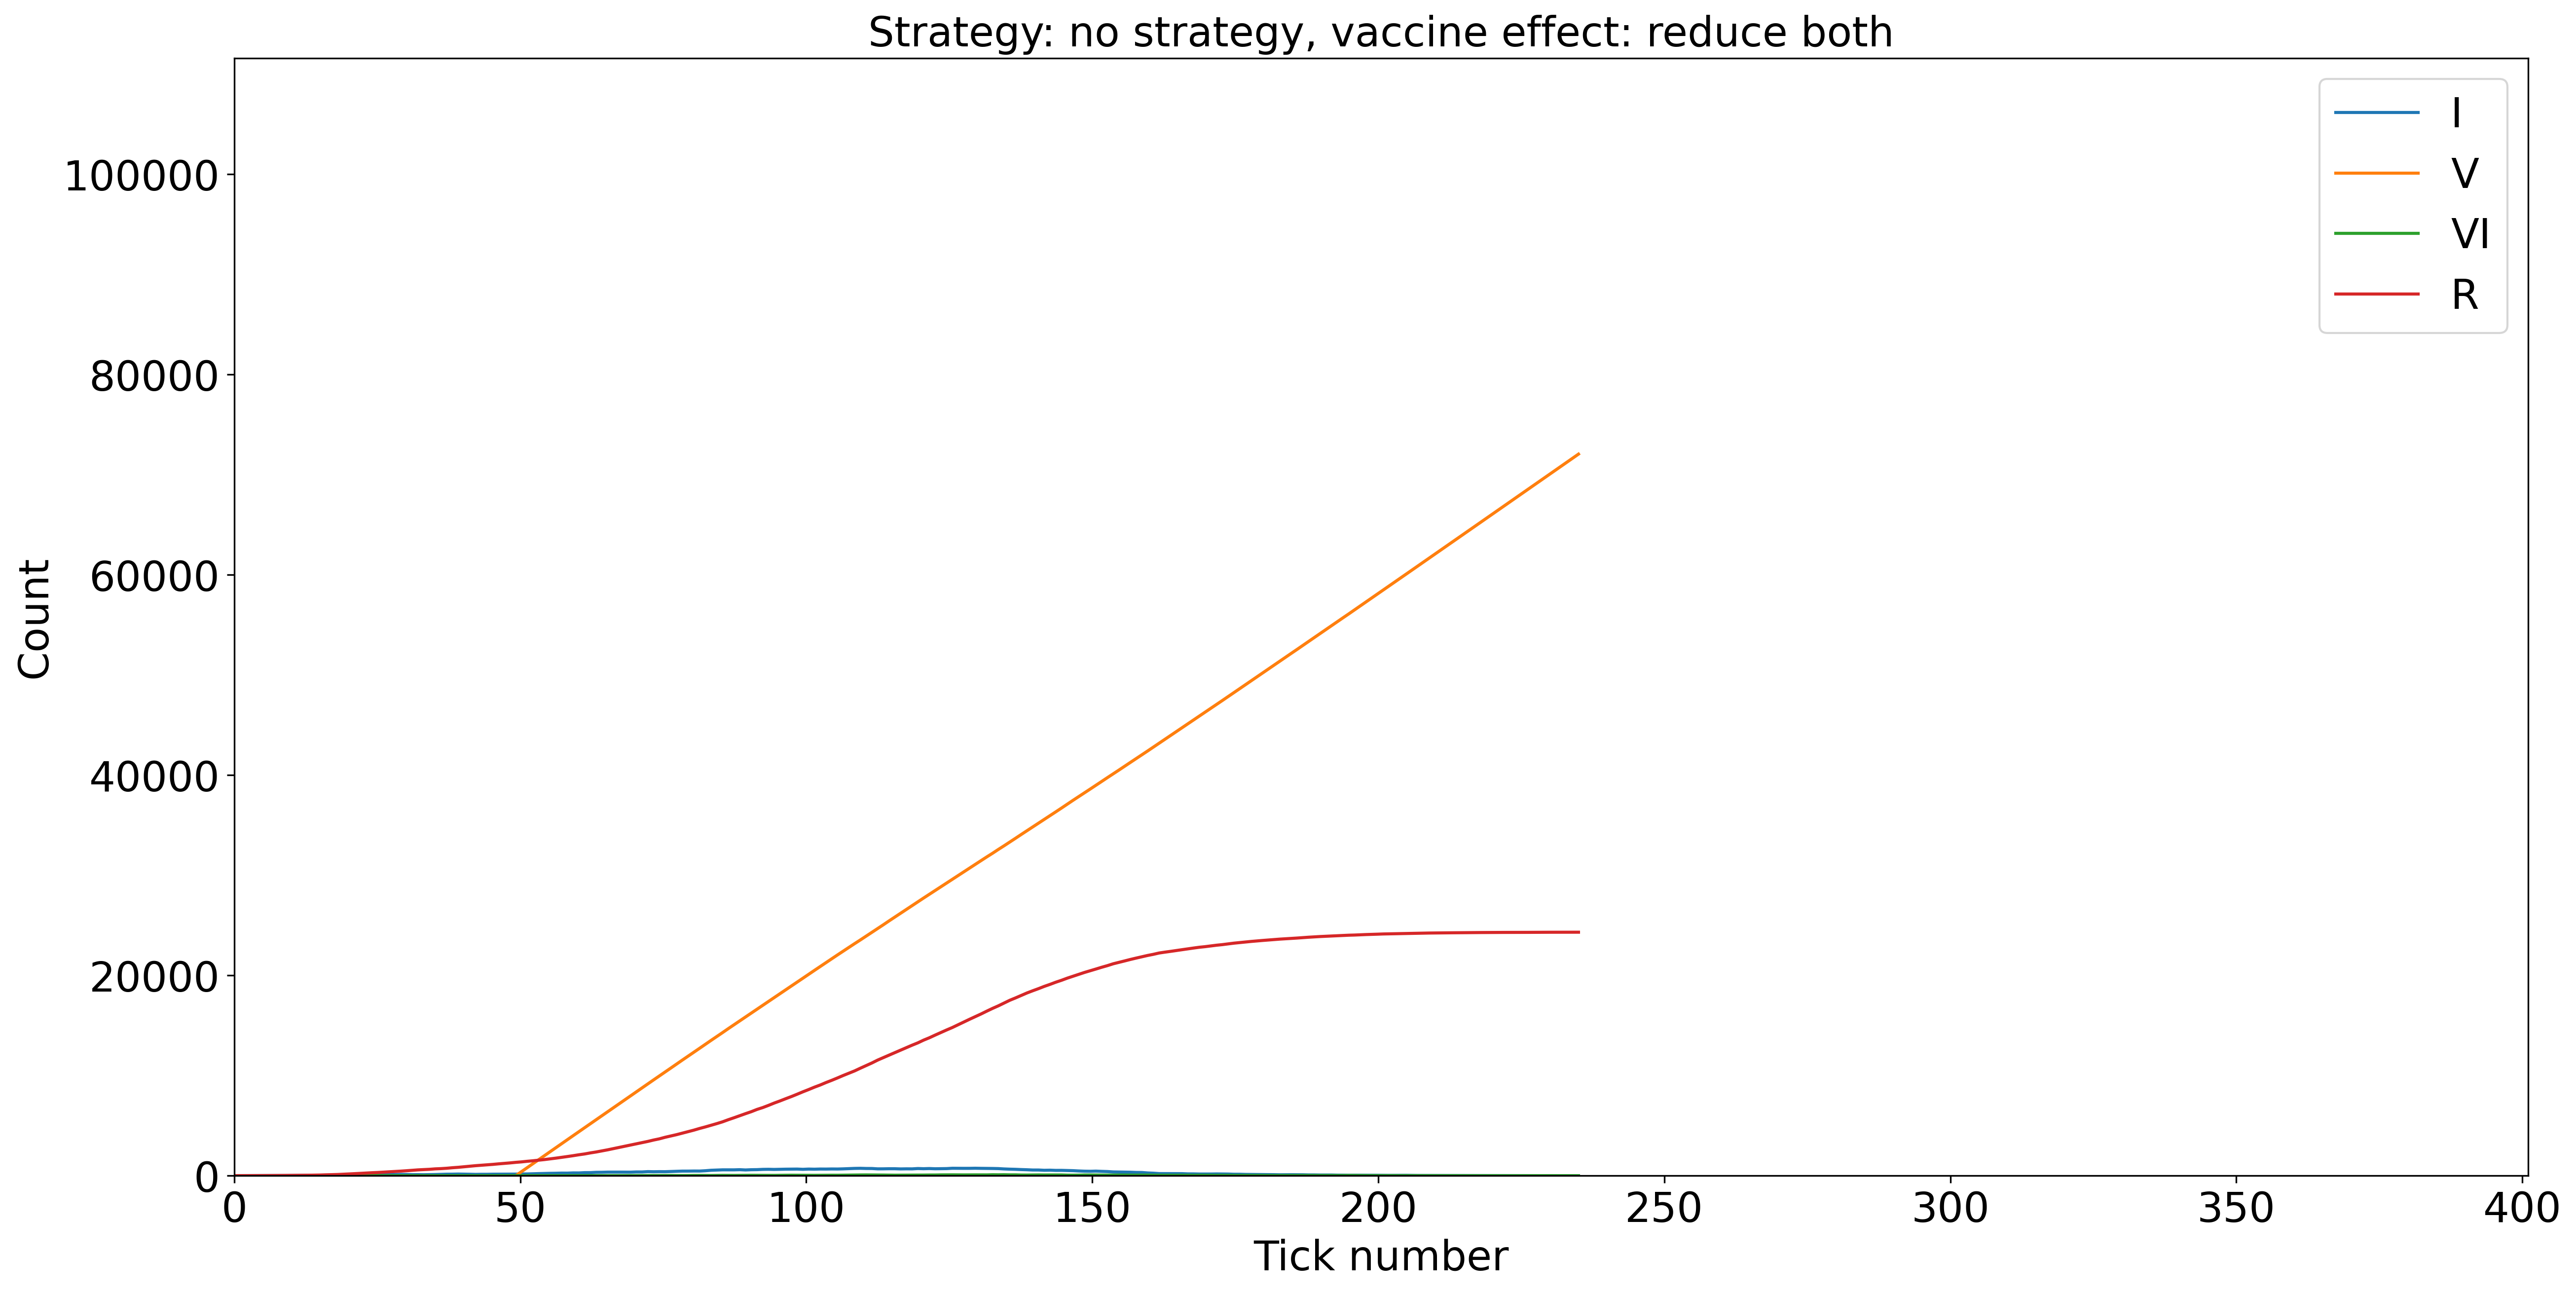

Strategy: strategy dc
Vaccine effect: no effect


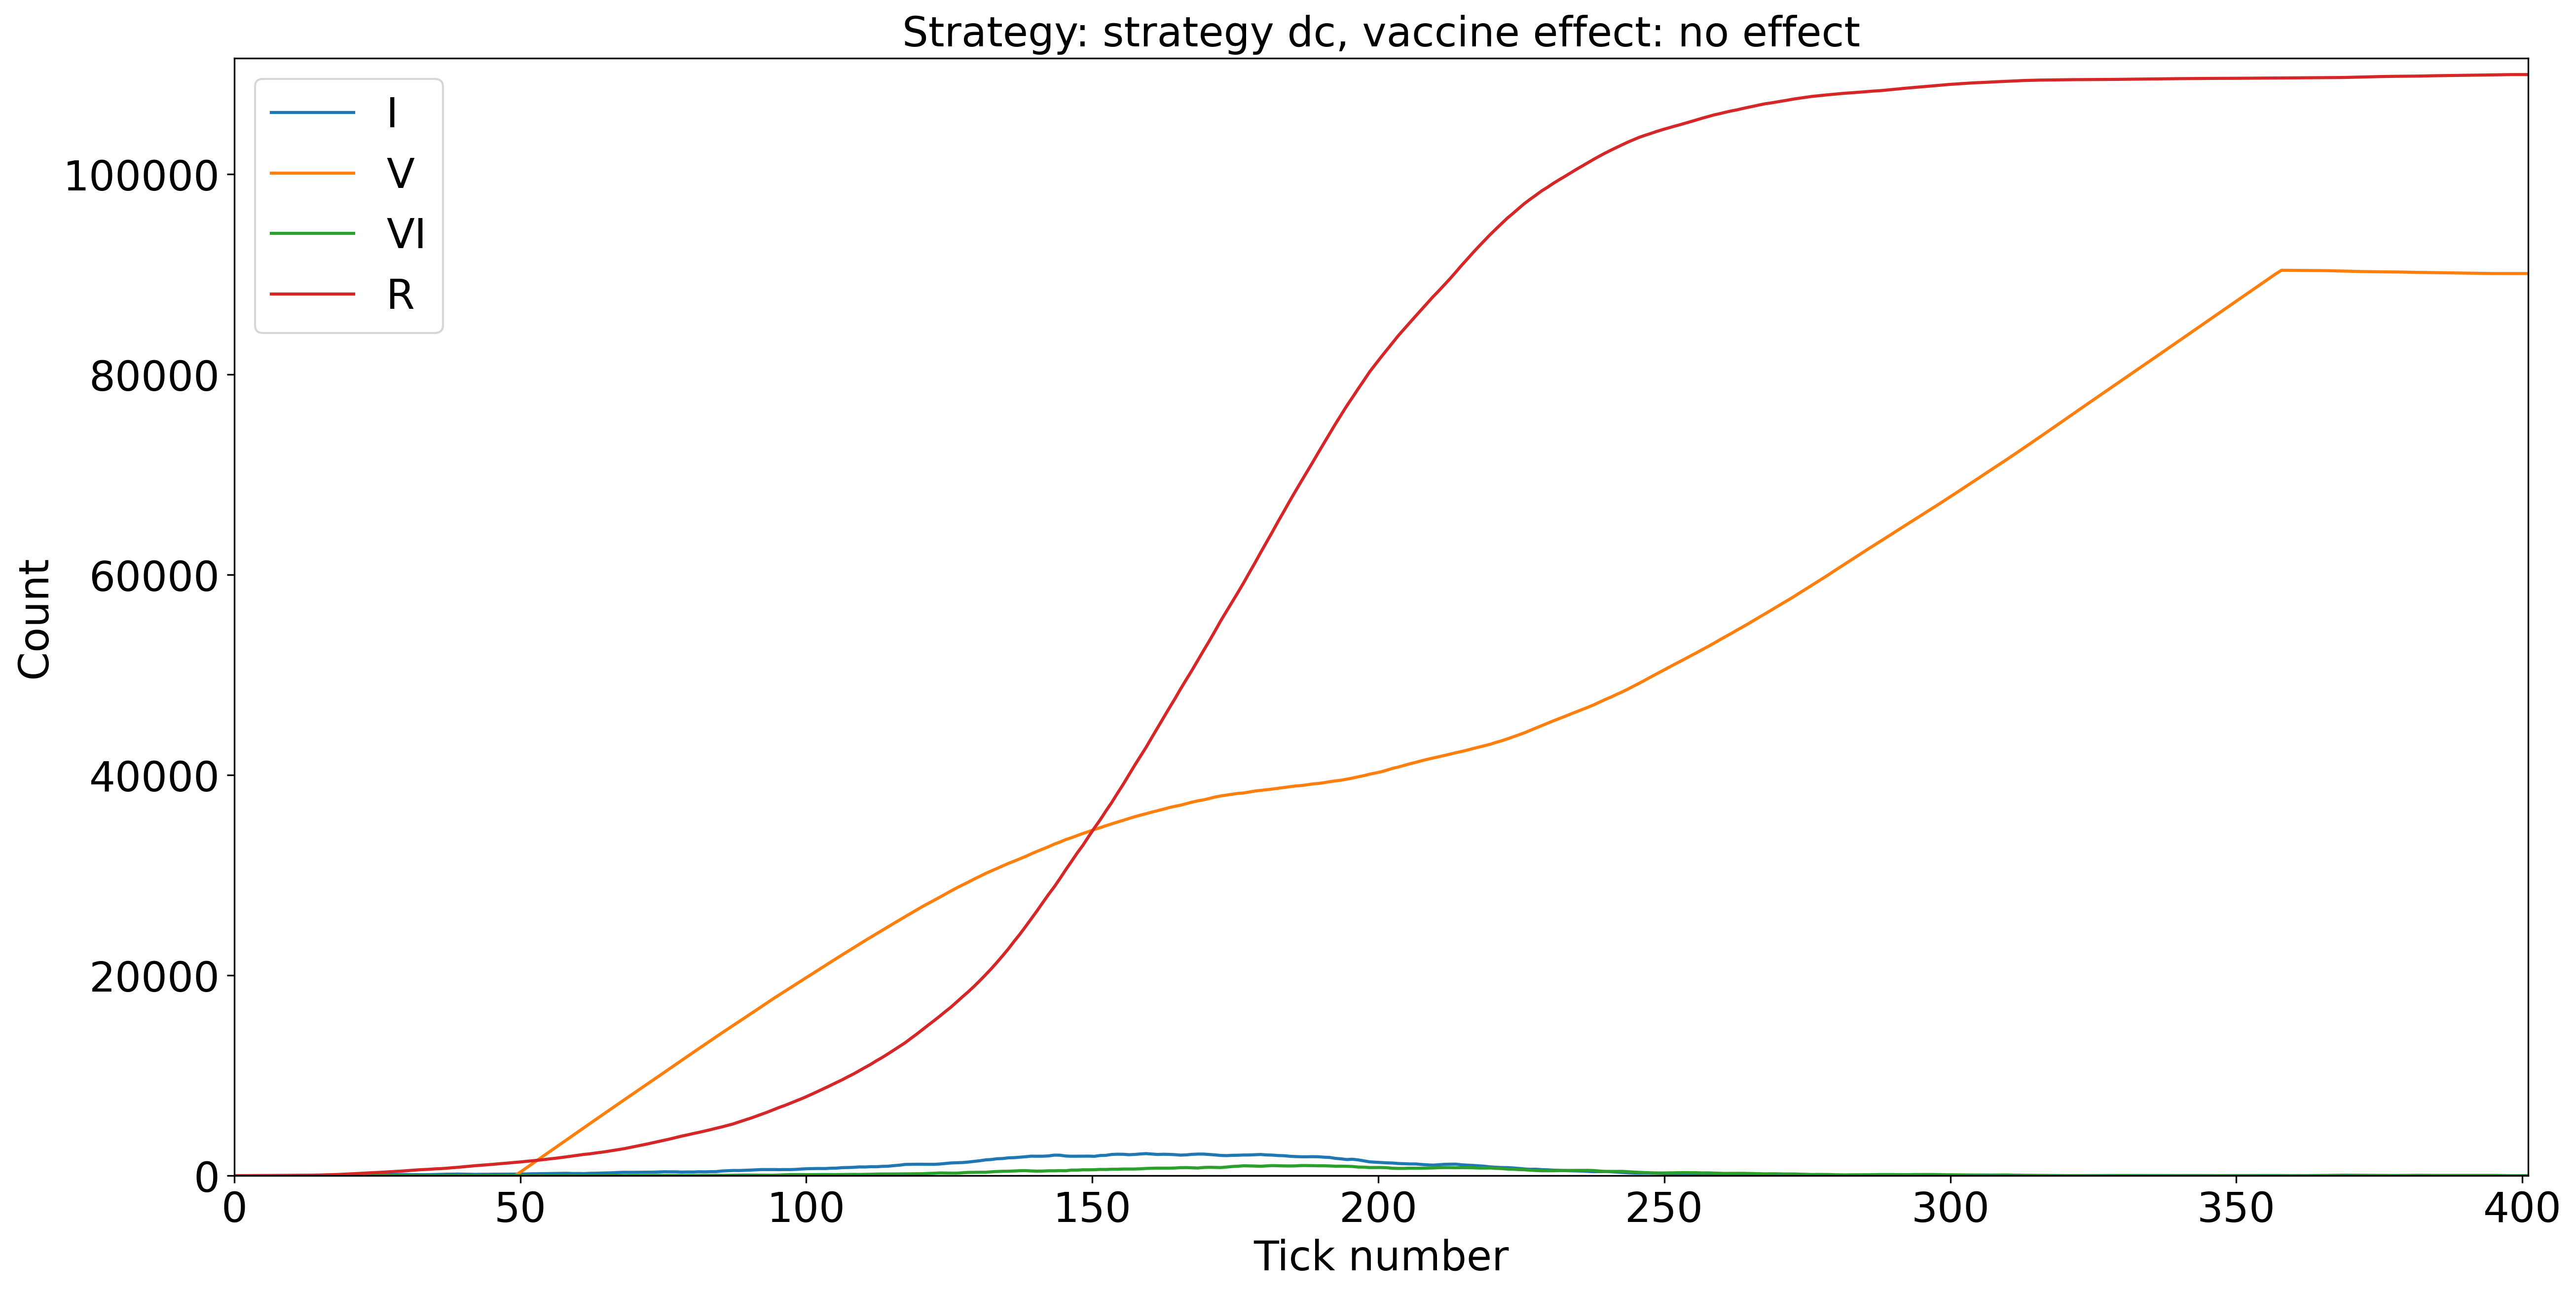

Strategy: strategy dc
Vaccine effect: reduce transmission


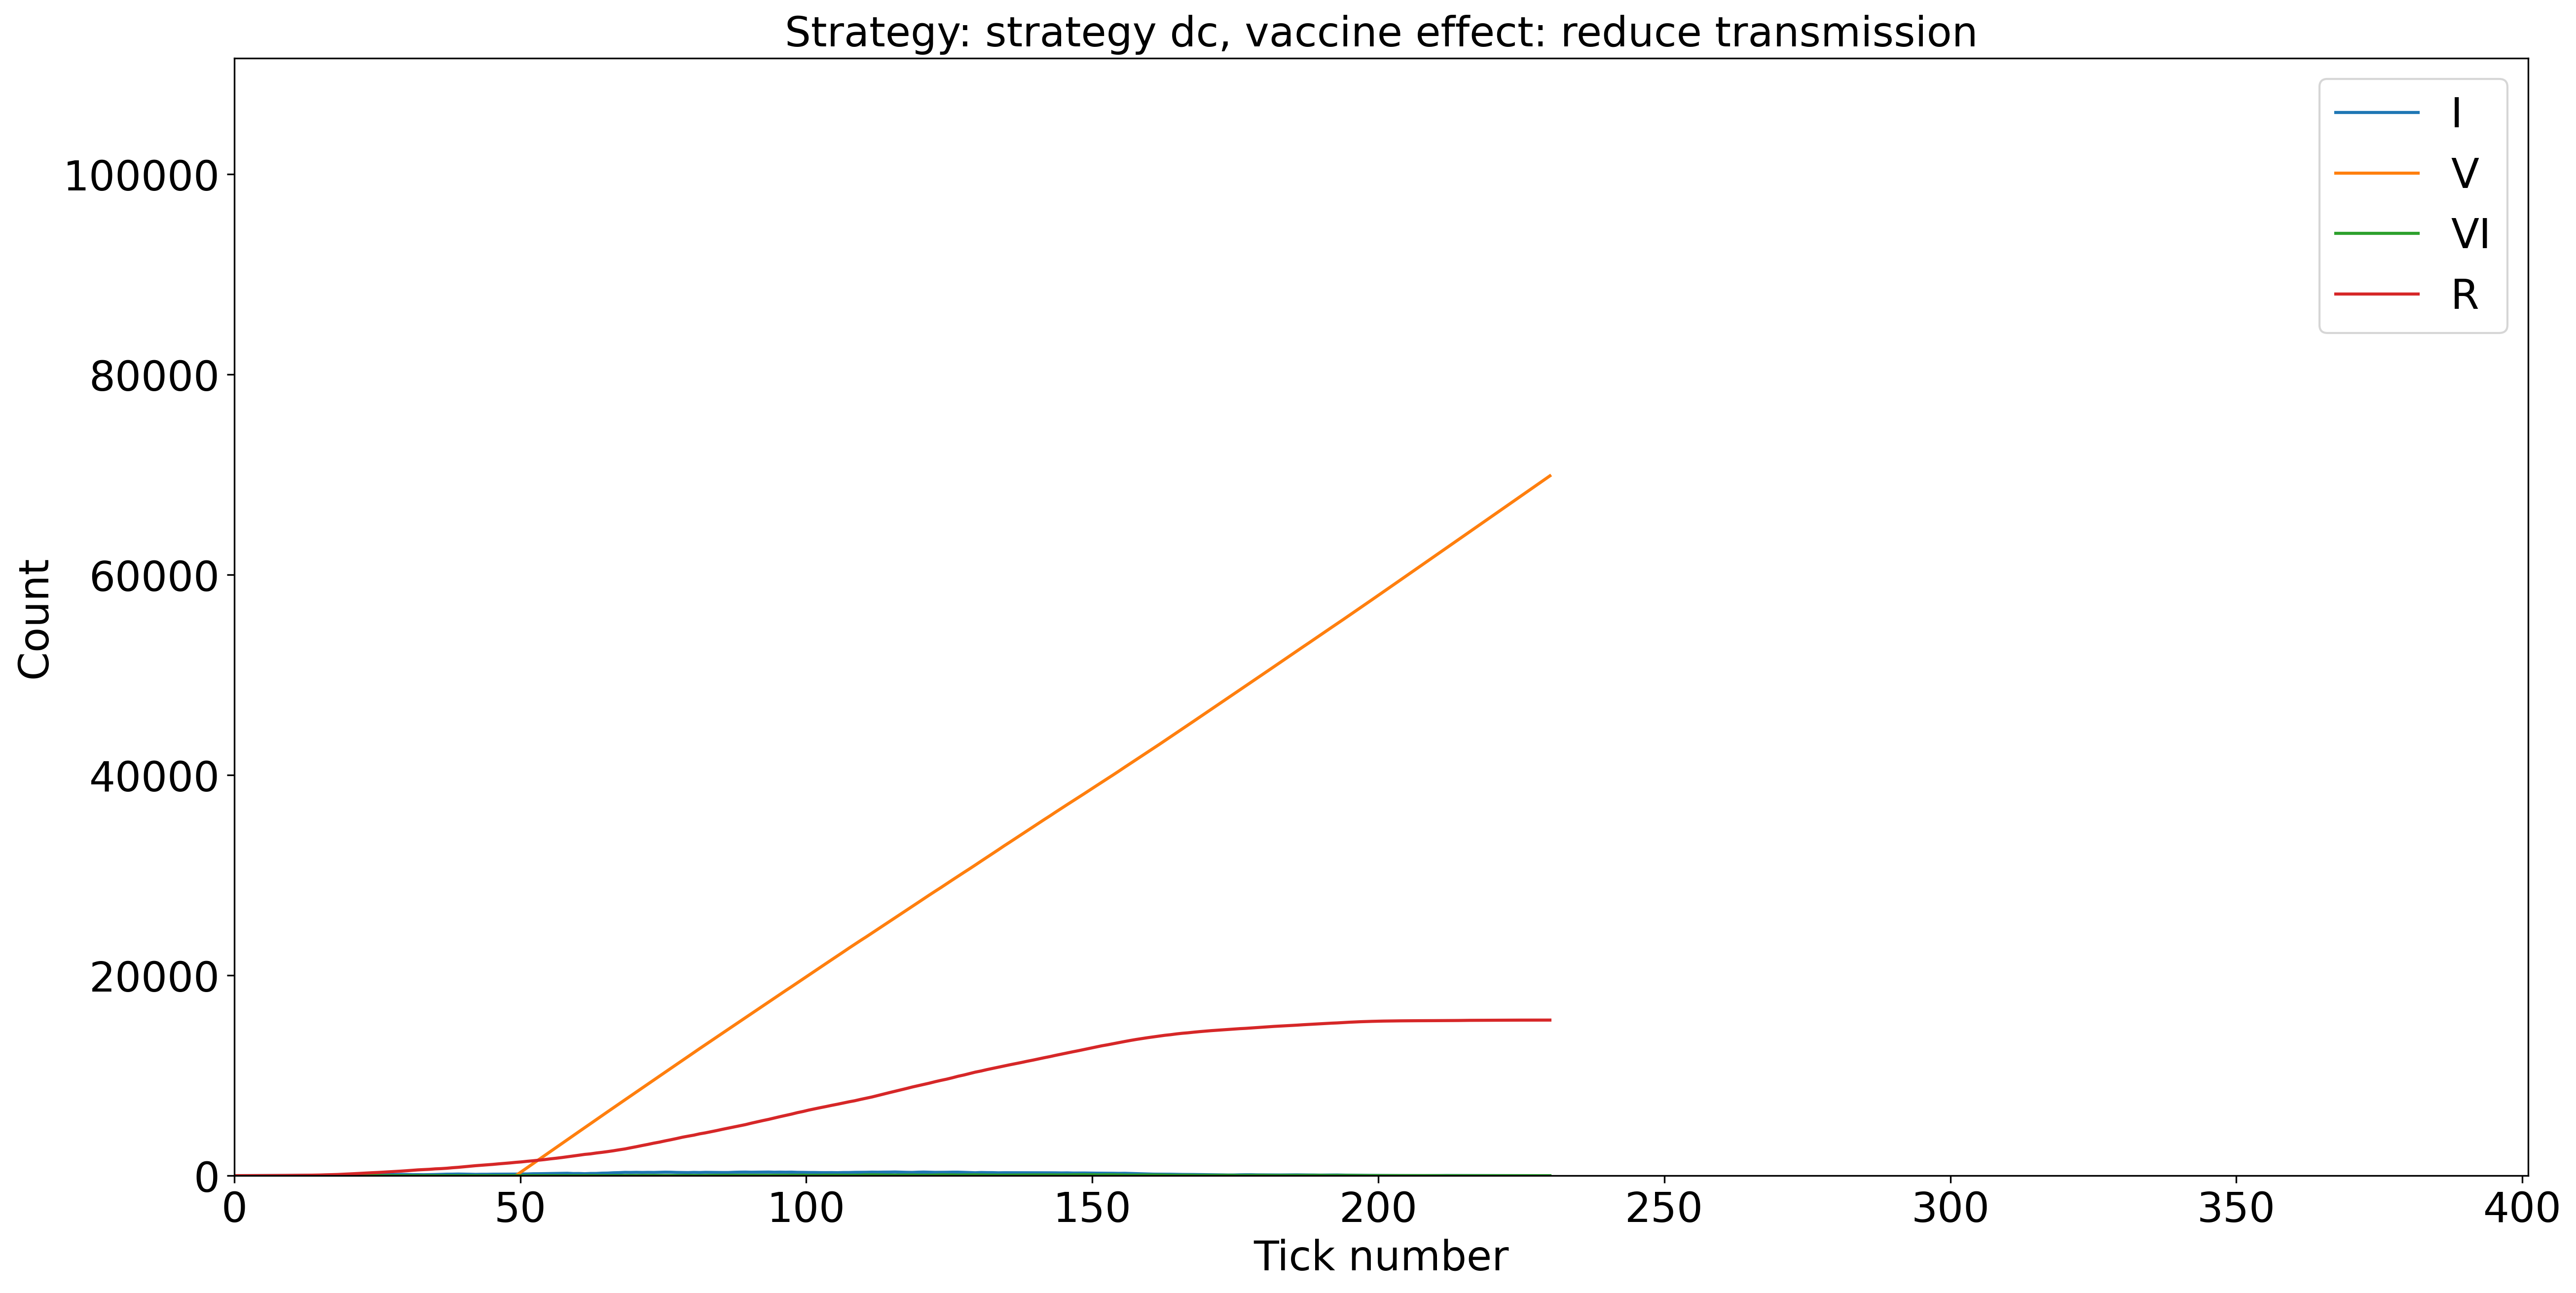

Strategy: strategy dc
Vaccine effect: reduce infection


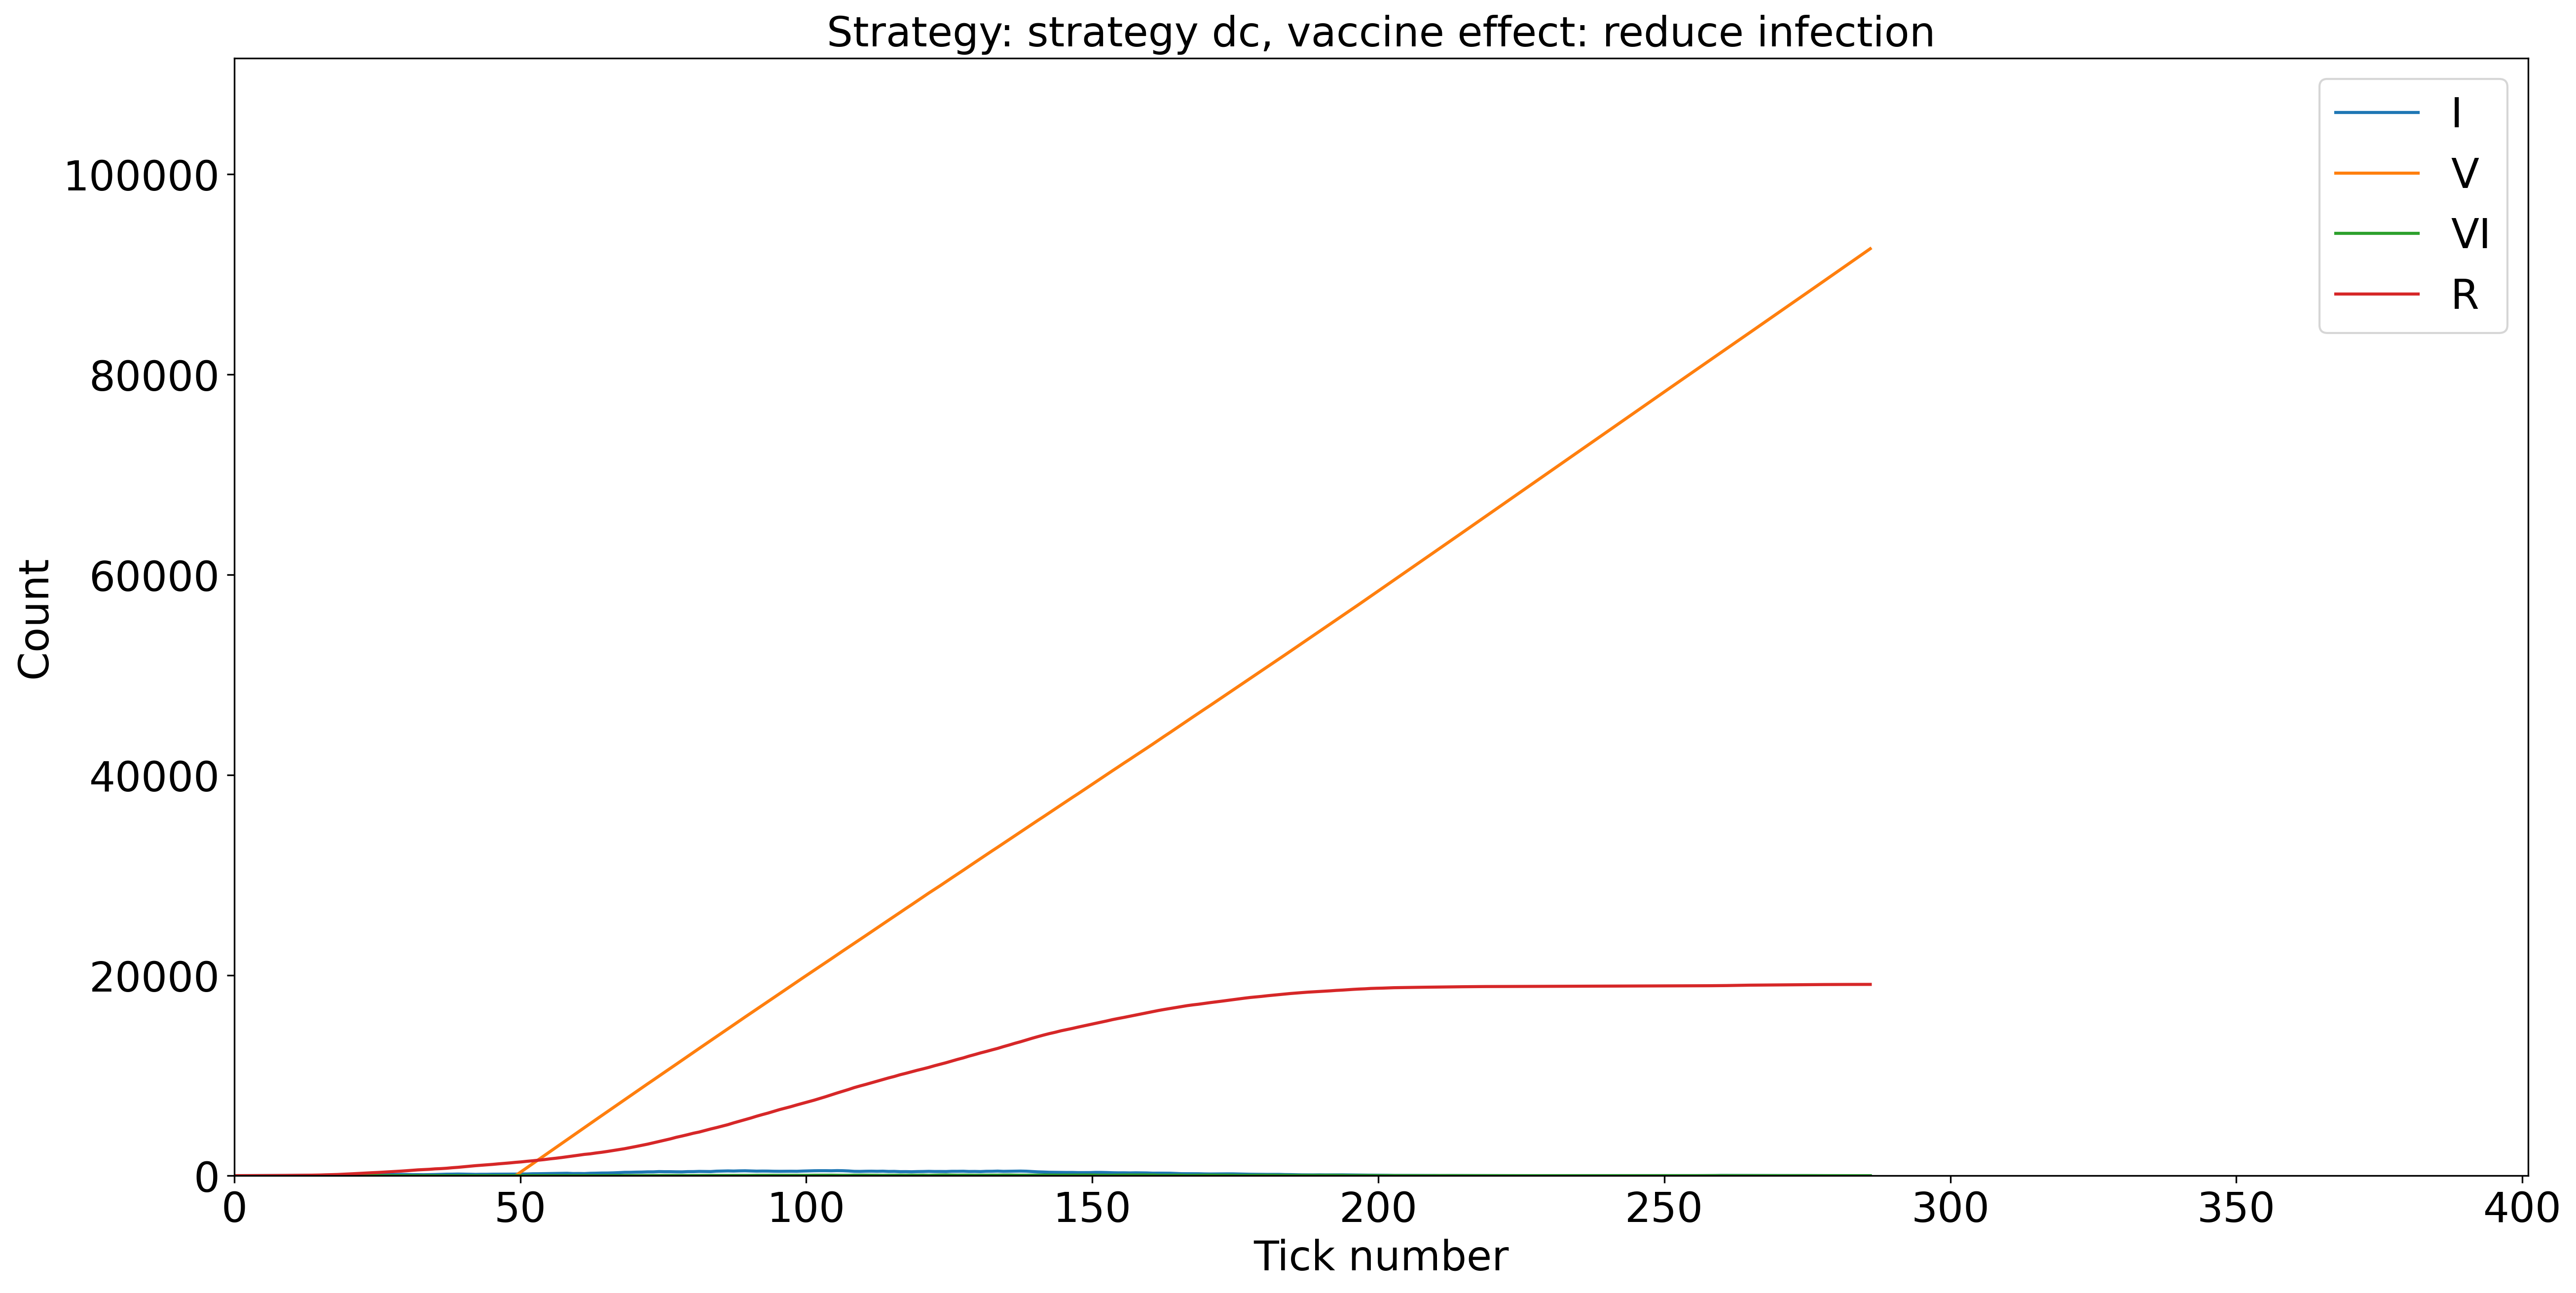

Strategy: strategy dc
Vaccine effect: reduce both


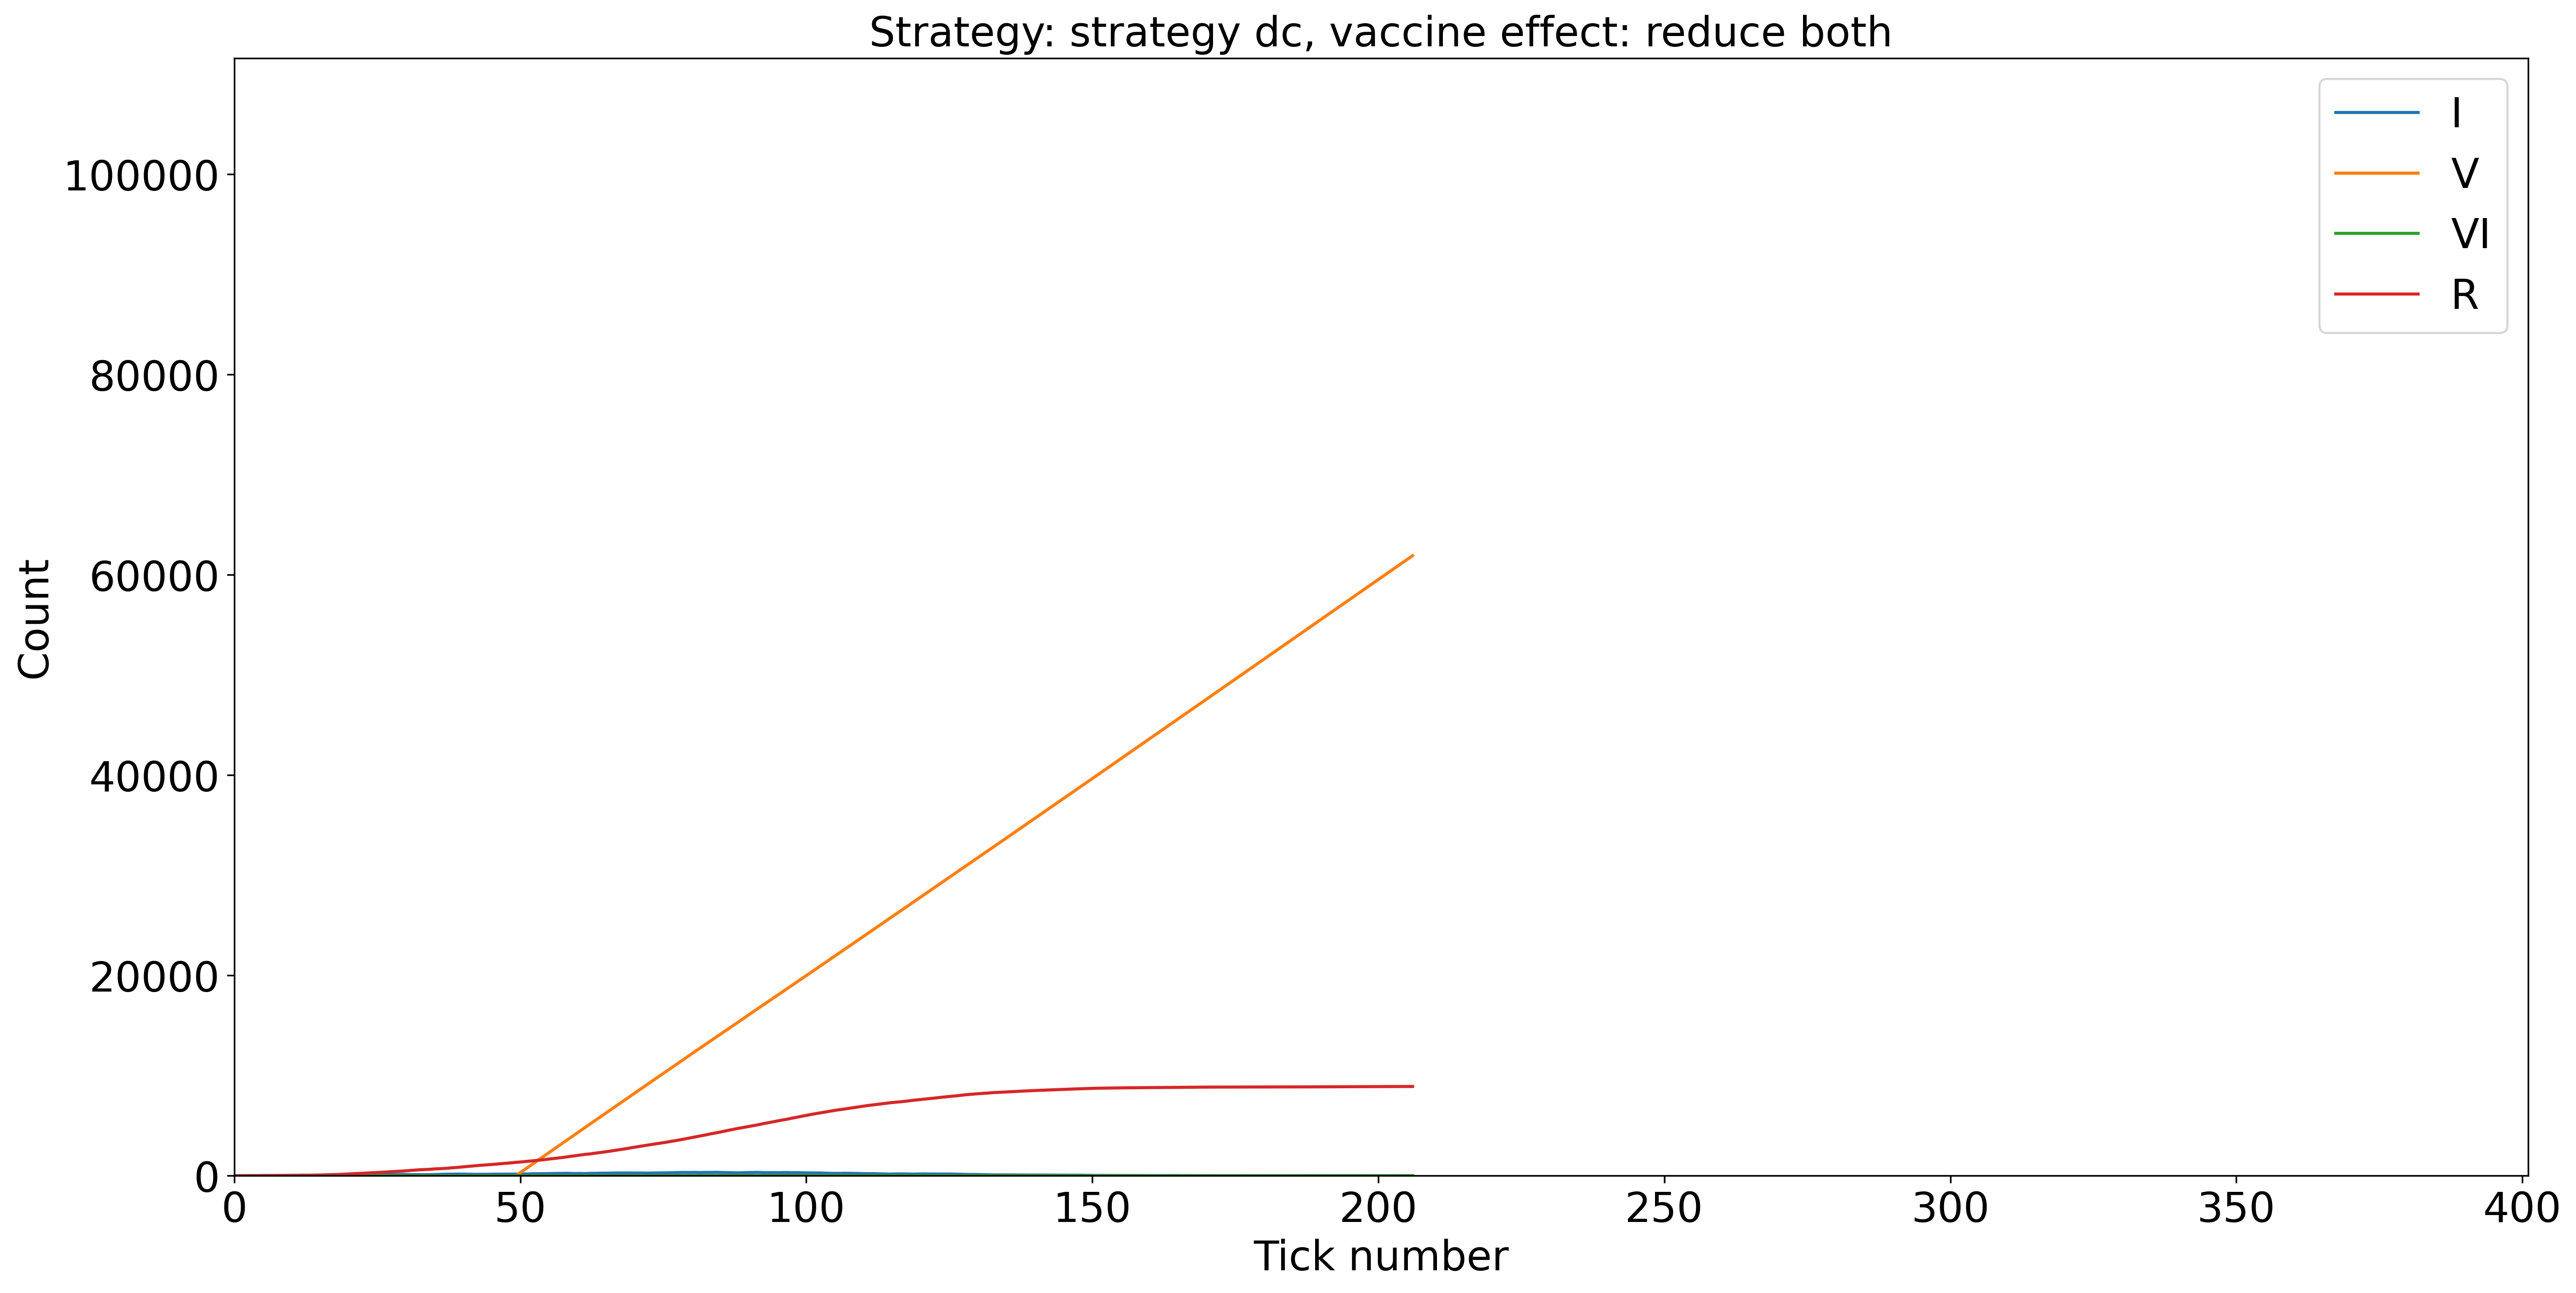

Strategy: strategy ac
Vaccine effect: no effect


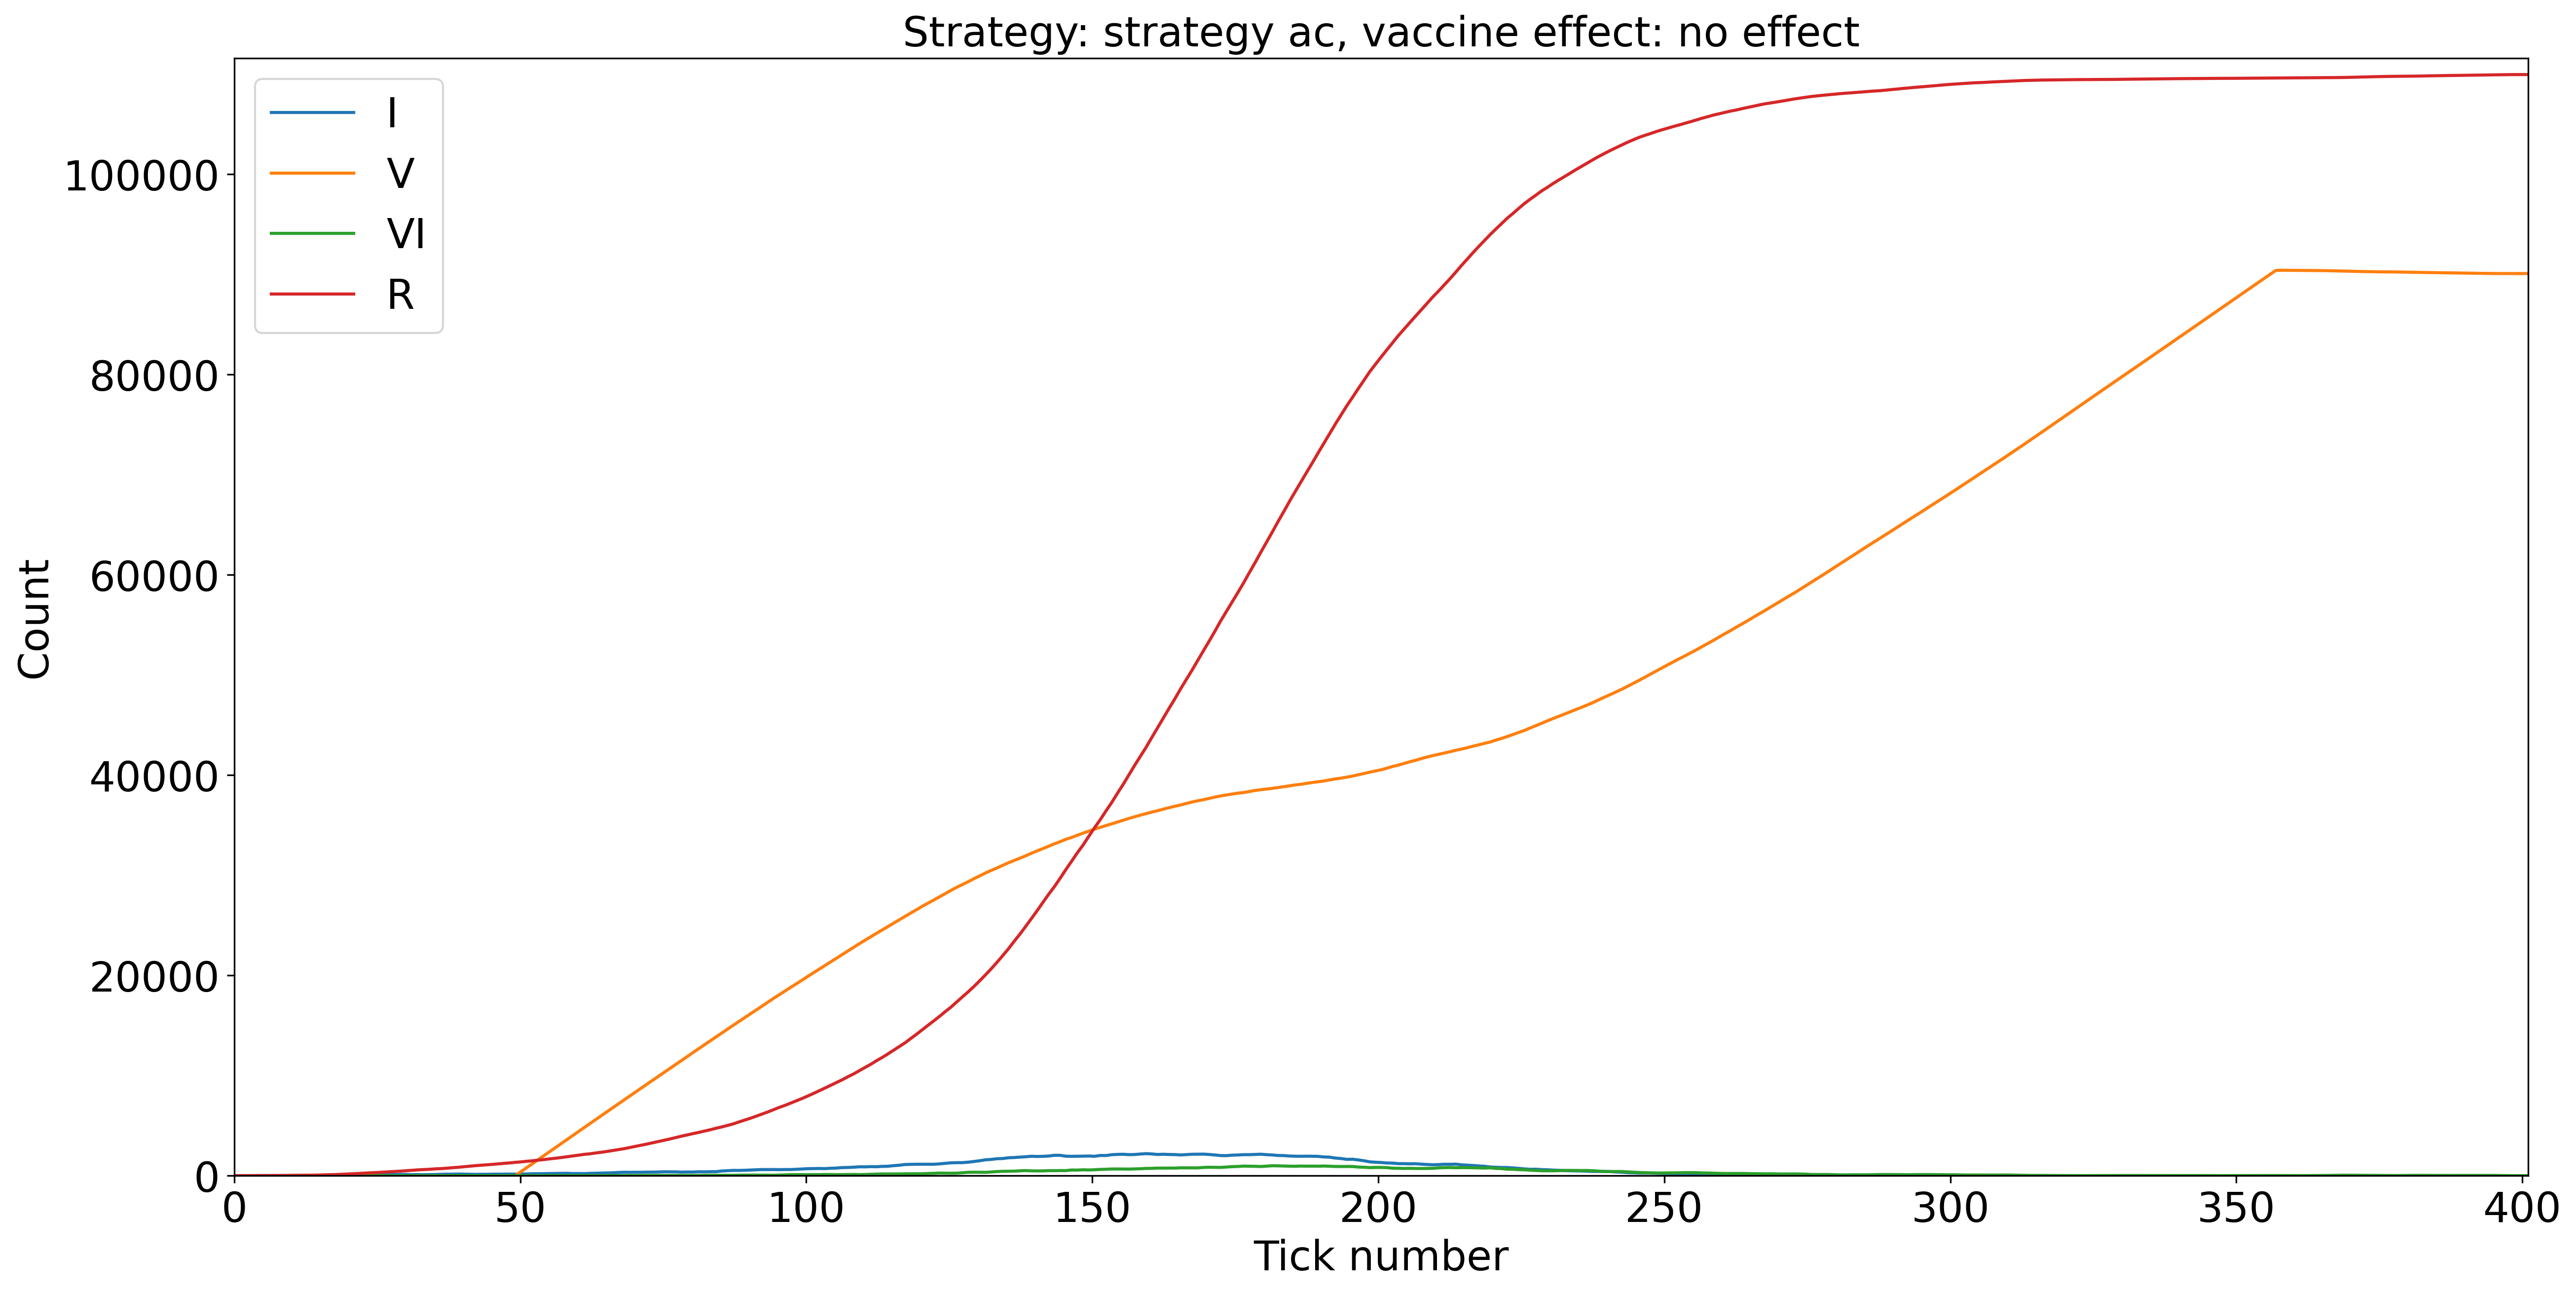

Strategy: strategy ac
Vaccine effect: reduce transmission


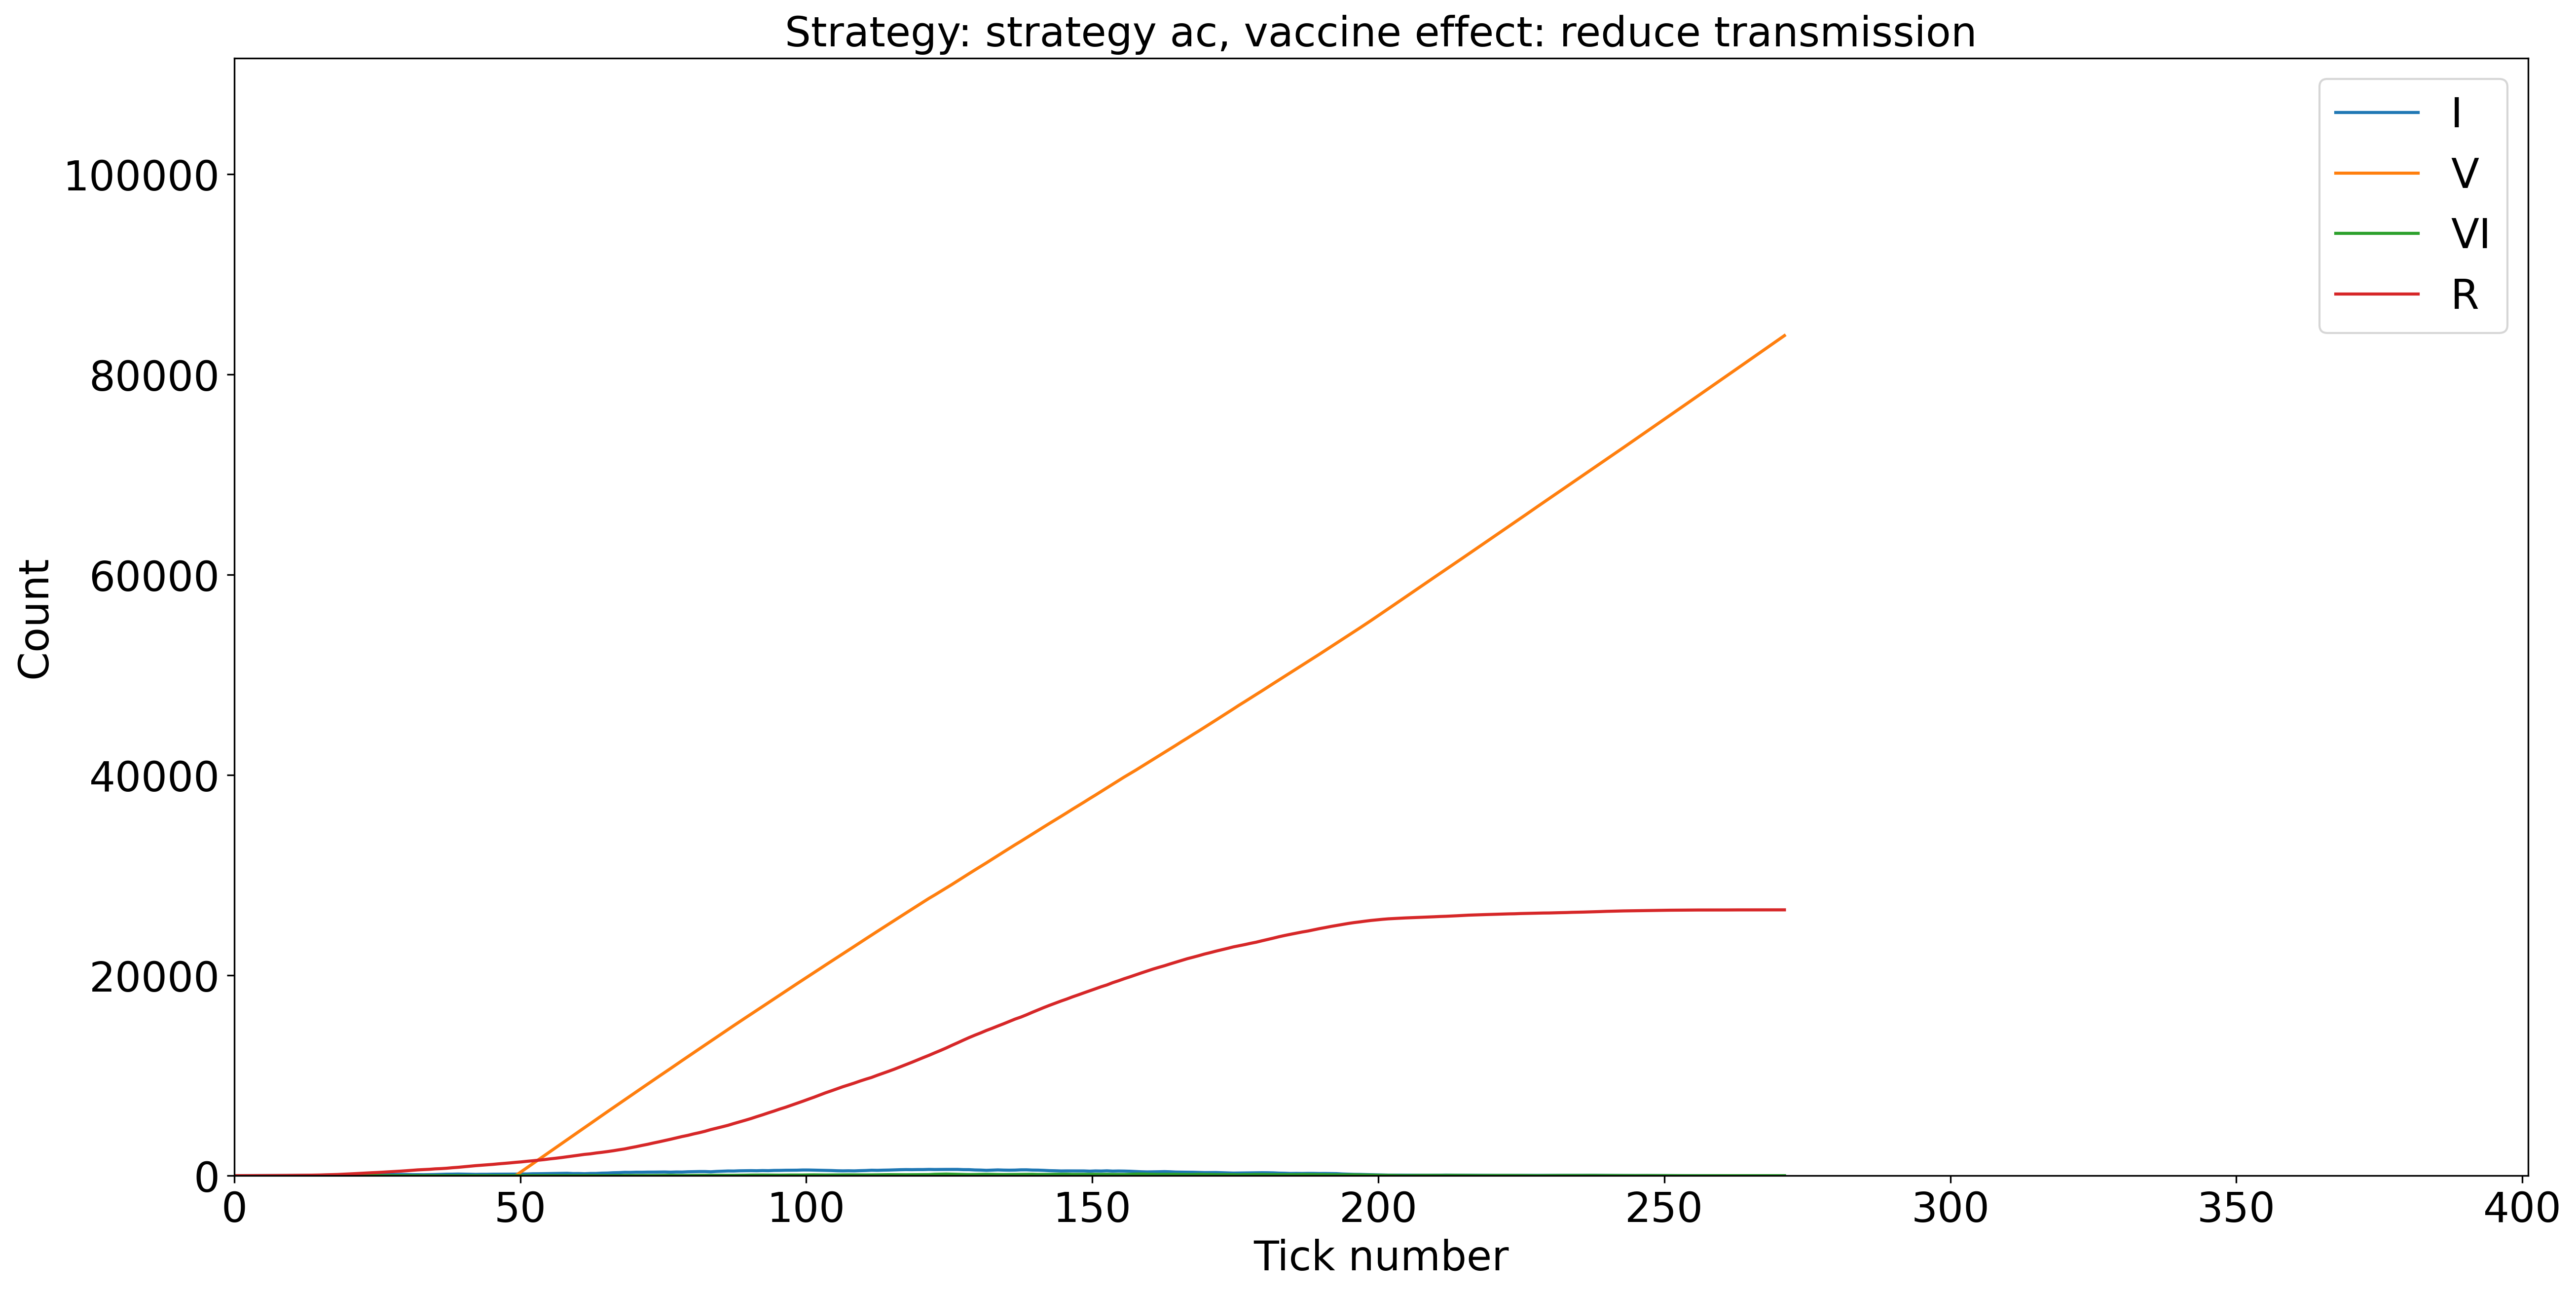

Strategy: strategy ac
Vaccine effect: reduce infection


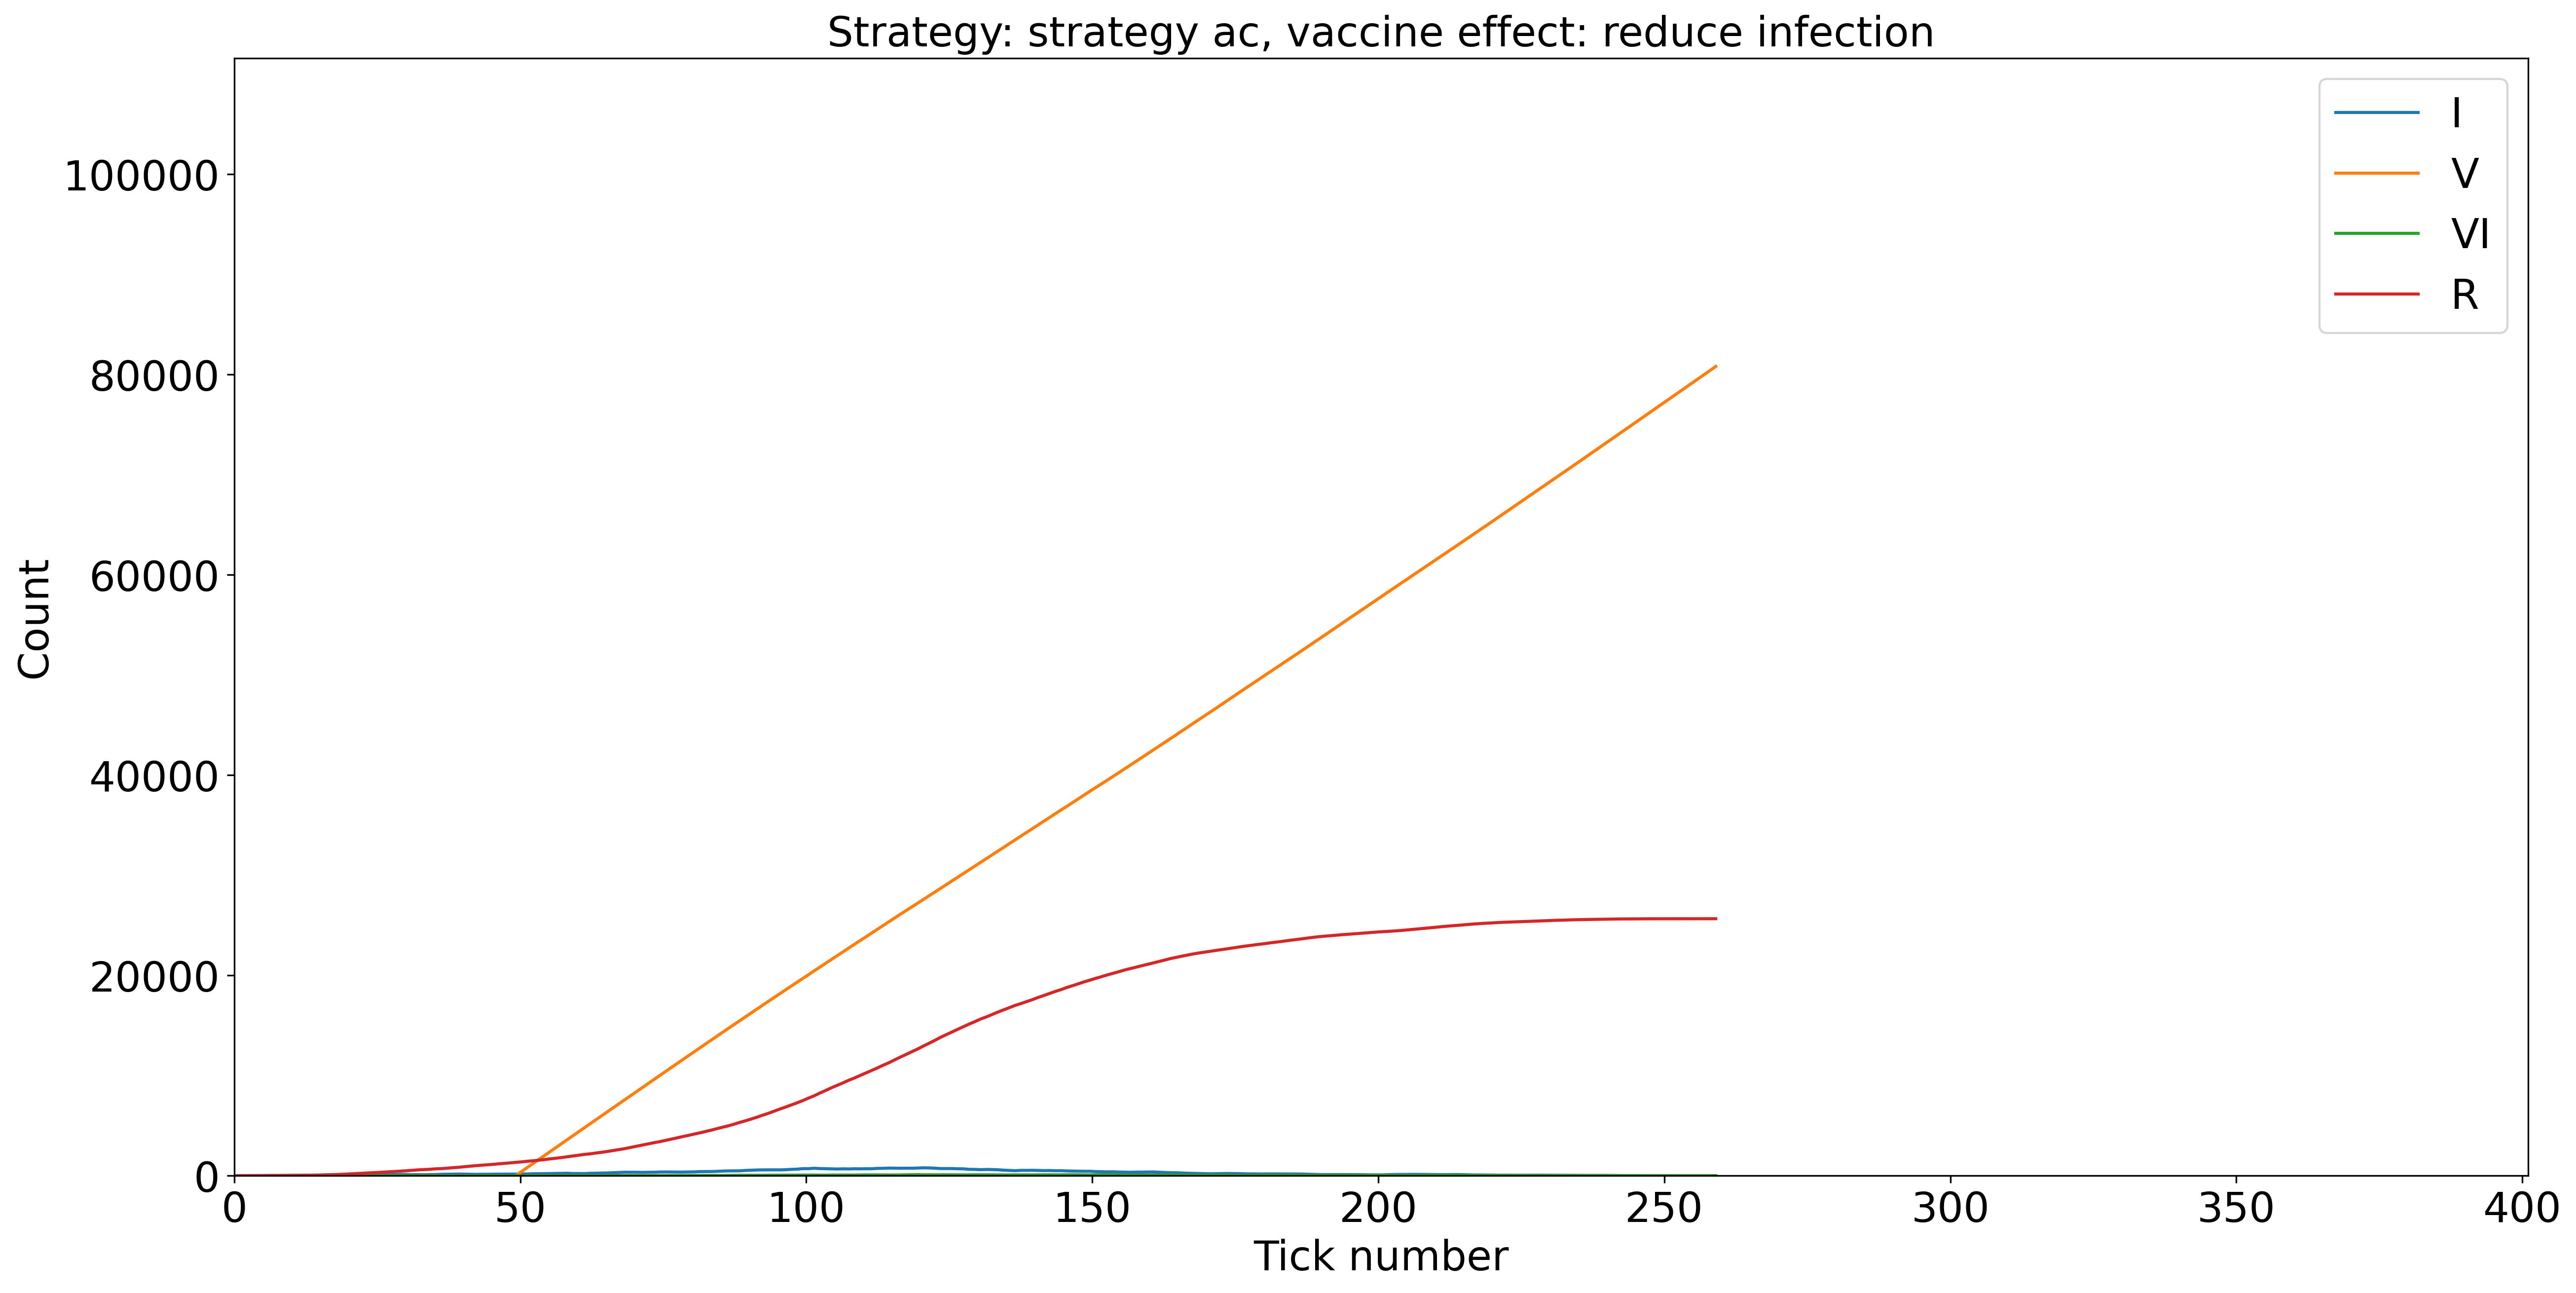

Strategy: strategy ac
Vaccine effect: reduce both


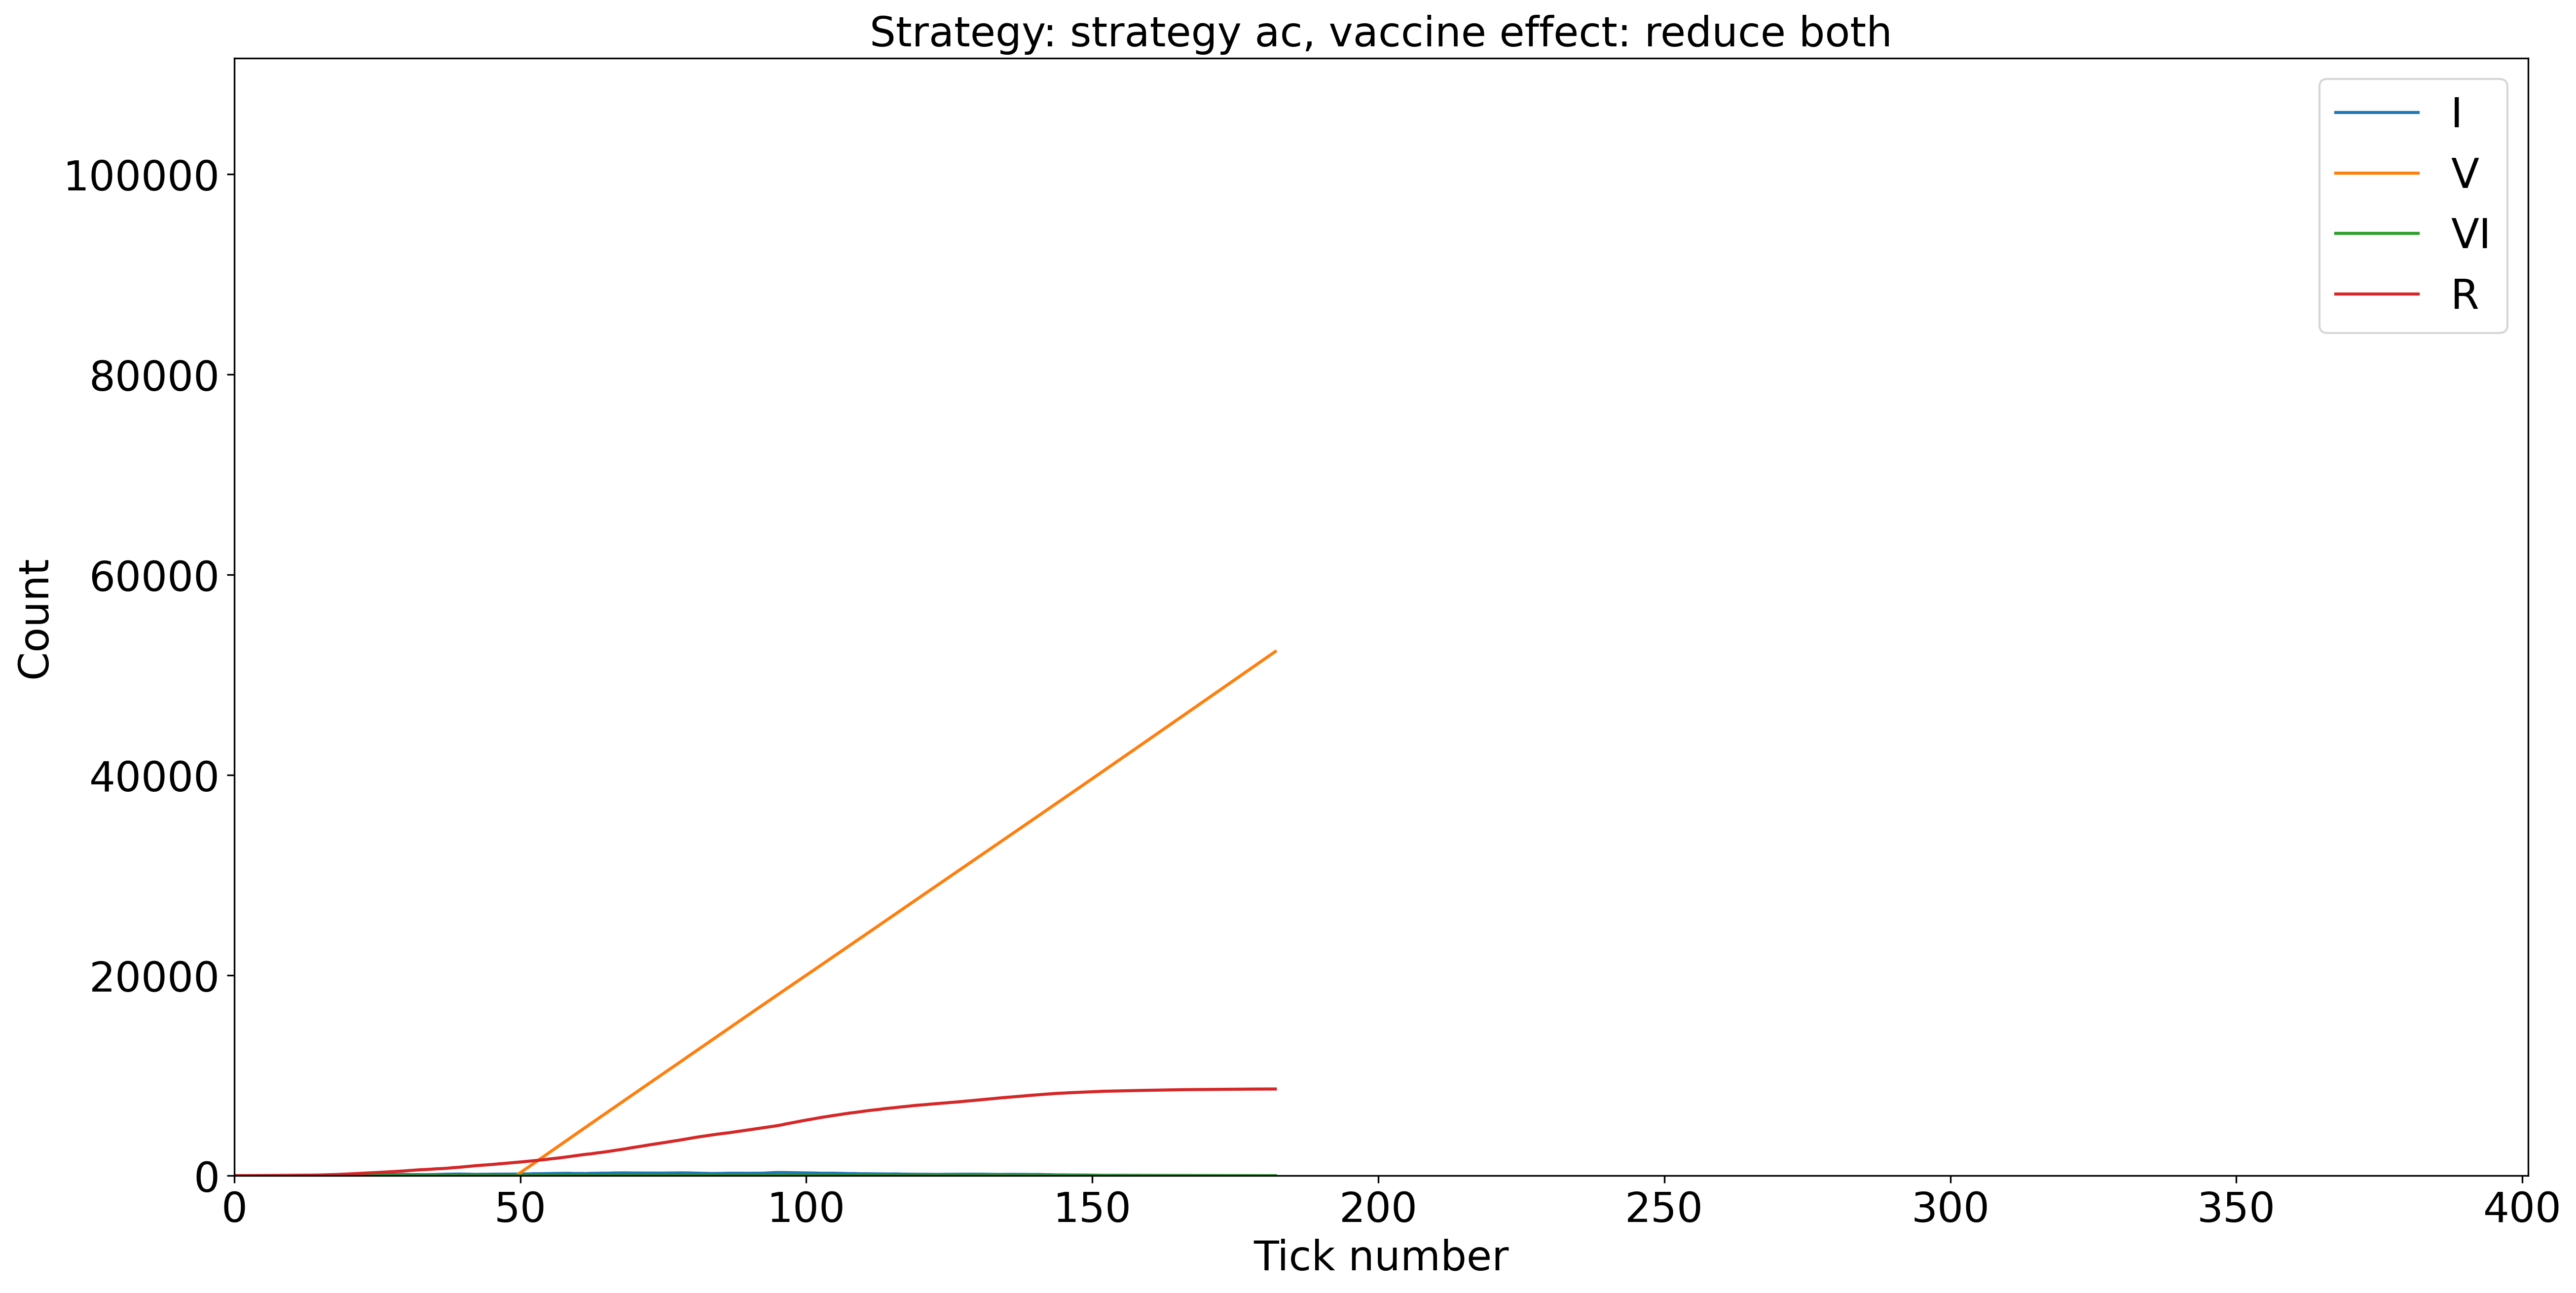

Strategy: strategy average dc ac
Vaccine effect: no effect


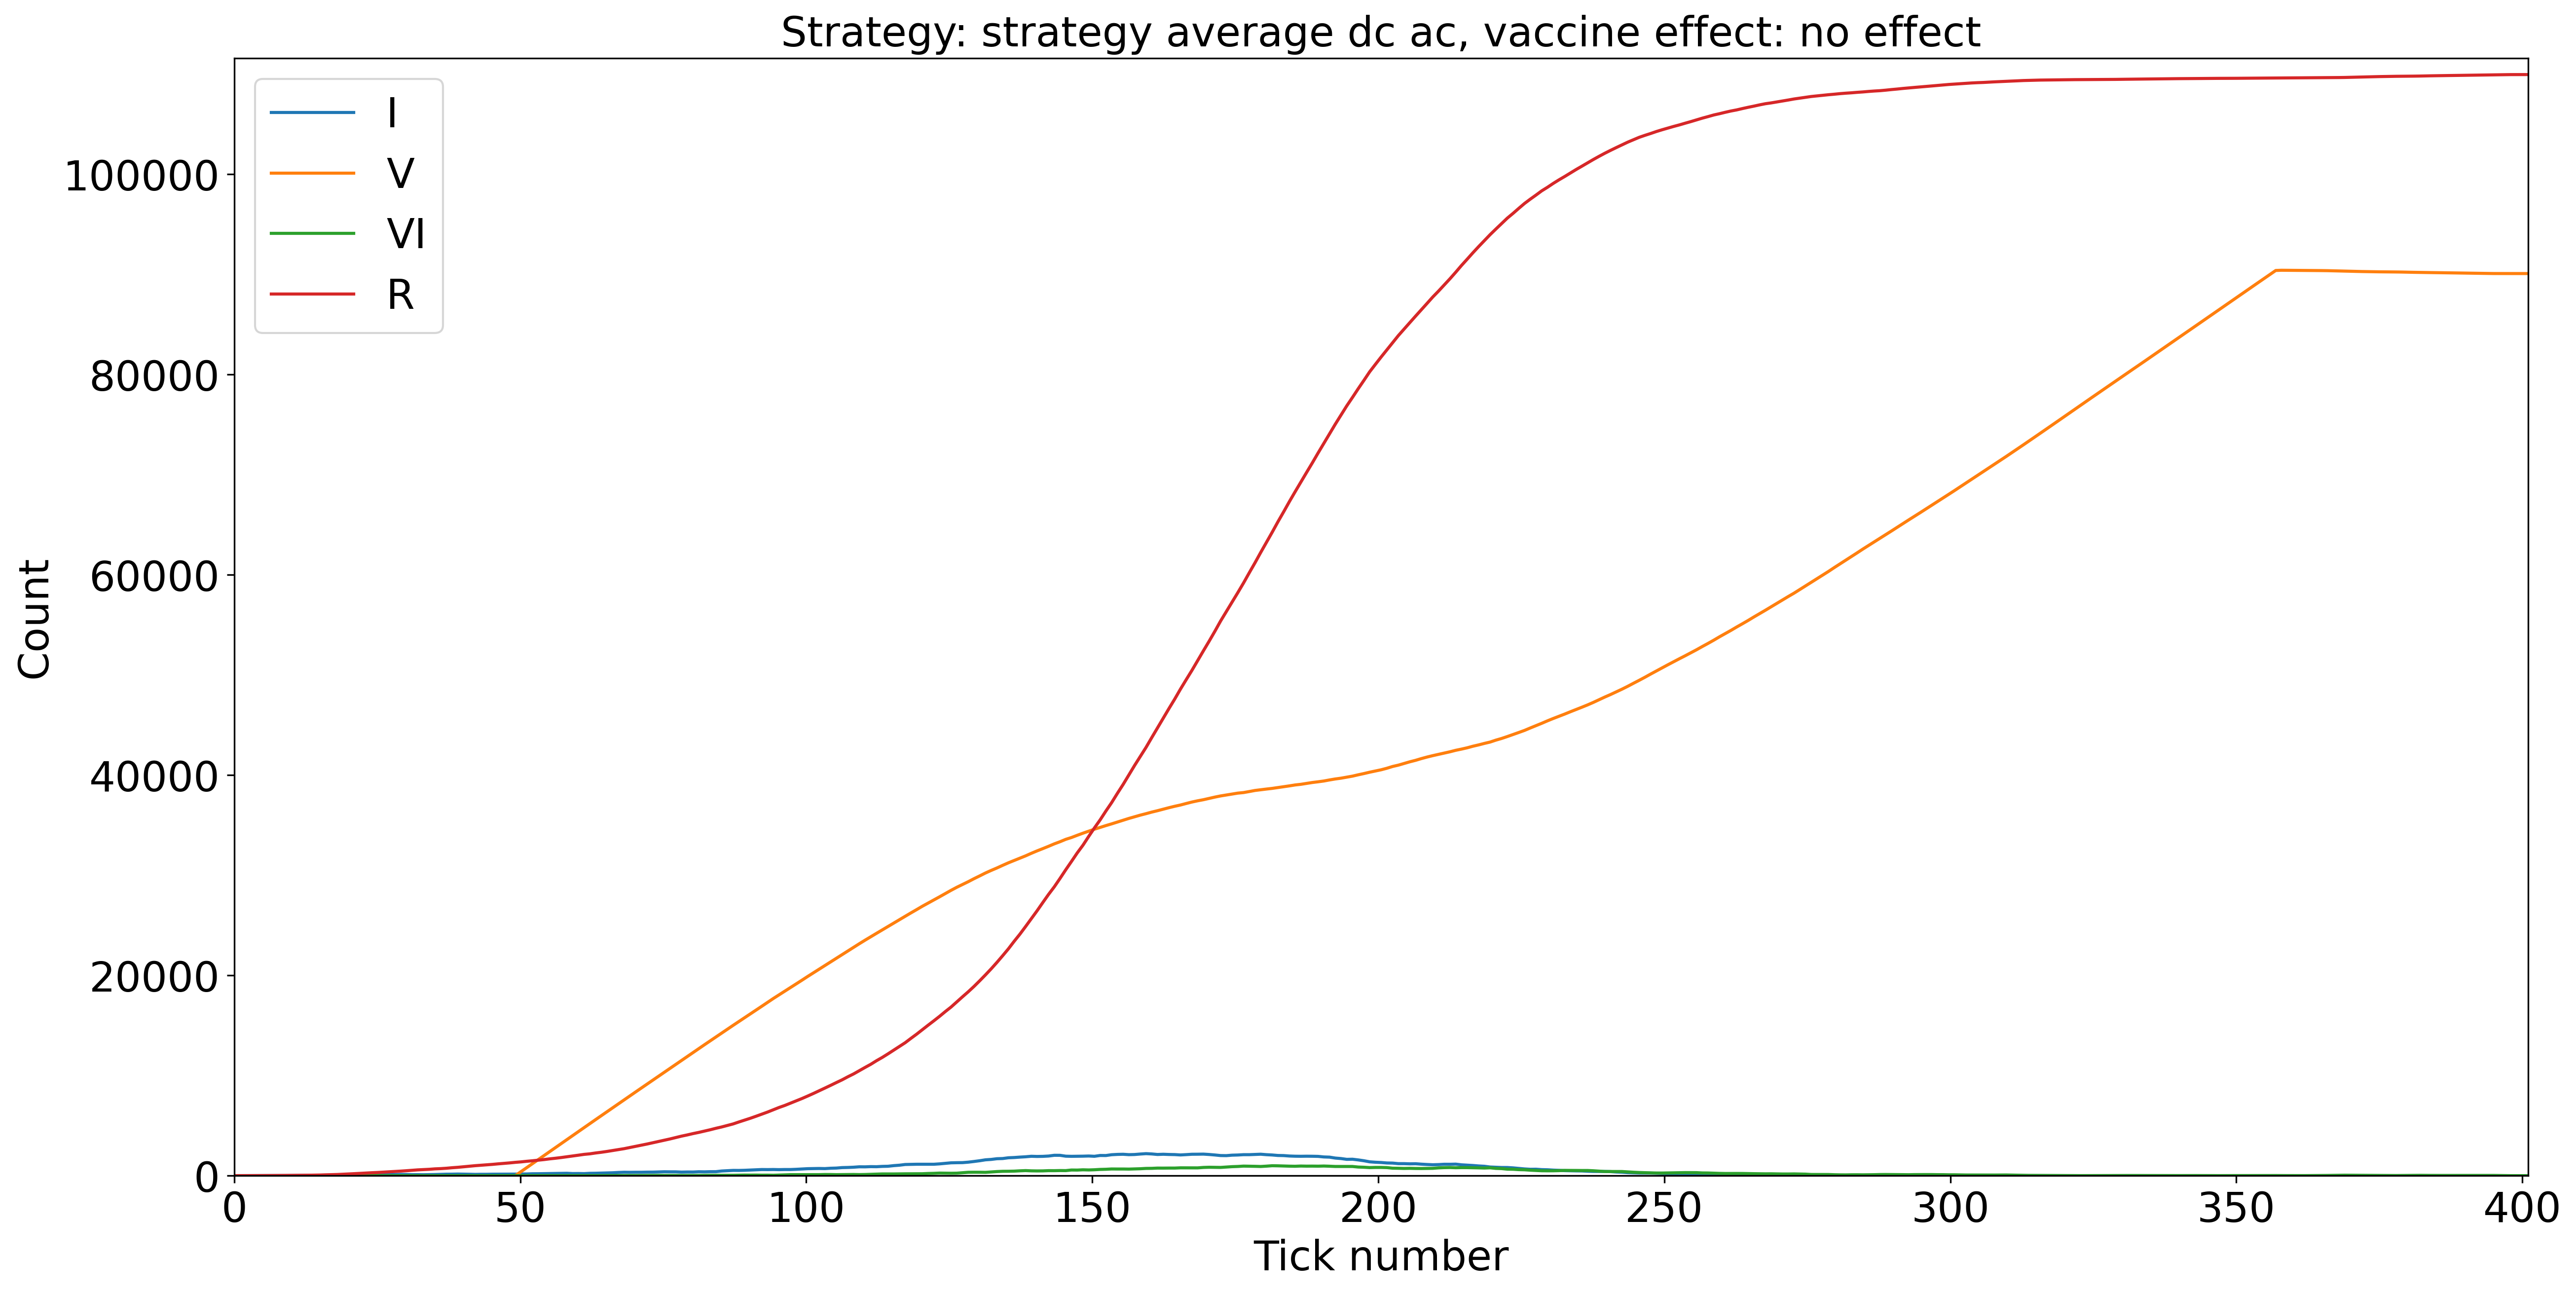

Strategy: strategy average dc ac
Vaccine effect: reduce transmission


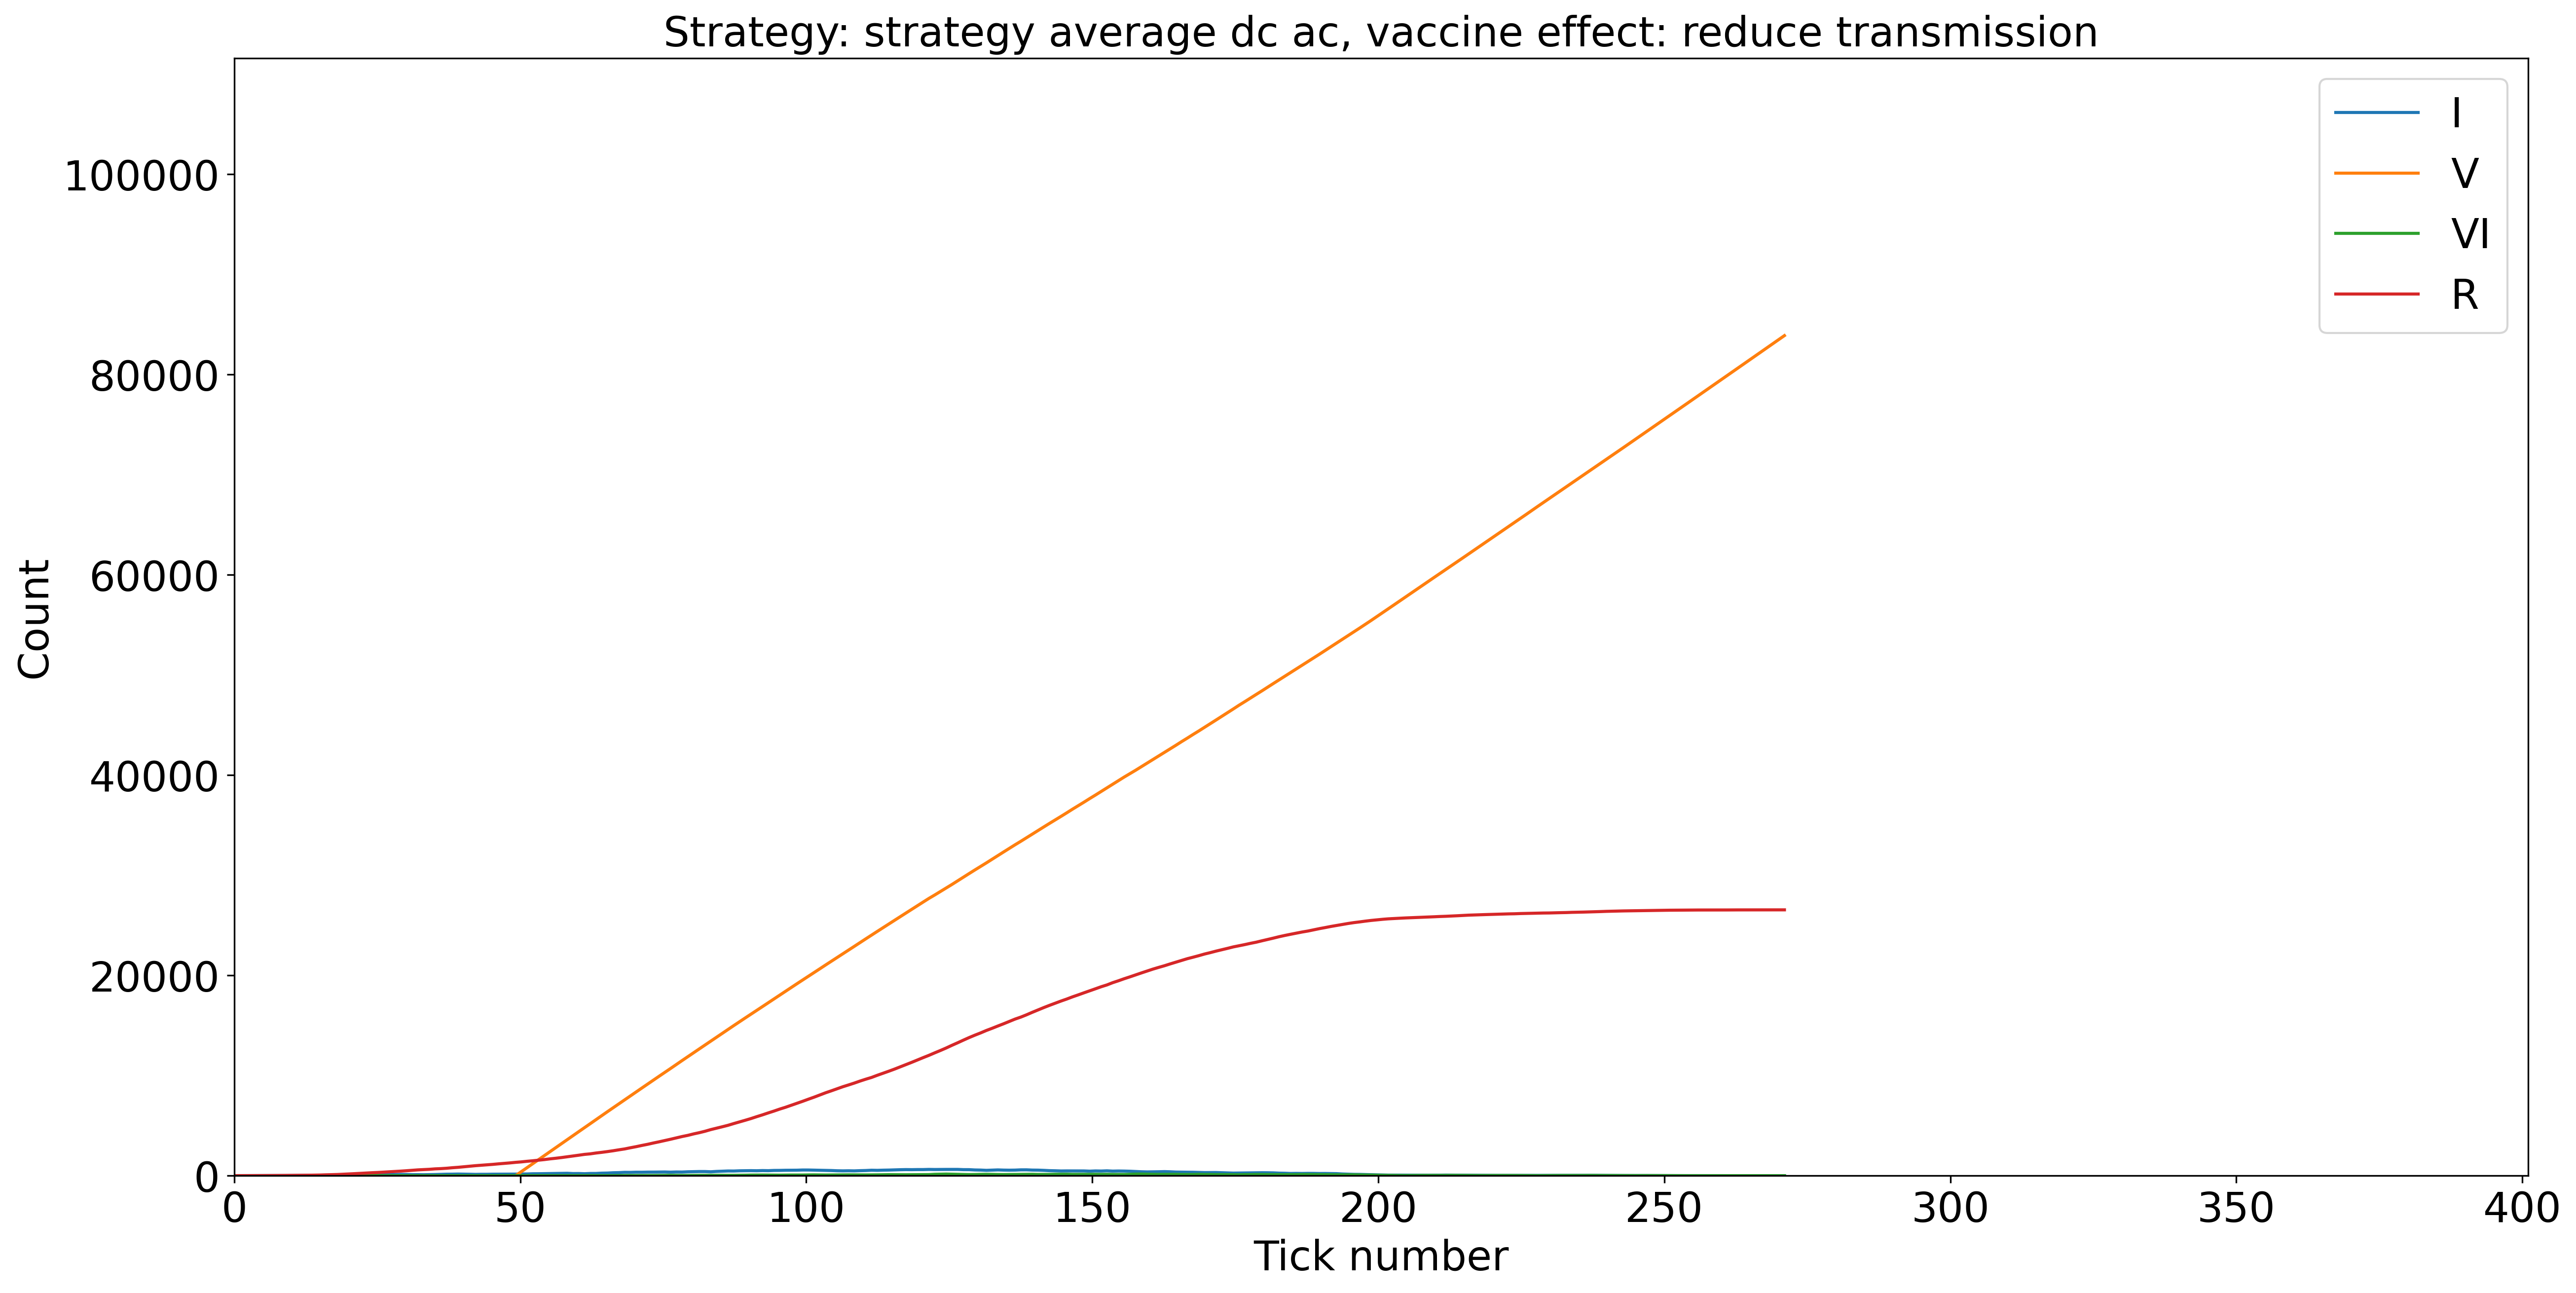

Strategy: strategy average dc ac
Vaccine effect: reduce infection


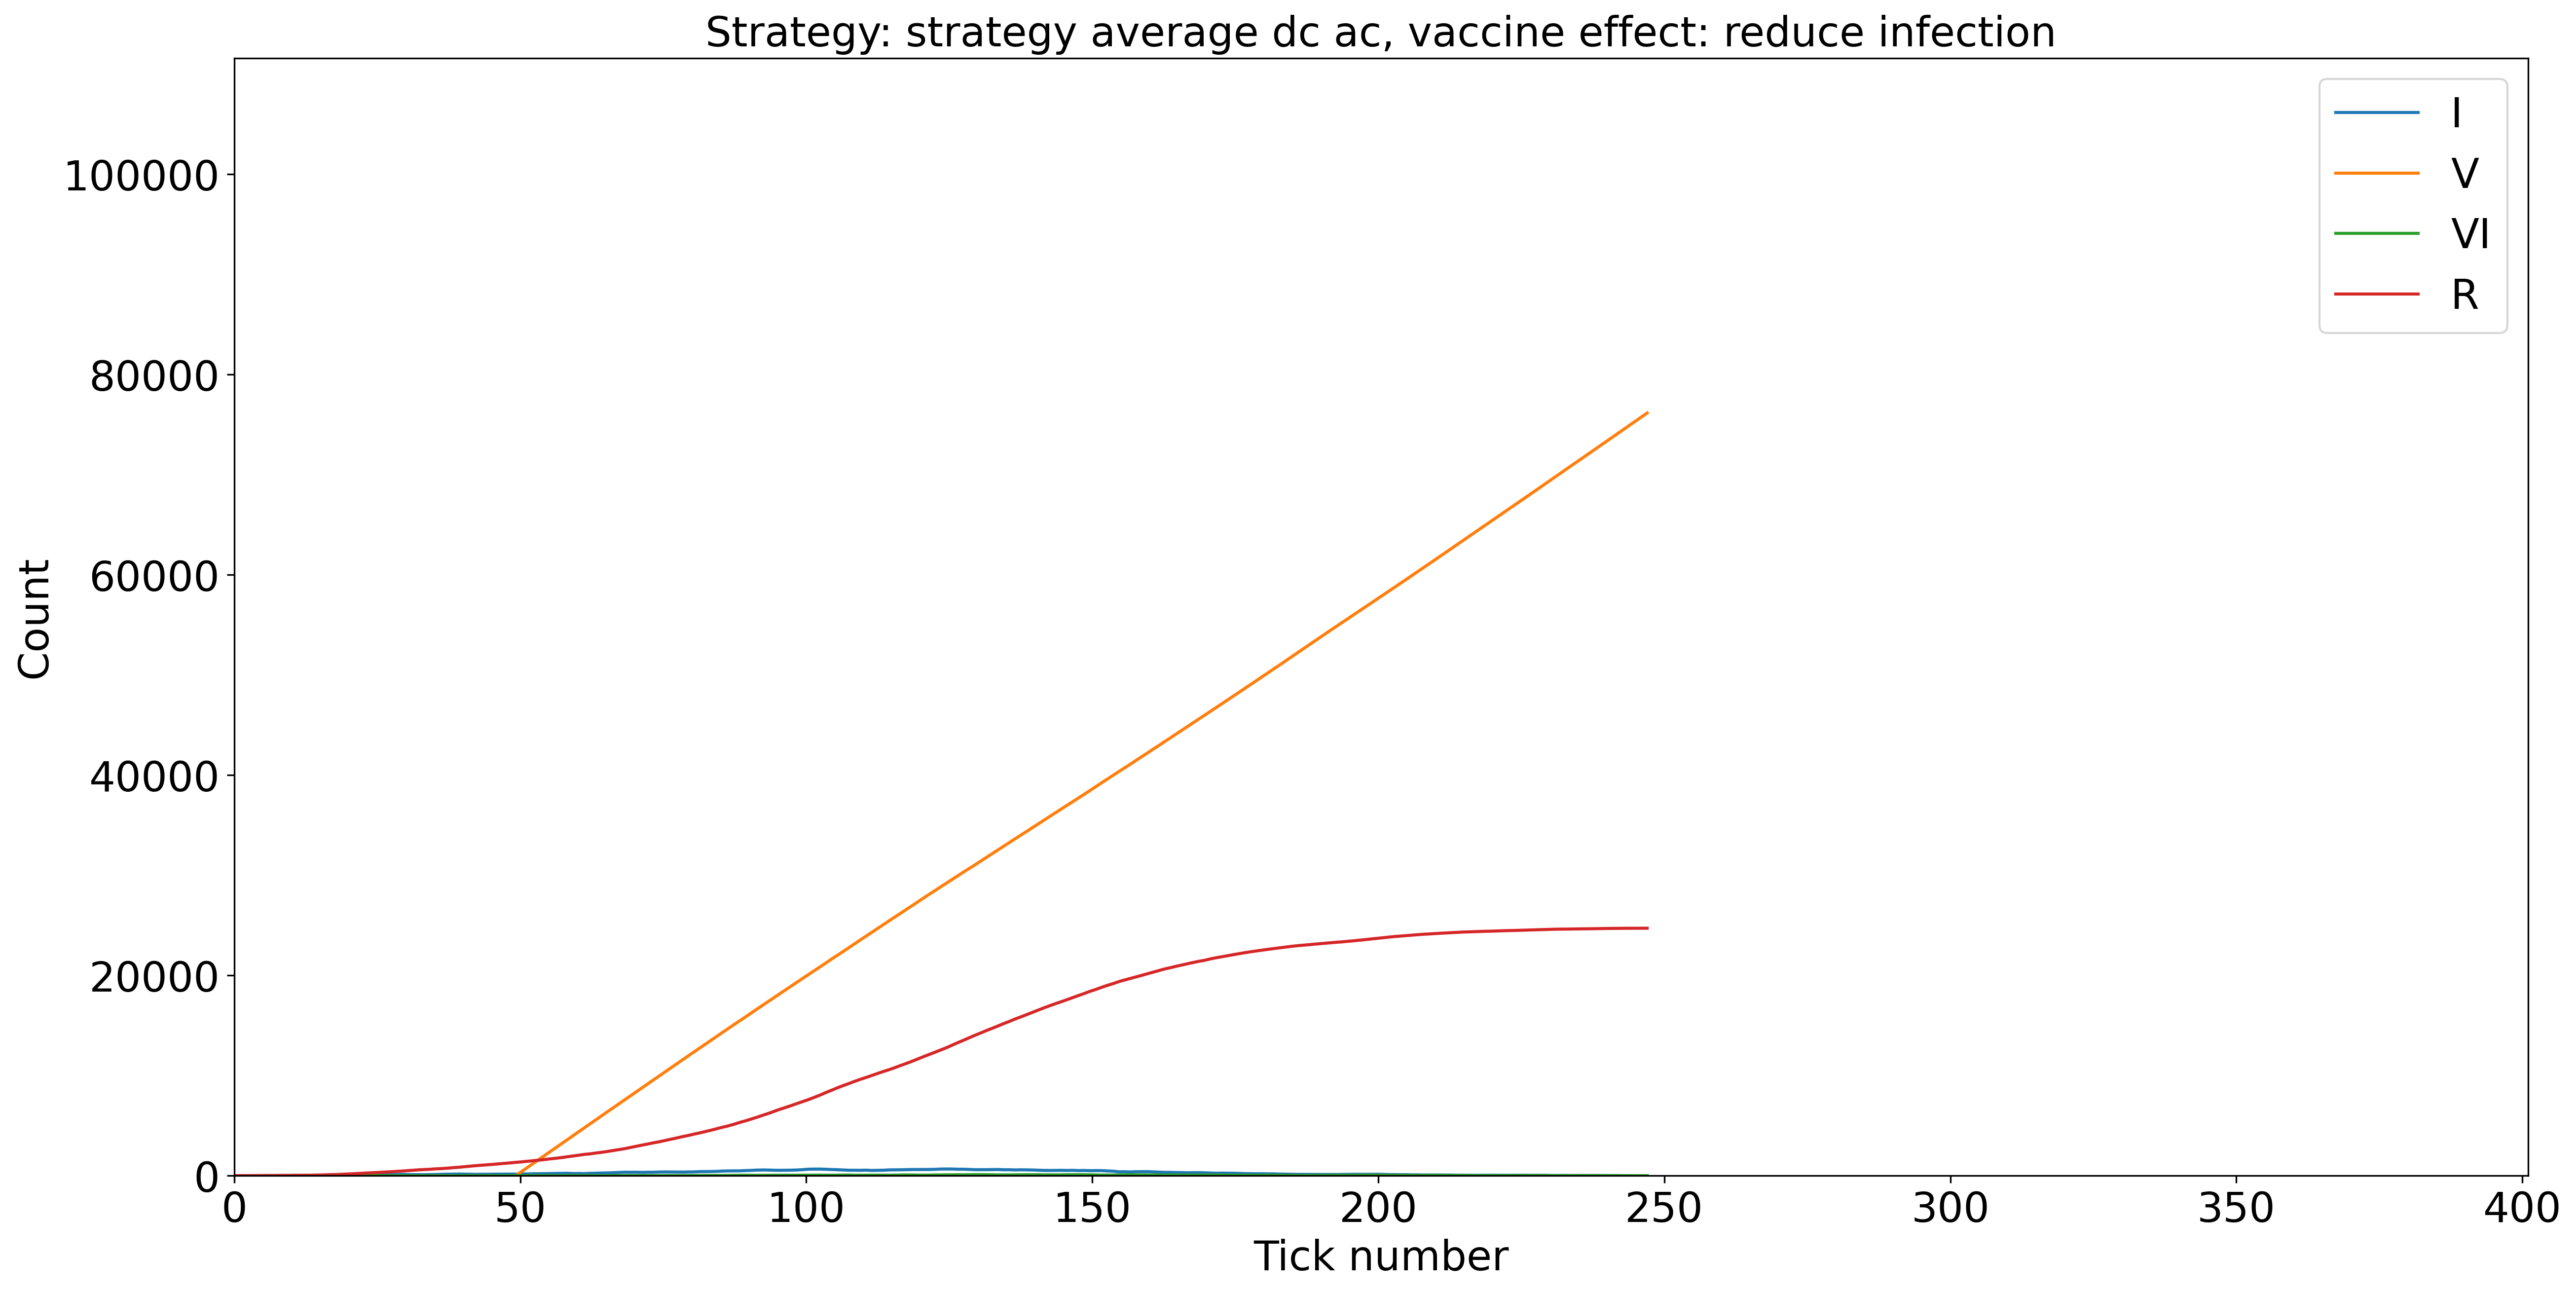

Strategy: strategy average dc ac
Vaccine effect: reduce both


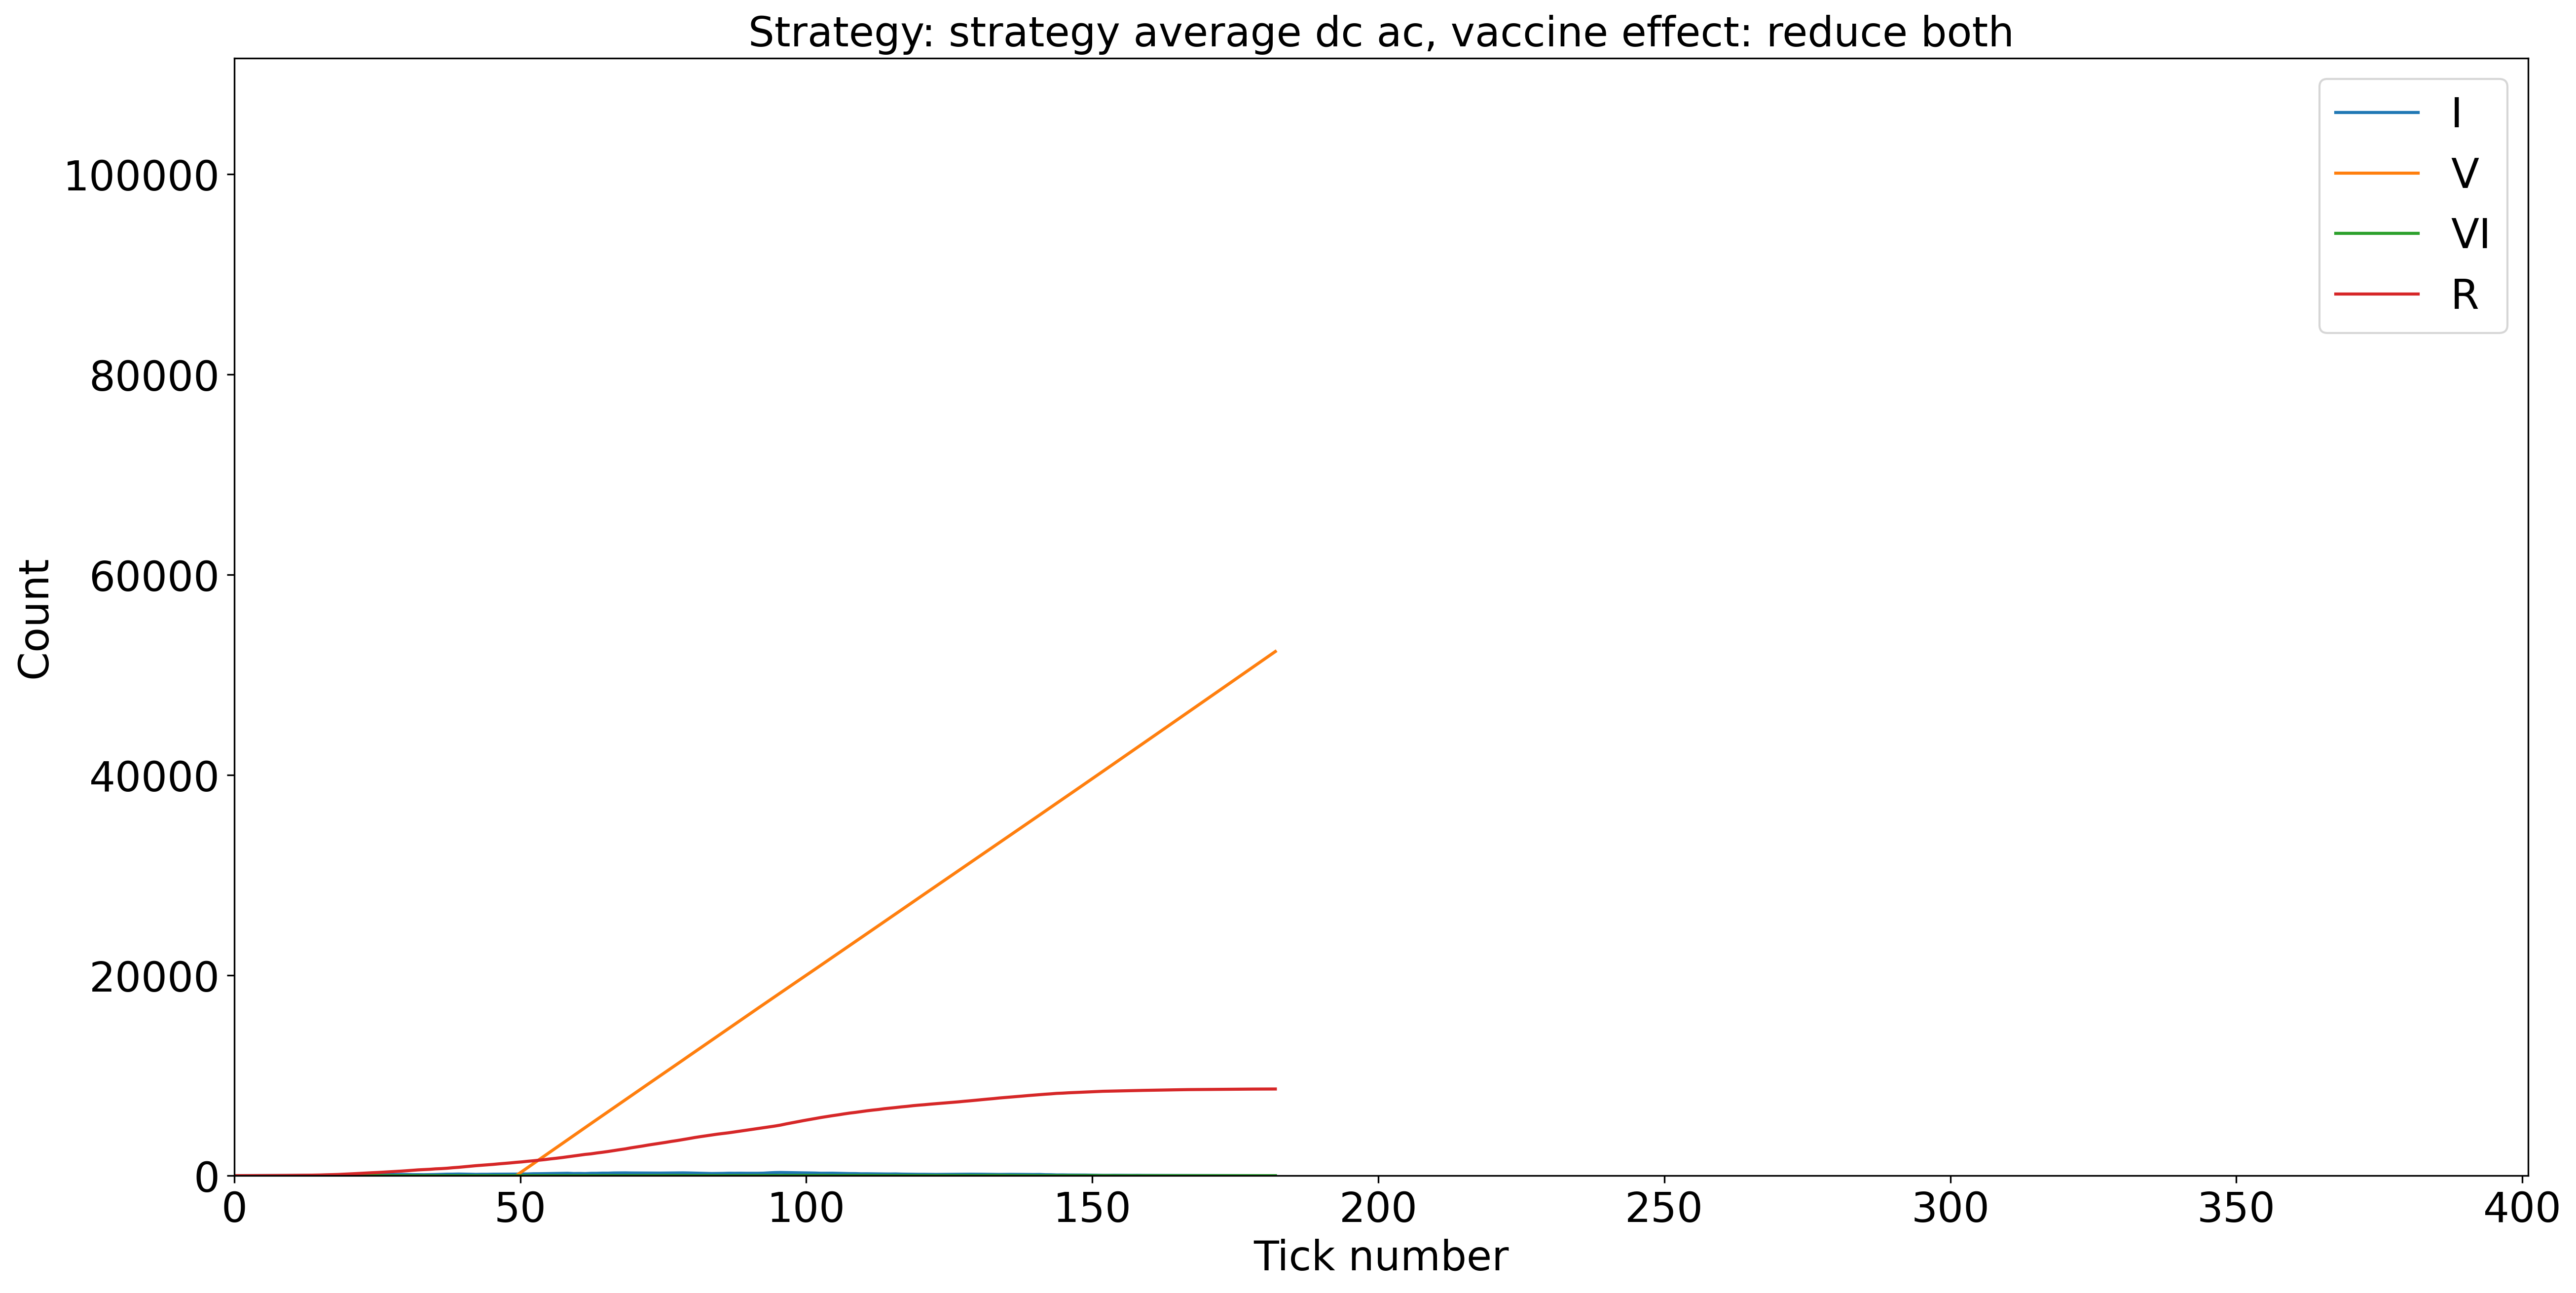

In [22]:
max_xs = []
max_ys = []

for vaccine_strategy in vaccination_strategy:
    for vaccine_effect in vaccine_effects:
        max_xs.append(len(models[vaccine_strategy][vaccine_effect][0]))
        max_ys.append(max(sum(models[vaccine_strategy][vaccine_effect][1:], [])))

max_x = max(max_xs)
max_y = max(max_ys)
for vaccine_strategy in vaccination_strategy:
    for vaccine_effect in vaccine_effects:
        print(f"Strategy: {vaccine_strategy}")
        print(f"Vaccine effect: {vaccine_effect}")
        plot_epidemic_model_results(models[vaccine_strategy][vaccine_effect], max_x=max_x, max_y=max_y, title=f"Strategy: {vaccine_strategy}, vaccine effect: {vaccine_effect}")